# On particle filters applied to electricity load forecasting

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math

In [2]:
%load_ext autoreload
%autoreload 2
from elec_forecast.bootstrap_filter_model import BootstrapFilterModel
from elec_forecast.rm_estimation import RmEstimation
from elec_forecast.particle_filter import ParticleFilter

### Parameters

In [3]:
M=10**3 #number of particles
n_pred=715  #number of predictions
N_daytype=8  #number of day types

### Load temperatures data 2015-2016

In [4]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [6]:
#temperatures every day at 3pm
hour="03:00"
temp_day=df_temp[df_temp.hour==hour]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [7]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [8]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']==hour]['Consommation'])
#for initialization
consumption = list(df[df['Heure']==hour]['Consommation'][:30])

### Daytype

In [9]:
daytype=np.array(df.daytype)

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [10]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
pred_forward=[0]

In [11]:
#Load pickle file
import pickle
output_file ='data/parameters_init_3am_20180114-010103.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init

{'g_heat_init': array([ -9.38774061e+36,  -6.54881681e+02,  -7.42328468e+03,
         -9.05655220e+03,  -9.02528188e+03,  -9.65827411e+03,
         -9.07148236e+03,  -9.83401857e+03,  -9.36271425e+03,
         -8.34467574e+03,  -8.82958725e+03,  -9.35627187e+03,
         -9.78284468e+03,  -1.06586900e+04,  -8.13145688e+03,
         -9.16094621e+03,  -9.34727902e+03,  -9.28328688e+03,
         -9.51709331e+03,  -7.53238435e+03,  -9.07025921e+03,
         -9.22004636e+03,  -9.40250994e+03,  -9.60397392e+03,
         -1.02848659e+04,  -8.83973304e+03,  -9.18825723e+03,
         -8.92311794e+03,  -8.31975957e+03,  -8.25016817e+03,
         -9.23220568e+03,  -1.05827387e+04,  -8.32264093e+03,
         -8.81791634e+03,  -9.35909901e+03,  -9.01289371e+03,
         -1.00687254e+04,  -1.05163643e+04,  -9.73611748e+03,
         -1.08378083e+04,  -1.00231962e+04,  -9.31369099e+03,
         -9.23425663e+03,  -9.24871705e+03,  -9.45771545e+03,
         -7.39232288e+03,  -9.58599336e+03,  -9.6144528

In [12]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [13]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*10**4
sigma_s_init=np.ones(M)*10**4
kappa=np.ones(M)*1/9

In [14]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [15]:
pf = ParticleFilter(consumption_day_ahead, 
                    T_h, 
                    daytype, 
                    n_pred, 
                    M, 
                    x_init, 
                    w_init,
                    kappa,
                    u_h, 
                    sigma_s_init, 
                    sigma_g_init, 
                    s_init, 
                    g_heat_init, 
                    sigma2)

ESS of normalized weights= 866.699371
ESS>=0.5*M
new ESS= 866.699371


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [16]:
x_predict, ESS_calc = pf.predict(pred_forward, n_pred, len_init)

n= 1
x_pred_mean = 6.71e+04 real consumption= 6.38e+04
x_pred min= 7.45e+02 x_pred max 3.40e+05
ESS of normalized weights= 150.440198
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
x_pred_mean = 1.33e+05 real consumption= 6.15e+04
x_pred min= 2.05e+03 x_pred max 6.24e+05
ESS of normalized weights= 104.008174
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 3
x_pred_mean = 1.47e+05 real consumption= 5.49e+04
x_pred min= 2.27e+03 x_pred max 7.35e+05
ESS of normalized weights= 96.378183
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
x_pred_mean = 1.96e+05 real consumption= 5.92e+04
x_pred min= 1.43e+03 x_pred max 9.94e+05
ESS of normalized weights= 64.780505
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 5
x_pred_mean = 2.31e+05 real consumption= 6.57e+04
x_pred min= 1.61e+03 x_pred max 1.06e+06
ESS of normalized weights= 61.117821
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------

new ESS= 1000.0
------------------------
n= 45
x_pred_mean = 1.05e+05 real consumption= 5.92e+04
x_pred min= 4.11e+02 x_pred max 3.52e+05
ESS of normalized weights= 142.398322
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 46
x_pred_mean = 4.96e+05 real consumption= 6.10e+04
x_pred min= 1.16e+04 x_pred max 2.24e+06
ESS of normalized weights= 17.596131
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 47
x_pred_mean = 5.55e+05 real consumption= 6.30e+04
x_pred min= 1.27e+04 x_pred max 2.49e+06
ESS of normalized weights= 17.952531
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 48
x_pred_mean = 1.08e+06 real consumption= 6.54e+04
x_pred min= 1.08e+04 x_pred max 4.79e+06
ESS of normalized weights= 3.886507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 49
x_pred_mean = 1.18e+06 real consumption= 6.68e+04
x_pred min= 1.42e+04 x_pred max 5.28e+06
ESS of normalized weights= 7.581923
ESS>=0.001

new ESS= 1000.0
------------------------
n= 90
x_pred_mean = 1.21e+05 real consumption= 5.23e+04
x_pred min= 5.78e+03 x_pred max 3.63e+05
ESS of normalized weights= 59.407161
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 91
No heating effect
x_pred_mean = 6.75e+04 real consumption= 5.41e+04
x_pred min= 1.60e+01 x_pred max 3.38e+05
ESS of normalized weights= 165.052785
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 92
x_pred_mean = 9.44e+05 real consumption= 5.29e+04
x_pred min= 2.22e+04 x_pred max 3.72e+06
ESS of normalized weights= 3.616198
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 93
x_pred_mean = 1.40e+06 real consumption= 5.04e+04
x_pred min= 1.49e+04 x_pred max 5.22e+06
ESS of normalized weights= 1.060483
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 94
x_pred_mean = 1.64e+06 real consumption= 5.23e+04
x_pred min= 4.24e+04 x_pred max 6.48e+06
ESS of normalized weights= 1.

new ESS= 1000.0
------------------------
n= 133
x_pred_mean = 6.89e+05 real consumption= 3.82e+04
x_pred min= 2.02e+04 x_pred max 2.73e+06
ESS of normalized weights= 6.7974
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 134
x_pred_mean = 4.54e+05 real consumption= 3.79e+04
x_pred min= 1.37e+04 x_pred max 1.71e+06
ESS of normalized weights= 9.312566
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 135
x_pred_mean = 1.33e+05 real consumption= 3.91e+04
x_pred min= 6.50e+03 x_pred max 4.46e+05
ESS of normalized weights= 63.728795
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 136
x_pred_mean = 3.88e+05 real consumption= 3.76e+04
x_pred min= 1.66e+04 x_pred max 1.40e+06
ESS of normalized weights= 9.010249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 137
No heating effect
x_pred_mean = 8.57e+04 real consumption= 3.74e+04
x_pred min= 3.20e+02 x_pred max 3.72e+05
ESS of normalized weights= 1

new ESS= 1000.0
------------------------
n= 173
No heating effect
x_pred_mean = 9.33e+04 real consumption= 3.93e+04
x_pred min= 1.35e+02 x_pred max 3.85e+05
ESS of normalized weights= 115.770053
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 174
No heating effect
x_pred_mean = 9.35e+04 real consumption= 3.93e+04
x_pred min= 1.61e+02 x_pred max 3.79e+05
ESS of normalized weights= 133.09475
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 175
No heating effect
x_pred_mean = 9.41e+04 real consumption= 3.96e+04
x_pred min= 1.40e+02 x_pred max 3.91e+05
ESS of normalized weights= 129.204543
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 176
No heating effect
x_pred_mean = 9.43e+04 real consumption= 3.97e+04
x_pred min= 3.45e+01 x_pred max 3.95e+05
ESS of normalized weights= 126.791644
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 177
No heating effect
x_pred_mean = 9.42e+04 real consumption

new ESS= 1000.0
------------------------
n= 212
x_pred_mean = 2.55e+05 real consumption= 3.59e+04
x_pred min= 1.21e+04 x_pred max 7.44e+05
ESS of normalized weights= 13.679099
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 213
No heating effect
x_pred_mean = 1.00e+05 real consumption= 3.43e+04
x_pred min= 4.39e+02 x_pred max 4.60e+05
ESS of normalized weights= 115.233316
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 214
No heating effect
x_pred_mean = 9.99e+04 real consumption= 3.43e+04
x_pred min= 2.43e+02 x_pred max 4.62e+05
ESS of normalized weights= 122.448867
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 215
No heating effect
x_pred_mean = 9.99e+04 real consumption= 3.62e+04
x_pred min= 8.08e+01 x_pred max 4.66e+05
ESS of normalized weights= 117.939062
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 216
No heating effect
x_pred_mean = 1.00e+05 real consumption= 3.58e+04
x_pred 

new ESS= 1000.0
------------------------
n= 250
x_pred_mean = 1.51e+06 real consumption= 3.86e+04
x_pred min= 1.19e+04 x_pred max 5.27e+06
ESS of normalized weights= 2.847745
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 251
x_pred_mean = 2.52e+06 real consumption= 3.89e+04
x_pred min= 2.02e+04 x_pred max 8.81e+06
ESS of normalized weights= 1.848212
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 252
x_pred_mean = 5.51e+05 real consumption= 3.89e+04
x_pred min= 1.40e+04 x_pred max 1.70e+06
ESS of normalized weights= 1.782255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 253
x_pred_mean = 1.53e+06 real consumption= 3.90e+04
x_pred min= 1.96e+04 x_pred max 5.37e+06
ESS of normalized weights= 1.424314
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 254
x_pred_mean = 1.71e+06 real consumption= 3.73e+04
x_pred min= 1.29e+04 x_pred max 5.87e+06
ESS of normalized weights= 1.015253
ESS>=0.00

new ESS= 1000.0
------------------------
n= 293
x_pred_mean = 1.37e+06 real consumption= 4.98e+04
x_pred min= 4.05e+04 x_pred max 5.01e+06
ESS of normalized weights= 2.568558
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 294
x_pred_mean = 1.93e+05 real consumption= 4.92e+04
x_pred min= 6.26e+03 x_pred max 5.82e+05
ESS of normalized weights= 39.153862
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 295
No heating effect
x_pred_mean = 1.04e+05 real consumption= 4.78e+04
x_pred min= 3.54e+02 x_pred max 4.92e+05
ESS of normalized weights= 104.013215
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 296
x_pred_mean = 1.23e+06 real consumption= 4.63e+04
x_pred min= 7.74e+03 x_pred max 4.56e+06
ESS of normalized weights= 3.917277
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 297
No heating effect
x_pred_mean = 1.04e+05 real consumption= 4.07e+04
x_pred min= 1.91e+02 x_pred max 4.88e+05
ESS of

new ESS= 1000.0
------------------------
n= 334
x_pred_mean = 2.78e+06 real consumption= 5.41e+04
x_pred min= 1.68e+04 x_pred max 1.18e+07
ESS of normalized weights= 1.01817
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 335
x_pred_mean = 2.79e+06 real consumption= 5.47e+04
x_pred min= 6.00e+04 x_pred max 1.20e+07
ESS of normalized weights= 1.884201
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 336
x_pred_mean = 3.03e+06 real consumption= 5.70e+04
x_pred min= 8.37e+04 x_pred max 1.31e+07
ESS of normalized weights= 1.012212
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 337
x_pred_mean = 2.26e+06 real consumption= 5.66e+04
x_pred min= 3.05e+04 x_pred max 9.43e+06
ESS of normalized weights= 1.181473
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 338
x_pred_mean = 2.30e+06 real consumption= 5.50e+04
x_pred min= 4.70e+04 x_pred max 9.58e+06
ESS of normalized weights= 1.000651
ESS>=0.001

new ESS= 1000.0
------------------------
n= 379
x_pred_mean = 7.19e+06 real consumption= 6.49e+04
x_pred min= 9.42e+04 x_pred max 2.78e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 380
x_pred_mean = 4.42e+06 real consumption= 6.59e+04
x_pred min= 4.87e+04 x_pred max 1.69e+07
ESS of normalized weights= 1.006671
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 381
x_pred_mean = 5.76e+05 real consumption= 6.53e+04
x_pred min= 3.76e+03 x_pred max 2.05e+06
ESS of normalized weights= 3.330804
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 382
x_pred_mean = 2.93e+06 real consumption= 6.65e+04
x_pred min= 4.27e+04 x_pred max 1.16e+07
ESS of normalized weights= 1.000334
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 383
x_pred_mean = 6.08e+06 real consumption= 7.03e+04
x_pred min= 6.90e+04 x_pred max 2.46e+07
ESS of normalized weights= 1.142699
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 425
x_pred_mean = 9.51e+06 real consumption= 6.48e+04
x_pred min= 9.10e+04 x_pred max 4.17e+07
ESS of normalized weights= 1.021461
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 426
x_pred_mean = 1.44e+07 real consumption= 6.00e+04
x_pred min= 1.69e+05 x_pred max 6.35e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 427
x_pred_mean = 1.42e+07 real consumption= 6.23e+04
x_pred min= 1.80e+05 x_pred max 6.45e+07
ESS of normalized weights= 1.000029
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 428
x_pred_mean = 1.31e+07 real consumption= 6.11e+04
x_pred min= 7.32e+04 x_pred max 5.93e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 429
x_pred_mean = 1.09e+07 real consumption= 5.91e+04
x_pred min= 1.09e+05 x_pred max 4.74e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 468
x_pred_mean = 1.64e+07 real consumption= 4.67e+04
x_pred min= 4.98e+04 x_pred max 6.41e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 469
x_pred_mean = 1.19e+07 real consumption= 4.74e+04
x_pred min= 1.35e+05 x_pred max 4.95e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 470
x_pred_mean = 1.09e+07 real consumption= 4.61e+04
x_pred min= 9.22e+04 x_pred max 4.49e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 471
x_pred_mean = 1.40e+07 real consumption= 4.44e+04
x_pred min= 1.04e+05 x_pred max 5.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 472
x_pred_mean = 1.10e+07 real consumption= 4.39e+04
x_pred min= 1.49e+05 x_pred max 4.53e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

C:\Users\Zakarya\workspace\smc_electricity_forecast\elec_forecast\particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 475
x_pred_mean = 8.40e+06 real consumption= 4.64e+04
x_pred min= 8.87e+04 x_pred max 3.63e+07
ESS of normalized weights= 1.00208
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 476
x_pred_mean = 2.27e+06 real consumption= 4.49e+04
x_pred min= 6.22e+04 x_pred max 9.55e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 477
No heating effect
x_pred_mean = 1.28e+05 real consumption= 4.37e+04
x_pred min= 3.47e+01 x_pred max 4.97e+05
ESS of normalized weights= 95.992661
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 478
No heating effect
x_pred_mean = 1.28e+05 real consumption= 4.29e+04
x_pred min= 5.80e+02 x_pred max 5.01e+05
ESS of normalized weights= 106.989425
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 479
No heating effect
x_pred_mean = 1.28e+05 real consump

No heating effect
x_pred_mean = 1.30e+05 real consumption= 3.58e+04
x_pred min= 4.29e+02 x_pred max 5.45e+05
ESS of normalized weights= 105.016864
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 516
No heating effect
x_pred_mean = 1.30e+05 real consumption= 3.98e+04
x_pred min= 3.10e+01 x_pred max 5.41e+05
ESS of normalized weights= 100.349493
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 517
No heating effect
x_pred_mean = 1.30e+05 real consumption= 4.01e+04
x_pred min= 4.52e+02 x_pred max 5.37e+05
ESS of normalized weights= 97.393126
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 518
No heating effect
x_pred_mean = 1.30e+05 real consumption= 4.04e+04
x_pred min= 4.83e+02 x_pred max 5.43e+05
ESS of normalized weights= 111.505544
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 519
No heating effect
x_pred_mean = 1.30e+05 real consumption= 4.09e+04
x_pred min= 1.74e+02 x_pred max 5.50e

new ESS= 1000.0
------------------------
n= 554
No heating effect
x_pred_mean = 1.34e+05 real consumption= 4.01e+04
x_pred min= 1.57e+02 x_pred max 5.87e+05
ESS of normalized weights= 113.598556
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 555
No heating effect
x_pred_mean = 1.35e+05 real consumption= 3.88e+04
x_pred min= 3.02e+02 x_pred max 5.73e+05
ESS of normalized weights= 116.504441
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 556
No heating effect
x_pred_mean = 1.35e+05 real consumption= 3.71e+04
x_pred min= 6.32e+02 x_pred max 5.69e+05
ESS of normalized weights= 101.121343
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 557
No heating effect
x_pred_mean = 1.35e+05 real consumption= 3.72e+04
x_pred min= 2.44e+02 x_pred max 5.66e+05
ESS of normalized weights= 104.850039
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 558
No heating effect
x_pred_mean = 1.35e+05 real consumptio

new ESS= 1000.0
------------------------
n= 591
No heating effect
x_pred_mean = 1.41e+05 real consumption= 3.39e+04
x_pred min= 6.96e+02 x_pred max 5.77e+05
ESS of normalized weights= 95.14096
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 592
No heating effect
x_pred_mean = 1.42e+05 real consumption= 3.34e+04
x_pred min= 6.33e+02 x_pred max 5.80e+05
ESS of normalized weights= 101.309955
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 593
No heating effect
x_pred_mean = 1.43e+05 real consumption= 3.42e+04
x_pred min= 7.35e+01 x_pred max 5.76e+05
ESS of normalized weights= 95.95844
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 594
No heating effect
x_pred_mean = 1.43e+05 real consumption= 3.64e+04
x_pred min= 2.81e+01 x_pred max 5.87e+05
ESS of normalized weights= 85.538391
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 595
No heating effect
x_pred_mean = 1.43e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 629
No heating effect
x_pred_mean = 1.54e+05 real consumption= 3.84e+04
x_pred min= 8.58e+01 x_pred max 6.56e+05
ESS of normalized weights= 84.272048
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 630
x_pred_mean = 1.82e+07 real consumption= 3.85e+04
x_pred min= 7.61e+04 x_pred max 7.47e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 631
x_pred_mean = 6.12e+06 real consumption= 3.84e+04
x_pred min= 7.55e+04 x_pred max 2.40e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 632
x_pred_mean = 1.04e+07 real consumption= 3.70e+04
x_pred min= 1.34e+05 x_pred max 4.09e+07
ESS of normalized weights= 1.000075
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 633
x_pred_mean = 1.69e+07 real consumption= 3.52e+04
x_pred min= 1.56e+05 x_pred max 6.68e+07
ESS of normalized weights= 1.0
ESS>=

new ESS= 1000.0
------------------------
n= 670
x_pred_mean = 8.17e+06 real consumption= 4.54e+04
x_pred min= 1.83e+05 x_pred max 3.70e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 671
No heating effect
x_pred_mean = 1.67e+05 real consumption= 4.50e+04
x_pred min= 2.75e+01 x_pred max 7.04e+05
ESS of normalized weights= 75.219914
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 672
No heating effect
x_pred_mean = 1.67e+05 real consumption= 5.10e+04
x_pred min= 7.33e+02 x_pred max 6.96e+05
ESS of normalized weights= 72.869765
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 673
x_pred_mean = 8.14e+06 real consumption= 5.27e+04
x_pred min= 9.43e+04 x_pred max 3.53e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 674
x_pred_mean = 9.70e+05 real consumption= 4.88e+04
x_pred min= 3.51e+04 x_pred max 3.78e+06
ESS of normalized

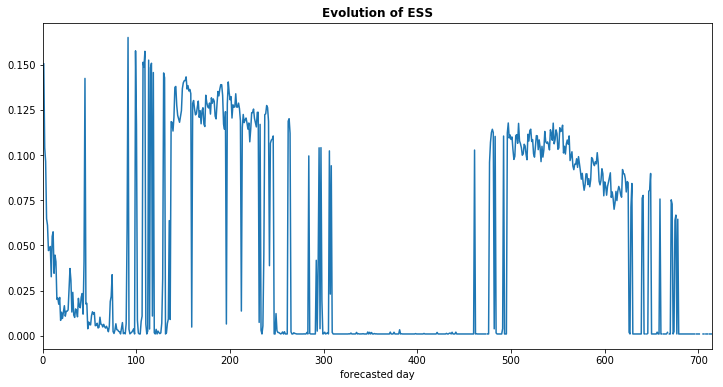

In [17]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,n_pred),ESS_calc[0,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[1,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[2,1:n_pred]/M)

plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

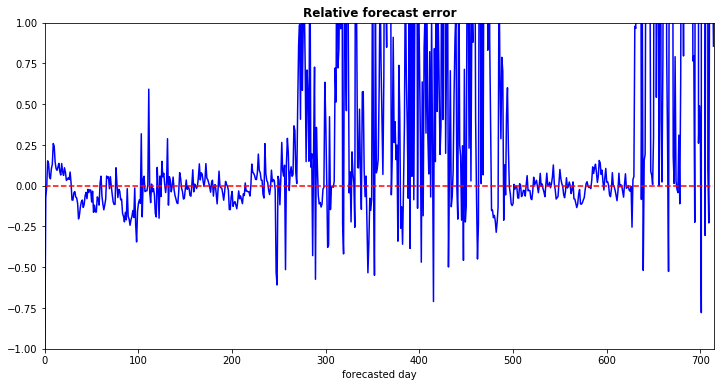

In [18]:
fig=plt.figure(figsize=(12,6))

plt.plot(range(n_pred),(x_predict[0,:]-consumption_day_ahead[:n_pred])/consumption_day_ahead[:n_pred],color='blue')
#plt.plot(range(n_pred),(x_predict[1,:]-consumption_day_ahead[1:n_pred+1])/consumption_day_ahead[1:n_pred+1],color='orange')
#plt.plot(range(n_pred),(x_predict[2,:]-consumption_day_ahead[2:n_pred+2])/consumption_day_ahead[2:n_pred+2],color='green')

plt.plot(range(n_pred-1),np.zeros(n_pred-1),color='red',linestyle='--')
plt.ylim(-1,1)
plt.xlim(0,n_pred)
plt.xlabel('forecasted day')
plt.title("Relative forecast error",fontweight='bold')
plt.show()

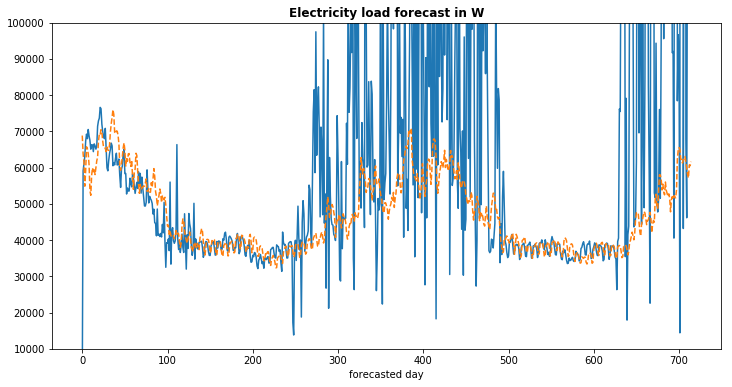

In [19]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred),x_predict[0,:])
#plt.plot(range(n_pred),x_predict[1,:])
#plt.plot(range(n_pred),x_predict[2,:])
plt.plot(range(n_pred),consumption_day_ahead[:n_pred],linestyle='--')
plt.xlabel('forecasted day')
plt.ylim(10**4,10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [ ]:
len_filter_pmmh=715
len_iter_mha=300

#### PMMH Algorithm

In [ ]:
pf.pmmh(len_filter_pmmh, len_iter_mha, pred_forward, len_init)

log_prior_init= -56.3146626545
n= 1
x_pred_mean = 6.99e+04 real consumption= 6.38e+04
x_pred min= 9.44e+02 x_pred max 3.21e+05
ESS of normalized weights= 307.392724
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
x_pred_mean = 1.38e+05 real consumption= 6.15e+04
x_pred min= 2.49e+03 x_pred max 6.82e+05
ESS of normalized weights= 181.819857
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 3
x_pred_mean = 1.54e+05 real consumption= 5.49e+04
x_pred min= 1.92e+03 x_pred max 8.75e+05
ESS of normalized weights= 139.41122
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
x_pred_mean = 1.96e+05 real consumption= 5.92e+04
x_pred min= 1.45e+03 x_pred max 9.61e+05
ESS of normalized weights= 110.146106
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 5
x_pred_mean = 2.35e+05 real consumption= 6.57e+04
x_pred min= 2.32e+03 x_pred max 1.18e+06
ESS of normalized weights= 79.716533
ESS>=0.001*M and ESS_

x_pred_mean = 3.17e+05 real consumption= 6.03e+04
x_pred min= 8.14e+03 x_pred max 1.67e+06
ESS of normalized weights= 43.172149
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 45
x_pred_mean = 1.31e+05 real consumption= 5.92e+04
x_pred min= 3.66e+03 x_pred max 6.21e+05
ESS of normalized weights= 158.494733
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 46
x_pred_mean = 6.35e+05 real consumption= 6.10e+04
x_pred min= 1.96e+04 x_pred max 3.57e+06
ESS of normalized weights= 23.095112
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 47
x_pred_mean = 7.08e+05 real consumption= 6.30e+04
x_pred min= 1.53e+04 x_pred max 3.98e+06
ESS of normalized weights= 15.45806
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 48
x_pred_mean = 1.37e+06 real consumption= 6.54e+04
x_pred min= 2.18e+04 x_pred max 7.83e+06
ESS of normalized weights= 7.876914
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------

new ESS= 1000.0
------------------------
n= 86
x_pred_mean = 1.39e+06 real consumption= 5.34e+04
x_pred min= 1.25e+04 x_pred max 5.21e+06
ESS of normalized weights= 9.341677
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 87
x_pred_mean = 9.08e+05 real consumption= 5.21e+04
x_pred min= 2.31e+04 x_pred max 3.40e+06
ESS of normalized weights= 7.688998
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 88
x_pred_mean = 7.02e+05 real consumption= 4.95e+04
x_pred min= 2.42e+04 x_pred max 2.49e+06
ESS of normalized weights= 9.718025
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 89
x_pred_mean = 3.29e+05 real consumption= 5.08e+04
x_pred min= 1.25e+04 x_pred max 1.07e+06
ESS of normalized weights= 33.443055
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 90
x_pred_mean = 8.88e+04 real consumption= 5.23e+04
x_pred min= 3.07e+03 x_pred max 2.26e+05
ESS of normalized weights= 233.810501
ESS>=0.001*

new ESS= 1000.0
------------------------
n= 127
x_pred_mean = 3.86e+05 real consumption= 4.01e+04
x_pred min= 1.52e+04 x_pred max 1.38e+06
ESS of normalized weights= 14.779411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 128
x_pred_mean = 1.36e+05 real consumption= 3.79e+04
x_pred min= 2.90e+03 x_pred max 4.16e+05
ESS of normalized weights= 103.118792
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 129
No heating effect
x_pred_mean = 6.22e+04 real consumption= 3.74e+04
x_pred min= 1.42e+02 x_pred max 2.98e+05
ESS of normalized weights= 350.07612
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 130
No heating effect
x_pred_mean = 6.24e+04 real consumption= 3.68e+04
x_pred min= 1.33e+01 x_pred max 2.83e+05
ESS of normalized weights= 348.314824
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 131
x_pred_mean = 1.44e+06 real consumption= 3.89e+04
x_pred min= 2.39e+04 x_pred max 6.07e+06
ESS

new ESS= 1000.0
------------------------
n= 165
No heating effect
x_pred_mean = 6.86e+04 real consumption= 3.56e+04
x_pred min= 4.01e+01 x_pred max 3.17e+05
ESS of normalized weights= 306.193422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 166
No heating effect
x_pred_mean = 6.88e+04 real consumption= 3.86e+04
x_pred min= 5.37e+01 x_pred max 3.16e+05
ESS of normalized weights= 309.646115
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 167
No heating effect
x_pred_mean = 6.90e+04 real consumption= 3.88e+04
x_pred min= 1.12e+02 x_pred max 3.20e+05
ESS of normalized weights= 312.23624
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 168
No heating effect
x_pred_mean = 6.89e+04 real consumption= 3.94e+04
x_pred min= 7.37e+01 x_pred max 3.27e+05
ESS of normalized weights= 320.197638
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 169
No heating effect
x_pred_mean = 6.89e+04 real consumption

new ESS= 1000.0
------------------------
n= 204
No heating effect
x_pred_mean = 7.67e+04 real consumption= 4.00e+04
x_pred min= 8.27e+00 x_pred max 4.00e+05
ESS of normalized weights= 290.479649
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 205
No heating effect
x_pred_mean = 7.71e+04 real consumption= 3.82e+04
x_pred min= 3.39e+02 x_pred max 3.99e+05
ESS of normalized weights= 285.717697
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 206
No heating effect
x_pred_mean = 7.71e+04 real consumption= 3.55e+04
x_pred min= 3.66e+01 x_pred max 4.01e+05
ESS of normalized weights= 285.870706
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 207
No heating effect
x_pred_mean = 7.72e+04 real consumption= 3.56e+04
x_pred min= 2.88e+02 x_pred max 4.03e+05
ESS of normalized weights= 286.97102
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 208
No heating effect
x_pred_mean = 7.75e+04 real consumption

n= 241
No heating effect
x_pred_mean = 8.51e+04 real consumption= 3.55e+04
x_pred min= 3.08e+01 x_pred max 4.11e+05
ESS of normalized weights= 265.049888
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 242
x_pred_mean = 1.97e+05 real consumption= 3.57e+04
x_pred min= 8.89e+03 x_pred max 6.09e+05
ESS of normalized weights= 41.491568
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 243
No heating effect
x_pred_mean = 8.61e+04 real consumption= 3.84e+04
x_pred min= 2.93e+02 x_pred max 4.02e+05
ESS of normalized weights= 271.016243
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 244
No heating effect
x_pred_mean = 8.61e+04 real consumption= 3.81e+04
x_pred min= 6.99e+01 x_pred max 4.03e+05
ESS of normalized weights= 267.27058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 245
No heating effect
x_pred_mean = 8.67e+04 real consumption= 3.83e+04
x_pred min= 2.43e+01 x_pred max 4.05e+05
ESS of n

new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 1.33e+05 real consumption= 4.01e+04
x_pred min= 5.81e+02 x_pred max 5.57e+05
ESS of normalized weights= 168.780693
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 1.27e+06 real consumption= 4.41e+04
x_pred min= 2.80e+04 x_pred max 4.48e+06
ESS of normalized weights= 2.957896
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 5.38e+06 real consumption= 4.68e+04
x_pred min= 3.62e+04 x_pred max 2.01e+07
ESS of normalized weights= 1.884457
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 287
x_pred_mean = 4.33e+06 real consumption= 4.98e+04
x_pred min= 4.92e+04 x_pred max 1.61e+07
ESS of normalized weights= 1.035483
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 288
x_pred_mean = 5.83e+06 real consumption= 5.20e+04
x_pred min= 9.64e+04 x_pred max 2.14e+07
ESS of normalized weights

new ESS= 1000.0
------------------------
n= 328
x_pred_mean = 1.54e+07 real consumption= 6.00e+04
x_pred min= 1.04e+05 x_pred max 5.77e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 329
x_pred_mean = 1.21e+07 real consumption= 5.83e+04
x_pred min= 1.21e+05 x_pred max 4.61e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 330
x_pred_mean = 9.73e+06 real consumption= 5.98e+04
x_pred min= 6.40e+04 x_pred max 3.62e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 331
x_pred_mean = 1.05e+07 real consumption= 5.83e+04
x_pred min= 1.02e+05 x_pred max 3.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 332
x_pred_mean = 1.28e+07 real consumption= 5.64e+04
x_pred min= 1.19e+05 x_pred max 4.69e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 1000.0
------------------------
n= 373
x_pred_mean = 1.13e+07 real consumption= 5.49e+04
x_pred min= 2.42e+05 x_pred max 4.02e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 374
x_pred_mean = 1.03e+07 real consumption= 5.30e+04
x_pred min= 1.11e+05 x_pred max 3.69e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 375
x_pred_mean = 7.74e+06 real consumption= 5.44e+04
x_pred min= 4.20e+04 x_pred max 2.67e+07
ESS of normalized weights= 1.985132
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 376
x_pred_mean = 4.97e+06 real consumption= 5.87e+04
x_pred min= 7.16e+04 x_pred max 1.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 377
x_pred_mean = 8.80e+06 real consumption= 6.18e+04
x_pred min= 8.41e+04 x_pred max 3.07e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 416
x_pred_mean = 1.76e+07 real consumption= 5.53e+04
x_pred min= 1.50e+05 x_pred max 7.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 417
x_pred_mean = 1.83e+07 real consumption= 5.29e+04
x_pred min= 1.56e+05 x_pred max 7.56e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 418
x_pred_mean = 1.39e+07 real consumption= 5.53e+04
x_pred min= 8.05e+04 x_pred max 5.45e+07
ESS of normalized weights= 1.458638
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 419
x_pred_mean = 1.49e+07 real consumption= 5.85e+04
x_pred min= 4.37e+04 x_pred max 6.02e+07
ESS of normalized weights= 1.143836
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 420
x_pred_mean = 1.39e+07 real consumption= 5.97e+04
x_pred min= 1.12e+05 x_pred max 5.58e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 462
x_pred_mean = 2.40e+06 real consumption= 4.96e+04
x_pred min= 4.54e+04 x_pred max 8.62e+06
ESS of normalized weights= 2.53888
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 463
x_pred_mean = 1.28e+06 real consumption= 5.21e+04
x_pred min= 4.35e+04 x_pred max 4.23e+06
ESS of normalized weights= 1.918011
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 464
x_pred_mean = 1.10e+07 real consumption= 5.08e+04
x_pred min= 1.05e+05 x_pred max 4.44e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 465
x_pred_mean = 1.31e+07 real consumption= 4.96e+04
x_pred min= 3.73e+04 x_pred max 5.34e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 466
x_pred_mean = 1.04e+07 real consumption= 4.54e+04
x_pred min= 2.14e+05 x_pred max 4.25e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.

new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 3.27e+05 real consumption= 4.03e+04
x_pred min= 9.83e+02 x_pred max 1.49e+06
ESS of normalized weights= 55.057059
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 503
No heating effect
x_pred_mean = 3.26e+05 real consumption= 4.06e+04
x_pred min= 2.10e+03 x_pred max 1.47e+06
ESS of normalized weights= 64.986046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 504
No heating effect
x_pred_mean = 3.26e+05 real consumption= 4.19e+04
x_pred min= 9.97e+02 x_pred max 1.49e+06
ESS of normalized weights= 59.928203
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 505
No heating effect
x_pred_mean = 3.28e+05 real consumption= 4.17e+04
x_pred min= 8.25e+02 x_pred max 1.47e+06
ESS of normalized weights= 58.692082
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 506
No heating effect
x_pred_mean = 3.28e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 541
No heating effect
x_pred_mean = 3.59e+05 real consumption= 3.75e+04
x_pred min= 2.67e+03 x_pred max 1.41e+06
ESS of normalized weights= 64.819443
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 542
No heating effect
x_pred_mean = 3.59e+05 real consumption= 3.54e+04
x_pred min= 2.76e+03 x_pred max 1.41e+06
ESS of normalized weights= 57.891221
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 543
No heating effect
x_pred_mean = 3.60e+05 real consumption= 3.56e+04
x_pred min= 8.99e+02 x_pred max 1.41e+06
ESS of normalized weights= 58.214283
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 544
No heating effect
x_pred_mean = 3.60e+05 real consumption= 3.85e+04
x_pred min= 2.04e+03 x_pred max 1.46e+06
ESS of normalized weights= 64.066148
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 545
No heating effect
x_pred_mean = 3.61e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 581
No heating effect
x_pred_mean = 3.80e+05 real consumption= 3.67e+04
x_pred min= 8.96e+01 x_pred max 1.37e+06
ESS of normalized weights= 72.308536
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 582
No heating effect
x_pred_mean = 3.83e+05 real consumption= 3.59e+04
x_pred min= 1.44e+02 x_pred max 1.40e+06
ESS of normalized weights= 64.058749
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 583
No heating effect
x_pred_mean = 3.84e+05 real consumption= 3.48e+04
x_pred min= 3.03e+03 x_pred max 1.42e+06
ESS of normalized weights= 66.73715
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 584
No heating effect
x_pred_mean = 3.83e+05 real consumption= 3.36e+04
x_pred min= 1.99e+03 x_pred max 1.42e+06
ESS of normalized weights= 64.607202
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 585
No heating effect
x_pred_mean = 3.84e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 3.92e+05 real consumption= 3.73e+04
x_pred min= 1.17e+03 x_pred max 1.60e+06
ESS of normalized weights= 54.574734
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 3.92e+05 real consumption= 3.56e+04
x_pred min= 3.52e+02 x_pred max 1.62e+06
ESS of normalized weights= 47.282518
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 620
No heating effect
x_pred_mean = 3.91e+05 real consumption= 3.58e+04
x_pred min= 3.71e+02 x_pred max 1.61e+06
ESS of normalized weights= 48.438984
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 621
No heating effect
x_pred_mean = 3.92e+05 real consumption= 3.88e+04
x_pred min= 2.50e+02 x_pred max 1.59e+06
ESS of normalized weights= 56.606336
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 622
No heating effect
x_pred_mean = 3.92e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 659
No heating effect
x_pred_mean = 3.95e+05 real consumption= 4.79e+04
x_pred min= 1.81e+03 x_pred max 1.60e+06
ESS of normalized weights= 61.331249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 9.32e+06 real consumption= 4.75e+04
x_pred min= 1.33e+05 x_pred max 3.52e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.61e+07 real consumption= 4.59e+04
x_pred min= 1.65e+05 x_pred max 6.09e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 662
x_pred_mean = 1.44e+07 real consumption= 4.43e+04
x_pred min= 2.66e+05 x_pred max 5.43e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 663
x_pred_mean = 9.71e+06 real consumption= 4.54e+04
x_pred min= 2.73e+05 x_pred max 3.62e+07
ESS of normalized weights= 1.0
ESS>=0.001

new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.71e+07 real consumption= 6.13e+04
x_pred min= 2.05e+05 x_pred max 7.07e+07
ESS of normalized weights= 1.049857
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.65e+07 real consumption= 6.21e+04
x_pred min= 1.56e+04 x_pred max 6.80e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 706
x_pred_mean = 1.42e+07 real consumption= 6.25e+04
x_pred min= 1.22e+05 x_pred max 5.85e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 707
x_pred_mean = 1.23e+07 real consumption= 6.31e+04
x_pred min= 2.32e+05 x_pred max 5.08e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 708
x_pred_mean = 9.29e+06 real consumption= 6.16e+04
x_pred min= 1.07e+05 x_pred max 3.79e+07
ESS of normalized weights= 1.946079
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 34
x_pred_mean = 9.76e+05 real consumption= 7.22e+04
x_pred min= 1.08e+04 x_pred max 4.01e+06
ESS of normalized weights= 3.668301
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 35
x_pred_mean = 6.98e+05 real consumption= 7.39e+04
x_pred min= 1.27e+04 x_pred max 2.73e+06
ESS of normalized weights= 5.016695
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 36
x_pred_mean = 5.79e+05 real consumption= 7.60e+04
x_pred min= 2.02e+04 x_pred max 2.15e+06
ESS of normalized weights= 10.722913
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 37
x_pred_mean = 1.08e+06 real consumption= 7.46e+04
x_pred min= 1.62e+04 x_pred max 4.15e+06
ESS of normalized weights= 3.695291
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 38
x_pred_mean = 5.86e+05 real consumption= 6.97e+04
x_pred min= 3.34e+03 x_pred max 2.23e+06
ESS of normalized weights= 7.175241
ESS>=0.001*M 

new ESS= 1000.0
------------------------
n= 76
x_pred_mean = 1.10e+06 real consumption= 5.35e+04
x_pred min= 3.91e+04 x_pred max 4.31e+06
ESS of normalized weights= 2.956247
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 77
x_pred_mean = 9.07e+05 real consumption= 5.34e+04
x_pred min= 1.51e+04 x_pred max 3.75e+06
ESS of normalized weights= 3.472886
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 78
x_pred_mean = 7.08e+05 real consumption= 5.42e+04
x_pred min= 2.51e+04 x_pred max 2.66e+06
ESS of normalized weights= 4.870533
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 79
x_pred_mean = 1.34e+06 real consumption= 5.33e+04
x_pred min= 3.49e+04 x_pred max 4.88e+06
ESS of normalized weights= 2.683405
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 80
x_pred_mean = 1.98e+06 real consumption= 5.32e+04
x_pred min= 3.95e+04 x_pred max 7.97e+06
ESS of normalized weights= 1.30689
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 7.72e+04 real consumption= 4.58e+04
x_pred min= 1.67e+02 x_pred max 3.30e+05
ESS of normalized weights= 135.90836
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 119
x_pred_mean = 1.11e+06 real consumption= 4.52e+04
x_pred min= 2.76e+04 x_pred max 4.01e+06
ESS of normalized weights= 1.001413
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 120
x_pred_mean = 1.05e+06 real consumption= 4.25e+04
x_pred min= 1.72e+04 x_pred max 3.80e+06
ESS of normalized weights= 2.123889
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 121
x_pred_mean = 8.36e+05 real consumption= 4.09e+04
x_pred min= 3.16e+04 x_pred max 3.07e+06
ESS of normalized weights= 1.829044
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 122
x_pred_mean = 1.40e+06 real consumption= 3.99e+04
x_pred min= 2.91e+04 x_pred max 5.72e+06
ESS of normalized weights=

x_pred_mean = 9.37e+04 real consumption= 3.83e+04
x_pred min= 5.45e+02 x_pred max 3.81e+05
ESS of normalized weights= 95.224804
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 9.43e+04 real consumption= 3.58e+04
x_pred min= 4.34e+02 x_pred max 3.90e+05
ESS of normalized weights= 83.522958
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 158
No heating effect
x_pred_mean = 9.45e+04 real consumption= 3.61e+04
x_pred min= 2.33e+01 x_pred max 3.69e+05
ESS of normalized weights= 104.823756
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 159
x_pred_mean = 6.32e+05 real consumption= 3.93e+04
x_pred min= 8.88e+03 x_pred max 2.34e+06
ESS of normalized weights= 3.578758
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 160
No heating effect
x_pred_mean = 9.57e+04 real consumption= 3.94e+04
x_pred min= 7.33e+01 x_pred max 3.45e+05
ESS of normalized weights= 99.06175

new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 1.20e+05 real consumption= 3.79e+04
x_pred min= 1.47e+02 x_pred max 5.52e+05
ESS of normalized weights= 69.713556
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 4.24e+05 real consumption= 4.10e+04
x_pred min= 8.27e+03 x_pred max 1.30e+06
ESS of normalized weights= 3.420303
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 197
No heating effect
x_pred_mean = 1.22e+05 real consumption= 4.16e+04
x_pred min= 2.82e+02 x_pred max 5.19e+05
ESS of normalized weights= 73.294844
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 198
No heating effect
x_pred_mean = 1.24e+05 real consumption= 3.97e+04
x_pred min= 1.01e+03 x_pred max 5.44e+05
ESS of normalized weights= 78.956893
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 199
No heating effect
x_pred_mean = 1.26e+05 real consumption= 3.65e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 1.22e+06 real consumption= 3.39e+04
x_pred min= 1.04e+04 x_pred max 4.37e+06
ESS of normalized weights= 1.966488
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 235
x_pred_mean = 5.21e+05 real consumption= 3.36e+04
x_pred min= 3.18e+04 x_pred max 1.66e+06
ESS of normalized weights= 4.81385
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 236
x_pred_mean = 2.32e+05 real consumption= 3.66e+04
x_pred min= 1.32e+04 x_pred max 8.97e+05
ESS of normalized weights= 21.764069
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 237
No heating effect
x_pred_mean = 1.86e+05 real consumption= 3.75e+04
x_pred min= 1.48e+02 x_pred max 8.76e+05
ESS of normalized weights= 42.380255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 238
No heating effect
x_pred_mean = 1.89e+05 real consumption= 3.80e+04
x_pred min= 1.06e+03 x_pred max 9.07e+05
ESS of n

new ESS= 1000.0
------------------------
n= 276
x_pred_mean = 2.86e+06 real consumption= 3.84e+04
x_pred min= 8.48e+04 x_pred max 1.22e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 3.22e+06 real consumption= 3.82e+04
x_pred min= 6.37e+04 x_pred max 1.38e+07
ESS of normalized weights= 1.915023
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 278
x_pred_mean = 3.59e+06 real consumption= 4.05e+04
x_pred min= 1.06e+05 x_pred max 1.56e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
x_pred_mean = 2.25e+06 real consumption= 4.04e+04
x_pred min= 1.62e+05 x_pred max 9.42e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 280
x_pred_mean = 1.93e+06 real consumption= 4.16e+04
x_pred min= 4.00e+04 x_pred max 7.90e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


C:\Users\Zakarya\workspace\smc_electricity_forecast\elec_forecast\particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


 1000.0
------------------------
n= 316
x_pred_mean = 5.75e+06 real consumption= 4.67e+04
x_pred min= 9.08e+04 x_pred max 2.11e+07
ESS of normalized weights= 1.000019
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 317
x_pred_mean = 5.05e+06 real consumption= 4.71e+04
x_pred min= 1.36e+05 x_pred max 1.82e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 318
x_pred_mean = 3.14e+06 real consumption= 4.57e+04
x_pred min= 1.61e+04 x_pred max 1.11e+07
ESS of normalized weights= 1.947416
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 319
x_pred_mean = 3.62e+06 real consumption= 4.52e+04
x_pred min= 9.44e+04 x_pred max 1.31e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 4.08e+06 real consumption= 4.75e+04
x_pred min= 1.17e+05 x_pred max 1.58e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new

new ESS= 1000.0
------------------------
n= 360
x_pred_mean = 3.46e+06 real consumption= 4.78e+04
x_pred min= 8.00e+04 x_pred max 1.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 361
x_pred_mean = 4.28e+06 real consumption= 4.93e+04
x_pred min= 7.99e+04 x_pred max 1.63e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 362
x_pred_mean = 5.91e+06 real consumption= 5.00e+04
x_pred min= 3.79e+04 x_pred max 2.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 363
x_pred_mean = 7.33e+06 real consumption= 5.18e+04
x_pred min= 1.70e+05 x_pred max 2.89e+07
ESS of normalized weights= 1.001519
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 364
x_pred_mean = 7.78e+06 real consumption= 5.10e+04
x_pred min= 1.30e+05 x_pred max 3.10e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 404
x_pred_mean = 5.77e+06 real consumption= 5.65e+04
x_pred min= 6.07e+04 x_pred max 2.21e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 405
x_pred_mean = 6.04e+06 real consumption= 6.10e+04
x_pred min= 1.36e+05 x_pred max 2.31e+07
ESS of normalized weights= 1.141803
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 406
x_pred_mean = 7.67e+06 real consumption= 6.23e+04
x_pred min= 1.84e+05 x_pred max 2.94e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 407
x_pred_mean = 6.91e+06 real consumption= 6.22e+04
x_pred min= 1.11e+05 x_pred max 2.64e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 408
x_pred_mean = 6.46e+06 real consumption= 5.93e+04
x_pred min= 1.77e+05 x_pred max 2.47e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 449
x_pred_mean = 5.31e+06 real consumption= 5.50e+04
x_pred min= 2.45e+05 x_pred max 2.28e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 450
x_pred_mean = 6.55e+06 real consumption= 5.23e+04
x_pred min= 1.62e+05 x_pred max 2.85e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 451
x_pred_mean = 2.04e+06 real consumption= 5.14e+04
x_pred min= 9.36e+04 x_pred max 6.88e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 452
x_pred_mean = 3.99e+06 real consumption= 4.99e+04
x_pred min= 1.55e+05 x_pred max 1.53e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 453
x_pred_mean = 3.29e+06 real consumption= 5.08e+04
x_pred min= 1.54e+05 x_pred max 1.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

n= 490
x_pred_mean = 1.27e+06 real consumption= 4.28e+04
x_pred min= 2.83e+04 x_pred max 3.76e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 491
x_pred_mean = 7.47e+05 real consumption= 3.95e+04
x_pred min= 1.43e+04 x_pred max 2.69e+06
ESS of normalized weights= 1.885517
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 492
No heating effect
x_pred_mean = 6.07e+05 real consumption= 3.82e+04
x_pred min= 3.56e+02 x_pred max 2.61e+06
ESS of normalized weights= 8.438084
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 493
x_pred_mean = 1.90e+06 real consumption= 3.65e+04
x_pred min= 8.87e+04 x_pred max 6.95e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 494
x_pred_mean = 2.81e+06 real consumption= 3.68e+04
x_pred min= 9.55e+03 x_pred max 1.22e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--

new ESS= 1000.0
------------------------
n= 528
No heating effect
x_pred_mean = 6.44e+05 real consumption= 3.50e+04
x_pred min= 1.54e+03 x_pred max 2.80e+06
ESS of normalized weights= 4.99762
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 529
No heating effect
x_pred_mean = 6.44e+05 real consumption= 3.57e+04
x_pred min= 2.25e+03 x_pred max 2.77e+06
ESS of normalized weights= 12.022305
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 530
No heating effect
x_pred_mean = 6.46e+05 real consumption= 3.83e+04
x_pred min= 1.40e+03 x_pred max 2.80e+06
ESS of normalized weights= 8.011078
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 531
No heating effect
x_pred_mean = 6.46e+05 real consumption= 3.85e+04
x_pred min= 7.78e+01 x_pred max 2.81e+06
ESS of normalized weights= 10.423846
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 532
No heating effect
x_pred_mean = 6.49e+05 real consumption= 3.91

new ESS= 1000.0
------------------------
n= 568
No heating effect
x_pred_mean = 7.04e+05 real consumption= 3.98e+04
x_pred min= 2.45e+03 x_pred max 3.35e+06
ESS of normalized weights= 10.682169
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 569
No heating effect
x_pred_mean = 7.06e+05 real consumption= 3.78e+04
x_pred min= 1.62e+03 x_pred max 3.39e+06
ESS of normalized weights= 6.468653
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 570
No heating effect
x_pred_mean = 7.07e+05 real consumption= 3.54e+04
x_pred min= 3.41e+03 x_pred max 3.44e+06
ESS of normalized weights= 7.739961
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 571
No heating effect
x_pred_mean = 7.08e+05 real consumption= 3.59e+04
x_pred min= 3.00e+03 x_pred max 3.40e+06
ESS of normalized weights= 8.872112
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 572
No heating effect
x_pred_mean = 7.11e+05 real consumption= 3.87

new ESS= 1000.0
------------------------
n= 608
No heating effect
x_pred_mean = 7.37e+05 real consumption= 3.87e+04
x_pred min= 6.98e+02 x_pred max 3.39e+06
ESS of normalized weights= 8.281658
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 609
No heating effect
x_pred_mean = 7.40e+05 real consumption= 3.92e+04
x_pred min= 6.50e+02 x_pred max 3.37e+06
ESS of normalized weights= 5.880553
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 610
No heating effect
x_pred_mean = 7.40e+05 real consumption= 3.94e+04
x_pred min= 1.36e+03 x_pred max 3.35e+06
ESS of normalized weights= 8.155585
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 611
No heating effect
x_pred_mean = 7.40e+05 real consumption= 3.77e+04
x_pred min= 1.89e+03 x_pred max 3.32e+06
ESS of normalized weights= 10.130543
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 612
No heating effect
x_pred_mean = 7.42e+05 real consumption= 3.58

No heating effect
x_pred_mean = 7.60e+05 real consumption= 4.01e+04
x_pred min= 2.85e+02 x_pred max 3.55e+06
ESS of normalized weights= 10.81355
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 648
No heating effect
x_pred_mean = 7.63e+05 real consumption= 4.19e+04
x_pred min= 3.82e+03 x_pred max 3.54e+06
ESS of normalized weights= 7.60521
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 649
No heating effect
x_pred_mean = 7.65e+05 real consumption= 4.57e+04
x_pred min= 3.04e+03 x_pred max 3.53e+06
ESS of normalized weights= 11.473846
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 650
x_pred_mean = 2.38e+06 real consumption= 4.76e+04
x_pred min= 7.17e+04 x_pred max 7.91e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 651
x_pred_mean = 4.39e+06 real consumption= 4.76e+04
x_pred min= 2.78e+05 x_pred max 1.74e+07
ESS of normalized weights= nan
ESS criticall

x_pred_mean = 1.02e+07 real consumption= 6.55e+04
x_pred min= 1.13e+05 x_pred max 4.56e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 701
x_pred_mean = 1.46e+07 real consumption= 6.50e+04
x_pred min= 2.04e+05 x_pred max 6.80e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 702
x_pred_mean = 1.68e+07 real consumption= 6.22e+04
x_pred min= 3.52e+05 x_pred max 7.86e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 703
x_pred_mean = 1.74e+07 real consumption= 6.22e+04
x_pred min= 5.53e+05 x_pred max 8.13e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.56e+07 real consumption= 6.13e+04
x_pred min= 5.60e+05 x_pred max 7.29e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.51e+07 real consump

new ESS= 1000.0
------------------------
n= 25
x_pred_mean = 6.91e+05 real consumption= 6.55e+04
x_pred min= 8.95e+03 x_pred max 3.68e+06
ESS of normalized weights= 9.898605
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 26
x_pred_mean = 7.41e+05 real consumption= 6.55e+04
x_pred min= 1.00e+04 x_pred max 4.00e+06
ESS of normalized weights= 15.385811
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 27
x_pred_mean = 7.06e+05 real consumption= 6.53e+04
x_pred min= 5.64e+03 x_pred max 3.70e+06
ESS of normalized weights= 10.685443
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 28
x_pred_mean = 5.45e+05 real consumption= 6.44e+04
x_pred min= 5.05e+03 x_pred max 2.73e+06
ESS of normalized weights= 10.272463
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 29
x_pred_mean = 3.22e+05 real consumption= 6.57e+04
x_pred min= 2.85e+03 x_pred max 1.54e+06
ESS of normalized weights= 24.305065
ESS>=0.001

new ESS= 1000.0
------------------------
n= 71
x_pred_mean = 9.83e+05 real consumption= 5.46e+04
x_pred min= 1.14e+04 x_pred max 4.08e+06
ESS of normalized weights= 4.160095
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 72
x_pred_mean = 4.08e+05 real consumption= 5.49e+04
x_pred min= 1.61e+04 x_pred max 1.60e+06
ESS of normalized weights= 15.874124
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 73
x_pred_mean = 2.83e+05 real consumption= 5.49e+04
x_pred min= 9.78e+03 x_pred max 1.03e+06
ESS of normalized weights= 24.647823
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 74
x_pred_mean = 2.29e+05 real consumption= 5.58e+04
x_pred min= 1.05e+04 x_pred max 8.07e+05
ESS of normalized weights= 30.231308
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 75
x_pred_mean = 1.11e+06 real consumption= 5.69e+04
x_pred min= 1.20e+04 x_pred max 4.56e+06
ESS of normalized weights= 1.605454
ESS>=0.001*

new ESS= 1000.0
------------------------
n= 114
x_pred_mean = 5.89e+05 real consumption= 3.96e+04
x_pred min= 2.15e+04 x_pred max 1.91e+06
ESS of normalized weights= 3.930366
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 115
No heating effect
x_pred_mean = 1.09e+05 real consumption= 3.80e+04
x_pred min= 2.86e+02 x_pred max 4.44e+05
ESS of normalized weights= 103.222131
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 116
No heating effect
x_pred_mean = 1.10e+05 real consumption= 3.92e+04
x_pred min= 2.64e+02 x_pred max 4.34e+05
ESS of normalized weights= 104.177909
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 117
x_pred_mean = 2.84e+05 real consumption= 4.40e+04
x_pred min= 1.13e+04 x_pred max 8.29e+05
ESS of normalized weights= 15.16813
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 1.12e+05 real consumption= 4.58e+04
x_pred min= 1.85e+02 x_pred 

new ESS= 1000.0
------------------------
n= 154
No heating effect
x_pred_mean = 1.66e+05 real consumption= 4.02e+04
x_pred min= 5.02e+02 x_pred max 7.14e+05
ESS of normalized weights= 63.074019
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 155
No heating effect
x_pred_mean = 1.67e+05 real consumption= 4.01e+04
x_pred min= 6.05e+02 x_pred max 7.42e+05
ESS of normalized weights= 69.38707
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 156
No heating effect
x_pred_mean = 1.66e+05 real consumption= 3.83e+04
x_pred min= 7.23e+02 x_pred max 7.22e+05
ESS of normalized weights= 59.409101
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 1.67e+05 real consumption= 3.58e+04
x_pred min= 1.18e+03 x_pred max 7.47e+05
ESS of normalized weights= 67.293729
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 158
No heating effect
x_pred_mean = 1.70e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 194
No heating effect
x_pred_mean = 2.07e+05 real consumption= 3.82e+04
x_pred min= 8.49e+02 x_pred max 9.16e+05
ESS of normalized weights= 56.089209
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 2.08e+05 real consumption= 3.79e+04
x_pred min= 2.74e+02 x_pred max 9.35e+05
ESS of normalized weights= 50.380507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 5.21e+05 real consumption= 4.10e+04
x_pred min= 1.85e+04 x_pred max 1.68e+06
ESS of normalized weights= 2.638645
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 197
No heating effect
x_pred_mean = 2.10e+05 real consumption= 4.16e+04
x_pred min= 1.30e+02 x_pred max 9.26e+05
ESS of normalized weights= 44.206285
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 198
No heating effect
x_pred_mean = 2.10e+05 real consumption= 3.97e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 4.78e+05 real consumption= 3.56e+04
x_pred min= 2.57e+04 x_pred max 1.42e+06
ESS of normalized weights= 3.58988
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 232
No heating effect
x_pred_mean = 2.41e+05 real consumption= 3.61e+04
x_pred min= 4.47e+02 x_pred max 1.03e+06
ESS of normalized weights= 42.55199
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 233
x_pred_mean = 6.24e+05 real consumption= 3.57e+04
x_pred min= 5.81e+04 x_pred max 1.88e+06
ESS of normalized weights= 1.628309
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 1.36e+06 real consumption= 3.39e+04
x_pred min= 4.81e+04 x_pred max 4.64e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 235
x_pred_mean = 6.11e+05 real consumption= 3.36e+04
x_pred min= 1.71e+04 x_pred max 1.89e+06
ESS of normalized weights= 1.0043

new ESS= 1000.0
------------------------
n= 276
x_pred_mean = 2.91e+06 real consumption= 3.84e+04
x_pred min= 7.31e+04 x_pred max 9.72e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 3.27e+06 real consumption= 3.82e+04
x_pred min= 6.12e+04 x_pred max 1.11e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 278
x_pred_mean = 3.65e+06 real consumption= 4.05e+04
x_pred min= 5.09e+04 x_pred max 1.28e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
x_pred_mean = 2.29e+06 real consumption= 4.04e+04
x_pred min= 5.06e+04 x_pred max 7.71e+06
ESS of normalized weights= 1.257318
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 280
x_pred_mean = 1.97e+06 real consumption= 4.16e+04
x_pred min= 3.82e+04 x_pred max 6.64e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 4.08e+06 real consumption= 4.75e+04
x_pred min= 1.27e+05 x_pred max 1.59e+07
ESS of normalized weights= 1.000004
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 321
x_pred_mean = 6.24e+06 real consumption= 4.65e+04
x_pred min= 1.73e+05 x_pred max 2.50e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 322
x_pred_mean = 2.88e+06 real consumption= 4.66e+04
x_pred min= 3.44e+04 x_pred max 1.13e+07
ESS of normalized weights= 1.006129
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 323
x_pred_mean = 5.43e+06 real consumption= 4.60e+04
x_pred min= 2.04e+05 x_pred max 2.19e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 324
x_pred_mean = 3.40e+06 real consumption= 4.73e+04
x_pred min= 6.30e+04 x_pred max 1.38e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 366
x_pred_mean = 1.00e+07 real consumption= 4.90e+04
x_pred min= 1.09e+05 x_pred max 4.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 367
x_pred_mean = 1.08e+07 real consumption= 5.15e+04
x_pred min= 1.56e+05 x_pred max 5.16e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 368
x_pred_mean = 9.37e+06 real consumption= 5.30e+04
x_pred min= 1.65e+05 x_pred max 4.35e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 369
x_pred_mean = 1.00e+07 real consumption= 5.69e+04
x_pred min= 2.23e+05 x_pred max 4.62e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 370
x_pred_mean = 1.13e+07 real consumption= 5.82e+04
x_pred min= 3.39e+03 x_pred max 5.20e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

x_pred_mean = 9.84e+06 real consumption= 5.54e+04
x_pred min= 2.65e+05 x_pred max 3.76e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 410
x_pred_mean = 1.18e+07 real consumption= 5.88e+04
x_pred min= 3.16e+05 x_pred max 4.36e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 411
x_pred_mean = 4.43e+06 real consumption= 6.58e+04
x_pred min= 1.21e+05 x_pred max 1.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 412
x_pred_mean = 6.94e+06 real consumption= 6.78e+04
x_pred min= 1.49e+05 x_pred max 2.57e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 413
x_pred_mean = 7.37e+06 real consumption= 6.79e+04
x_pred min= 1.14e+05 x_pred max 2.72e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 8.70e+06 re

new ESS= 1000.0
------------------------
n= 456
x_pred_mean = 1.40e+06 real consumption= 5.32e+04
x_pred min= 5.80e+04 x_pred max 5.63e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 457
x_pred_mean = 4.16e+06 real consumption= 5.22e+04
x_pred min= 8.89e+04 x_pred max 1.79e+07
ESS of normalized weights= 1.000003
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 458
x_pred_mean = 9.86e+06 real consumption= 4.79e+04
x_pred min= 1.27e+05 x_pred max 4.17e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 459
x_pred_mean = 8.97e+06 real consumption= 4.55e+04
x_pred min= 6.48e+04 x_pred max 3.81e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 460
x_pred_mean = 4.67e+06 real consumption= 4.78e+04
x_pred min= 9.86e+04 x_pred max 2.00e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 498
No heating effect
x_pred_mean = 4.90e+05 real consumption= 4.11e+04
x_pred min= 1.01e+03 x_pred max 2.06e+06
ESS of normalized weights= 15.234031
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 499
No heating effect
x_pred_mean = 4.92e+05 real consumption= 4.00e+04
x_pred min= 5.58e+03 x_pred max 2.05e+06
ESS of normalized weights= 17.687534
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 500
No heating effect
x_pred_mean = 4.94e+05 real consumption= 4.00e+04
x_pred min= 3.06e+03 x_pred max 2.04e+06
ESS of normalized weights= 15.144991
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 501
No heating effect
x_pred_mean = 4.97e+05 real consumption= 3.92e+04
x_pred min= 9.95e+02 x_pred max 2.07e+06
ESS of normalized weights= 19.974386
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 4.97e+05 real consumption= 4

new ESS= 1000.0
------------------------
n= 535
No heating effect
x_pred_mean = 5.18e+05 real consumption= 3.60e+04
x_pred min= 5.21e+02 x_pred max 2.16e+06
ESS of normalized weights= 17.957472
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 536
No heating effect
x_pred_mean = 5.17e+05 real consumption= 3.63e+04
x_pred min= 1.72e+02 x_pred max 2.18e+06
ESS of normalized weights= 22.394936
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 537
No heating effect
x_pred_mean = 5.18e+05 real consumption= 3.92e+04
x_pred min= 7.68e+02 x_pred max 2.21e+06
ESS of normalized weights= 25.145756
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 538
No heating effect
x_pred_mean = 5.19e+05 real consumption= 3.93e+04
x_pred min= 1.43e+02 x_pred max 2.19e+06
ESS of normalized weights= 15.366407
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 539
No heating effect
x_pred_mean = 5.21e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 575
No heating effect
x_pred_mean = 5.51e+05 real consumption= 3.86e+04
x_pred min= 2.24e+03 x_pred max 2.30e+06
ESS of normalized weights= 21.562599
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 576
No heating effect
x_pred_mean = 5.52e+05 real consumption= 3.70e+04
x_pred min= 2.48e+03 x_pred max 2.29e+06
ESS of normalized weights= 20.391358
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 577
No heating effect
x_pred_mean = 5.51e+05 real consumption= 3.49e+04
x_pred min= 1.53e+03 x_pred max 2.29e+06
ESS of normalized weights= 23.821641
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 578
No heating effect
x_pred_mean = 5.52e+05 real consumption= 3.41e+04
x_pred min= 1.75e+03 x_pred max 2.32e+06
ESS of normalized weights= 30.200503
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 579
No heating effect
x_pred_mean = 5.54e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 615
No heating effect
x_pred_mean = 5.72e+05 real consumption= 3.89e+04
x_pred min= 5.59e+03 x_pred max 2.26e+06
ESS of normalized weights= 16.152632
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 616
No heating effect
x_pred_mean = 5.73e+05 real consumption= 3.91e+04
x_pred min= 9.70e+02 x_pred max 2.27e+06
ESS of normalized weights= 16.627667
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 617
No heating effect
x_pred_mean = 5.73e+05 real consumption= 3.90e+04
x_pred min= 1.15e+03 x_pred max 2.35e+06
ESS of normalized weights= 17.531457
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 5.73e+05 real consumption= 3.73e+04
x_pred min= 5.04e+03 x_pred max 2.36e+06
ESS of normalized weights= 18.041617
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 5.73e+05 real consumption= 3

x_pred_mean = 7.37e+06 real consumption= 4.75e+04
x_pred min= 2.82e+05 x_pred max 2.54e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.25e+07 real consumption= 4.59e+04
x_pred min= 3.60e+05 x_pred max 4.43e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 662
x_pred_mean = 1.12e+07 real consumption= 4.43e+04
x_pred min= 2.12e+05 x_pred max 3.94e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 663
x_pred_mean = 7.64e+06 real consumption= 4.54e+04
x_pred min= 1.91e+05 x_pred max 2.63e+07
ESS of normalized weights= 1.122321
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 664
x_pred_mean = 3.66e+06 real consumption= 4.55e+04
x_pred min= 9.22e+04 x_pred max 1.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 665
x_pred_mean = 2.47e+

new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.31e+07 real consumption= 6.13e+04
x_pred min= 2.97e+05 x_pred max 4.69e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.27e+07 real consumption= 6.21e+04
x_pred min= 3.18e+05 x_pred max 4.55e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 706
x_pred_mean = 1.10e+07 real consumption= 6.25e+04
x_pred min= 2.18e+05 x_pred max 3.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 707
x_pred_mean = 9.56e+06 real consumption= 6.31e+04
x_pred min= 2.68e+05 x_pred max 3.38e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 708
x_pred_mean = 7.27e+06 real consumption= 6.16e+04
x_pred min= 2.77e+05 x_pred max 2.53e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 7

ESS of normalized weights= 18.66941
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 31
x_pred_mean = 5.55e+05 real consumption= 6.47e+04
x_pred min= 1.77e+04 x_pred max 2.79e+06
ESS of normalized weights= 13.300584
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 32
x_pred_mean = 4.19e+05 real consumption= 6.63e+04
x_pred min= 9.81e+03 x_pred max 2.06e+06
ESS of normalized weights= 20.812085
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 33
x_pred_mean = 6.38e+05 real consumption= 6.99e+04
x_pred min= 7.50e+03 x_pred max 3.10e+06
ESS of normalized weights= 12.749419
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 34
x_pred_mean = 7.61e+05 real consumption= 7.22e+04
x_pred min= 1.76e+04 x_pred max 3.54e+06
ESS of normalized weights= 8.742013
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 35
x_pred_mean = 5.21e+05 real consumption= 7.39e+04
x_pred min= 1.91e+04 x_

new ESS= 1000.0
------------------------
n= 75
x_pred_mean = 2.05e+06 real consumption= 5.69e+04
x_pred min= 1.86e+04 x_pred max 7.98e+06
ESS of normalized weights= 1.855157
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 76
x_pred_mean = 2.39e+06 real consumption= 5.35e+04
x_pred min= 1.11e+04 x_pred max 9.78e+06
ESS of normalized weights= 3.594943
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 77
x_pred_mean = 2.05e+06 real consumption= 5.34e+04
x_pred min= 1.62e+04 x_pred max 7.48e+06
ESS of normalized weights= 1.701932
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 78
x_pred_mean = 1.57e+06 real consumption= 5.42e+04
x_pred min= 2.25e+03 x_pred max 6.49e+06
ESS of normalized weights= 1.599226
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 79
x_pred_mean = 3.16e+06 real consumption= 5.33e+04
x_pred min= 1.21e+04 x_pred max 1.41e+07
ESS of normalized weights= 1.701223
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 3.90e+04 real consumption= 4.58e+04
x_pred min= 1.15e+02 x_pred max 1.38e+05
ESS of normalized weights= 205.264398
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 119
x_pred_mean = 2.97e+06 real consumption= 4.52e+04
x_pred min= 2.30e+04 x_pred max 1.21e+07
ESS of normalized weights= 1.000014
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 120
x_pred_mean = 2.76e+06 real consumption= 4.25e+04
x_pred min= 2.56e+04 x_pred max 1.08e+07
ESS of normalized weights= 1.910613
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 121
x_pred_mean = 2.15e+06 real consumption= 4.09e+04
x_pred min= 2.49e+04 x_pred max 8.34e+06
ESS of normalized weights= 4.014447
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 122
x_pred_mean = 3.77e+06 real consumption= 3.99e+04
x_pred min= 5.25e+04 x_pred max 1.42e+07
ESS of normalized weights

new ESS= 1000.0
------------------------
n= 156
No heating effect
x_pred_mean = 4.33e+04 real consumption= 3.83e+04
x_pred min= 2.67e+02 x_pred max 1.50e+05
ESS of normalized weights= 186.701495
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 4.38e+04 real consumption= 3.58e+04
x_pred min= 8.26e+01 x_pred max 1.63e+05
ESS of normalized weights= 186.935208
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 158
No heating effect
x_pred_mean = 4.44e+04 real consumption= 3.61e+04
x_pred min= 6.79e+01 x_pred max 1.66e+05
ESS of normalized weights= 176.15312
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 159
x_pred_mean = 1.69e+06 real consumption= 3.93e+04
x_pred min= 3.32e+04 x_pred max 6.16e+06
ESS of normalized weights= 1.714839
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 160
No heating effect
x_pred_mean = 4.47e+04 real consumption= 3.94e+04
x_pred mi

new ESS= 1000.0
------------------------
n= 194
No heating effect
x_pred_mean = 5.57e+04 real consumption= 3.82e+04
x_pred min= 4.62e+01 x_pred max 2.04e+05
ESS of normalized weights= 183.84555
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 5.62e+04 real consumption= 3.79e+04
x_pred min= 1.44e+02 x_pred max 2.08e+05
ESS of normalized weights= 180.359809
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 1.11e+06 real consumption= 4.10e+04
x_pred min= 1.92e+04 x_pred max 4.24e+06
ESS of normalized weights= 3.457784
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 197
No heating effect
x_pred_mean = 5.78e+04 real consumption= 4.16e+04
x_pred min= 1.26e+02 x_pred max 2.12e+05
ESS of normalized weights= 197.405631
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 198
No heating effect
x_pred_mean = 5.84e+04 real consumption= 3.97e+04
x_pred mi

new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 8.71e+05 real consumption= 3.56e+04
x_pred min= 3.17e+04 x_pred max 3.44e+06
ESS of normalized weights= 5.852969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 232
No heating effect
x_pred_mean = 7.13e+04 real consumption= 3.61e+04
x_pred min= 3.46e+02 x_pred max 2.60e+05
ESS of normalized weights= 145.940492
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 233
x_pred_mean = 1.36e+06 real consumption= 3.57e+04
x_pred min= 1.59e+04 x_pred max 5.36e+06
ESS of normalized weights= 1.942956
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 3.81e+06 real consumption= 3.39e+04
x_pred min= 7.52e+04 x_pred max 1.54e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 235
x_pred_mean = 1.29e+06 real consumption= 3.36e+04
x_pred min= 2.36e+04 x_pred max 5.13e+06
ESS of normalized weights= 2.5

x_pred_mean = 8.69e+06 real consumption= 3.84e+04
x_pred min= 1.39e+05 x_pred max 3.55e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 9.83e+06 real consumption= 3.82e+04
x_pred min= 8.74e+04 x_pred max 4.06e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 278
x_pred_mean = 1.10e+07 real consumption= 4.05e+04
x_pred min= 1.59e+05 x_pred max 4.56e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
x_pred_mean = 6.55e+06 real consumption= 4.04e+04
x_pred min= 3.66e+04 x_pred max 2.74e+07
ESS of normalized weights= 1.000038
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 280
x_pred_mean = 5.49e+06 real consumption= 4.16e+04
x_pred min= 1.95e+04 x_pred max 2.29e+07
ESS of normalized weights= 1.000504
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n=

new ESS= 1000.0
------------------------
n= 317
x_pred_mean = 1.39e+07 real consumption= 4.71e+04
x_pred min= 1.88e+05 x_pred max 6.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 318
x_pred_mean = 8.33e+06 real consumption= 4.57e+04
x_pred min= 9.04e+04 x_pred max 3.71e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 319
x_pred_mean = 9.71e+06 real consumption= 4.52e+04
x_pred min= 2.10e+05 x_pred max 4.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 1.10e+07 real consumption= 4.75e+04
x_pred min= 1.02e+05 x_pred max 4.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 321
x_pred_mean = 1.74e+07 real consumption= 4.65e+04
x_pred min= 1.18e+05 x_pred max 7.81e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 1000.0
------------------------
n= 363
x_pred_mean = 2.07e+07 real consumption= 5.18e+04
x_pred min= 5.64e+04 x_pred max 9.97e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 364
x_pred_mean = 2.22e+07 real consumption= 5.10e+04
x_pred min= 8.44e+04 x_pred max 1.05e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 365
x_pred_mean = 2.64e+07 real consumption= 5.32e+04
x_pred min= 1.07e+05 x_pred max 1.25e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 366
x_pred_mean = 2.64e+07 real consumption= 4.90e+04
x_pred min= 1.81e+05 x_pred max 1.23e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 367
x_pred_mean = 2.82e+07 real consumption= 5.15e+04
x_pred min= 3.42e+04 x_pred max 1.33e+08
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 410
x_pred_mean = 2.41e+07 real consumption= 5.88e+04
x_pred min= 1.14e+05 x_pred max 1.07e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 411
x_pred_mean = 8.54e+06 real consumption= 6.58e+04
x_pred min= 1.13e+05 x_pred max 3.79e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 412
x_pred_mean = 1.36e+07 real consumption= 6.78e+04
x_pred min= 7.51e+04 x_pred max 6.06e+07
ESS of normalized weights= 1.066131
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 413
x_pred_mean = 1.44e+07 real consumption= 6.79e+04
x_pred min= 1.12e+05 x_pred max 6.49e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 1.72e+07 real consumption= 6.73e+04
x_pred min= 1.11e+05 x_pred max 7.64e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 456
x_pred_mean = 1.99e+06 real consumption= 5.32e+04
x_pred min= 5.71e+04 x_pred max 8.54e+06
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 457
x_pred_mean = 7.44e+06 real consumption= 5.22e+04
x_pred min= 1.00e+05 x_pred max 3.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 458
x_pred_mean = 1.86e+07 real consumption= 4.79e+04
x_pred min= 1.69e+05 x_pred max 8.18e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 459
x_pred_mean = 1.68e+07 real consumption= 4.55e+04
x_pred min= 1.81e+05 x_pred max 7.41e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 460
x_pred_mean = 8.35e+06 real consumption= 4.78e+04
x_pred min= 1.32e+05 x_pred max 3.63e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 498
No heating effect
x_pred_mean = 1.66e+05 real consumption= 4.11e+04
x_pred min= 3.84e+02 x_pred max 6.83e+05
ESS of normalized weights= 56.346439
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 499
No heating effect
x_pred_mean = 1.67e+05 real consumption= 4.00e+04
x_pred min= 2.30e+01 x_pred max 6.93e+05
ESS of normalized weights= 58.122013
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 500
No heating effect
x_pred_mean = 1.69e+05 real consumption= 4.00e+04
x_pred min= 7.17e+02 x_pred max 6.94e+05
ESS of normalized weights= 58.579684
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 501
No heating effect
x_pred_mean = 1.70e+05 real consumption= 3.92e+04
x_pred min= 3.63e+01 x_pred max 7.09e+05
ESS of normalized weights= 57.475282
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 1.72e+05 real consumption= 4

new ESS= 1000.0
------------------------
n= 538
No heating effect
x_pred_mean = 1.97e+05 real consumption= 3.93e+04
x_pred min= 2.09e+02 x_pred max 8.58e+05
ESS of normalized weights= 49.067983
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 539
No heating effect
x_pred_mean = 1.97e+05 real consumption= 3.92e+04
x_pred min= 2.43e+01 x_pred max 8.60e+05
ESS of normalized weights= 51.9425
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 540
No heating effect
x_pred_mean = 1.98e+05 real consumption= 3.93e+04
x_pred min= 6.40e+02 x_pred max 9.16e+05
ESS of normalized weights= 47.459429
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 541
No heating effect
x_pred_mean = 2.00e+05 real consumption= 3.75e+04
x_pred min= 3.88e+02 x_pred max 8.89e+05
ESS of normalized weights= 46.91685
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 542
No heating effect
x_pred_mean = 2.01e+05 real consumption= 3.54

new ESS= 1000.0
------------------------
n= 578
No heating effect
x_pred_mean = 2.32e+05 real consumption= 3.41e+04
x_pred min= 9.57e+01 x_pred max 1.17e+06
ESS of normalized weights= 38.24333
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 579
No heating effect
x_pred_mean = 2.33e+05 real consumption= 3.60e+04
x_pred min= 7.97e+02 x_pred max 1.19e+06
ESS of normalized weights= 47.514877
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 580
No heating effect
x_pred_mean = 2.34e+05 real consumption= 3.64e+04
x_pred min= 2.39e+02 x_pred max 1.18e+06
ESS of normalized weights= 41.006899
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 581
No heating effect
x_pred_mean = 2.35e+05 real consumption= 3.67e+04
x_pred min= 7.91e+01 x_pred max 1.15e+06
ESS of normalized weights= 39.819539
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 582
No heating effect
x_pred_mean = 2.35e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 2.60e+05 real consumption= 3.73e+04
x_pred min= 2.91e+03 x_pred max 1.19e+06
ESS of normalized weights= 44.177375
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 2.61e+05 real consumption= 3.56e+04
x_pred min= 1.99e+03 x_pred max 1.21e+06
ESS of normalized weights= 47.193992
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 620
No heating effect
x_pred_mean = 2.62e+05 real consumption= 3.58e+04
x_pred min= 2.18e+03 x_pred max 1.19e+06
ESS of normalized weights= 38.567276
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 621
No heating effect
x_pred_mean = 2.63e+05 real consumption= 3.88e+04
x_pred min= 1.13e+03 x_pred max 1.22e+06
ESS of normalized weights= 30.129994
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 622
No heating effect
x_pred_mean = 2.63e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 1.06e+07 real consumption= 4.75e+04
x_pred min= 9.21e+04 x_pred max 4.73e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.83e+07 real consumption= 4.59e+04
x_pred min= 2.97e+05 x_pred max 8.25e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 662
x_pred_mean = 1.64e+07 real consumption= 4.43e+04
x_pred min= 6.91e+04 x_pred max 7.38e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 663
x_pred_mean = 1.10e+07 real consumption= 4.54e+04
x_pred min= 2.36e+05 x_pred max 4.93e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 664
x_pred_mean = 4.94e+06 real consumption= 4.55e+04
x_pred min= 1.52e+05 x_pred max 2.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------

new ESS= 1000.0
------------------------
n= 701
x_pred_mean = 1.81e+07 real consumption= 6.50e+04
x_pred min= 1.48e+05 x_pred max 8.11e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 702
x_pred_mean = 2.10e+07 real consumption= 6.22e+04
x_pred min= 2.96e+05 x_pred max 9.32e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 703
x_pred_mean = 2.16e+07 real consumption= 6.22e+04
x_pred min= 3.10e+05 x_pred max 9.59e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.94e+07 real consumption= 6.13e+04
x_pred min= 1.46e+05 x_pred max 8.59e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.87e+07 real consumption= 6.21e+04
x_pred min= 2.49e+05 x_pred max 8.40e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
-------------------

new ESS= 1000.0
------------------------
n= 26
x_pred_mean = 8.09e+05 real consumption= 6.55e+04
x_pred min= 4.97e+03 x_pred max 2.72e+06
ESS of normalized weights= 2.024219
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 27
x_pred_mean = 8.29e+05 real consumption= 6.53e+04
x_pred min= 1.49e+04 x_pred max 3.29e+06
ESS of normalized weights= 1.486612
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 28
x_pred_mean = 6.93e+05 real consumption= 6.44e+04
x_pred min= 9.79e+03 x_pred max 2.66e+06
ESS of normalized weights= 2.03841
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 29
x_pred_mean = 4.25e+05 real consumption= 6.57e+04
x_pred min= 3.62e+03 x_pred max 1.49e+06
ESS of normalized weights= 4.34255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 30
x_pred_mean = 6.21e+05 real consumption= 6.49e+04
x_pred min= 1.01e+04 x_pred max 2.23e+06
ESS of normalized weights= 2.455486
ESS>=0.001*M and

new ESS= 1000.0
------------------------
n= 67
x_pred_mean = 1.23e+06 real consumption= 5.29e+04
x_pred min= 3.51e+04 x_pred max 5.12e+06
ESS of normalized weights= 1.549957
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 68
x_pred_mean = 1.73e+06 real consumption= 5.54e+04
x_pred min= 2.16e+04 x_pred max 7.28e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 69
x_pred_mean = 1.80e+06 real consumption= 5.39e+04
x_pred min= 4.11e+04 x_pred max 7.73e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 70
x_pred_mean = 1.15e+06 real consumption= 5.44e+04
x_pred min= 2.63e+04 x_pred max 5.06e+06
ESS of normalized weights= 1.728186
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 71
x_pred_mean = 9.92e+05 real consumption= 5.46e+04
x_pred min= 2.86e+04 x_pred max 4.20e+06
ESS of normalized weights= 1.042247
ESS>=0.001*M and ESS_0<0

x_pred_mean = 4.27e+05 real consumption= 4.26e+04
x_pred min= 6.56e+03 x_pred max 1.50e+06
ESS of normalized weights= 2.054478
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 111
x_pred_mean = 1.22e+06 real consumption= 4.17e+04
x_pred min= 2.90e+04 x_pred max 4.72e+06
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 112
x_pred_mean = 5.99e+05 real consumption= 4.19e+04
x_pred min= 1.84e+04 x_pred max 2.12e+06
ESS of normalized weights= 1.035328
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 113
No heating effect
x_pred_mean = 6.12e+04 real consumption= 4.17e+04
x_pred min= 4.30e+00 x_pred max 2.55e+05
ESS of normalized weights= 19.088829
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 114
x_pred_mean = 5.65e+05 real consumption= 3.96e+04
x_pred min= 2.96e+04 x_pred max 2.11e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.

new ESS= 1000.0
------------------------
n= 150
No heating effect
x_pred_mean = 8.57e+04 real consumption= 3.64e+04
x_pred min= 1.93e+02 x_pred max 4.02e+05
ESS of normalized weights= 16.642482
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 151
No heating effect
x_pred_mean = 8.69e+04 real consumption= 3.70e+04
x_pred min= 5.64e+01 x_pred max 4.09e+05
ESS of normalized weights= 14.353363
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 152
No heating effect
x_pred_mean = 8.86e+04 real consumption= 3.99e+04
x_pred min= 4.96e+01 x_pred max 4.18e+05
ESS of normalized weights= 15.247624
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 153
No heating effect
x_pred_mean = 8.93e+04 real consumption= 3.98e+04
x_pred min= 4.06e+02 x_pred max 4.40e+05
ESS of normalized weights= 17.195826
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 154
No heating effect
x_pred_mean = 9.06e+04 real consumption= 4

new ESS= 1000.0
------------------------
n= 188
No heating effect
x_pred_mean = 1.21e+05 real consumption= 4.12e+04
x_pred min= 1.44e+02 x_pred max 5.24e+05
ESS of normalized weights= 7.387178
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 189
No heating effect
x_pred_mean = 1.23e+05 real consumption= 4.06e+04
x_pred min= 1.23e+03 x_pred max 5.25e+05
ESS of normalized weights= 9.920448
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 190
No heating effect
x_pred_mean = 1.25e+05 real consumption= 4.03e+04
x_pred min= 1.88e+02 x_pred max 5.35e+05
ESS of normalized weights= 11.150508
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 191
No heating effect
x_pred_mean = 1.25e+05 real consumption= 3.94e+04
x_pred min= 4.51e+01 x_pred max 5.32e+05
ESS of normalized weights= 14.8125
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 192
No heating effect
x_pred_mean = 1.26e+05 real consumption= 3.69e

new ESS= 1000.0
------------------------
n= 230
No heating effect
x_pred_mean = 1.48e+05 real consumption= 3.54e+04
x_pred min= 5.04e+01 x_pred max 5.89e+05
ESS of normalized weights= 8.166926
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 3.62e+05 real consumption= 3.56e+04
x_pred min= 3.14e+04 x_pred max 1.35e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 232
No heating effect
x_pred_mean = 1.50e+05 real consumption= 3.61e+04
x_pred min= 6.19e+02 x_pred max 5.96e+05
ESS of normalized weights= 13.290771
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 233
x_pred_mean = 4.92e+05 real consumption= 3.57e+04
x_pred min= 3.84e+04 x_pred max 1.96e+06
ESS of normalized weights= 1.000059
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 1.14e+06 real consumption= 3.39e+04
x_pred min= 4.04e+04 x_pred max 4.99e+06
ESS of normal

x_pred_mean = 3.74e+06 real consumption= 4.10e+04
x_pred min= 1.04e+05 x_pred max 1.69e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 273
x_pred_mean = 4.73e+06 real consumption= 4.16e+04
x_pred min= 1.30e+05 x_pred max 2.24e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 274
x_pred_mean = 3.65e+06 real consumption= 4.19e+04
x_pred min= 8.55e+04 x_pred max 1.71e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 275
x_pred_mean = 2.36e+06 real consumption= 4.00e+04
x_pred min= 8.28e+04 x_pred max 1.09e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 276
x_pred_mean = 2.44e+06 real consumption= 3.84e+04
x_pred min= 4.26e+04 x_pred max 1.13e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 2.74e+06 real consumption= 3.82

new ESS= 1000.0
------------------------
n= 318
x_pred_mean = 2.40e+06 real consumption= 4.57e+04
x_pred min= 7.31e+04 x_pred max 9.33e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 319
x_pred_mean = 2.76e+06 real consumption= 4.52e+04
x_pred min= 8.44e+04 x_pred max 1.09e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 3.11e+06 real consumption= 4.75e+04
x_pred min= 6.80e+04 x_pred max 1.24e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 321
x_pred_mean = 4.83e+06 real consumption= 4.65e+04
x_pred min= 8.28e+04 x_pred max 1.94e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 322
x_pred_mean = 2.17e+06 real consumption= 4.66e+04
x_pred min= 8.70e+04 x_pred max 8.25e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
-------------------

new ESS= 1000.0
------------------------
n= 365
x_pred_mean = 6.90e+06 real consumption= 5.32e+04
x_pred min= 1.07e+05 x_pred max 2.79e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 366
x_pred_mean = 6.89e+06 real consumption= 4.90e+04
x_pred min= 1.20e+05 x_pred max 2.74e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 367
x_pred_mean = 7.39e+06 real consumption= 5.15e+04
x_pred min= 1.28e+05 x_pred max 2.89e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 368
x_pred_mean = 6.33e+06 real consumption= 5.30e+04
x_pred min= 7.64e+04 x_pred max 2.49e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 369
x_pred_mean = 6.75e+06 real consumption= 5.69e+04
x_pred min= 1.57e+05 x_pred max 2.64e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 3

new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 4.73e+06 real consumption= 6.73e+04
x_pred min= 1.19e+05 x_pred max 1.80e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 415
x_pred_mean = 6.14e+06 real consumption= 6.29e+04
x_pred min= 8.82e+04 x_pred max 2.39e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 416
x_pred_mean = 6.75e+06 real consumption= 5.53e+04
x_pred min= 1.77e+05 x_pred max 2.63e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 417
x_pred_mean = 7.00e+06 real consumption= 5.29e+04
x_pred min= 8.71e+04 x_pred max 2.75e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 418
x_pred_mean = 5.34e+06 real consumption= 5.53e+04
x_pred min= 5.37e+04 x_pred max 2.04e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
-------------------

new ESS= 1000.0
------------------------
n= 458
x_pred_mean = 5.74e+06 real consumption= 4.79e+04
x_pred min= 8.74e+04 x_pred max 2.18e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 459
x_pred_mean = 5.23e+06 real consumption= 4.55e+04
x_pred min= 6.80e+04 x_pred max 2.02e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 460
x_pred_mean = 2.75e+06 real consumption= 4.78e+04
x_pred min= 5.28e+04 x_pred max 9.59e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 461
No heating effect
x_pred_mean = 2.54e+05 real consumption= 4.86e+04
x_pred min= 1.62e+03 x_pred max 1.09e+06
ESS of normalized weights= 6.029735
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 462
x_pred_mean = 1.15e+06 real consumption= 4.96e+04
x_pred min= 5.13e+03 x_pred max 3.81e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_

new ESS= 1000.0
------------------------
n= 500
No heating effect
x_pred_mean = 2.73e+05 real consumption= 4.00e+04
x_pred min= 7.79e+01 x_pred max 1.14e+06
ESS of normalized weights= 4.516018
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 501
No heating effect
x_pred_mean = 2.73e+05 real consumption= 3.92e+04
x_pred min= 1.37e+02 x_pred max 1.14e+06
ESS of normalized weights= 8.8646
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 2.72e+05 real consumption= 4.03e+04
x_pred min= 1.51e+03 x_pred max 1.13e+06
ESS of normalized weights= 6.640885
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 503
No heating effect
x_pred_mean = 2.73e+05 real consumption= 4.06e+04
x_pred min= 1.77e+02 x_pred max 1.14e+06
ESS of normalized weights= 5.147002
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 504
No heating effect
x_pred_mean = 2.73e+05 real consumption= 4.19e+0

new ESS= 1000.0
------------------------
n= 537
No heating effect
x_pred_mean = 2.75e+05 real consumption= 3.92e+04
x_pred min= 1.23e+02 x_pred max 1.12e+06
ESS of normalized weights= 2.291526
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 538
No heating effect
x_pred_mean = 2.75e+05 real consumption= 3.93e+04
x_pred min= 4.43e+01 x_pred max 1.12e+06
ESS of normalized weights= 2.896892
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 539
No heating effect
x_pred_mean = 2.75e+05 real consumption= 3.92e+04
x_pred min= 6.39e+02 x_pred max 1.12e+06
ESS of normalized weights= 6.173241
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 540
No heating effect
x_pred_mean = 2.75e+05 real consumption= 3.93e+04
x_pred min= 3.35e+02 x_pred max 1.12e+06
ESS of normalized weights= 6.337762
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 541
No heating effect
x_pred_mean = 2.75e+05 real consumption= 3.75e

No heating effect
x_pred_mean = 2.76e+05 real consumption= 3.86e+04
x_pred min= 1.45e+03 x_pred max 1.17e+06
ESS of normalized weights= 8.717245
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 576
No heating effect
x_pred_mean = 2.76e+05 real consumption= 3.70e+04
x_pred min= 3.40e+03 x_pred max 1.16e+06
ESS of normalized weights= 4.266227
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 577
No heating effect
x_pred_mean = 2.77e+05 real consumption= 3.49e+04
x_pred min= 9.24e+02 x_pred max 1.16e+06
ESS of normalized weights= 4.486321
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 578
No heating effect
x_pred_mean = 2.77e+05 real consumption= 3.41e+04
x_pred min= 2.68e+03 x_pred max 1.18e+06
ESS of normalized weights= 2.6746
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 579
No heating effect
x_pred_mean = 2.77e+05 real consumption= 3.60e+04
x_pred min= 4.58e+02 x_pred max 1.18e+06
ESS o

new ESS= 1000.0
------------------------
n= 614
No heating effect
x_pred_mean = 2.78e+05 real consumption= 3.89e+04
x_pred min= 2.97e+02 x_pred max 1.17e+06
ESS of normalized weights= 3.95164
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 615
No heating effect
x_pred_mean = 2.78e+05 real consumption= 3.89e+04
x_pred min= 3.33e+02 x_pred max 1.19e+06
ESS of normalized weights= 5.182808
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 616
No heating effect
x_pred_mean = 2.78e+05 real consumption= 3.91e+04
x_pred min= 1.65e+02 x_pred max 1.19e+06
ESS of normalized weights= 3.998754
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 617
No heating effect
x_pred_mean = 2.78e+05 real consumption= 3.90e+04
x_pred min= 3.33e+01 x_pred max 1.19e+06
ESS of normalized weights= 6.432386
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 2.78e+05 real consumption= 3.73e+

new ESS= 1000.0
------------------------
n= 657
x_pred_mean = 9.38e+06 real consumption= 4.54e+04
x_pred min= 3.21e+05 x_pred max 3.60e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 658
x_pred_mean = 9.23e+06 real consumption= 4.68e+04
x_pred min= 2.07e+05 x_pred max 3.53e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 659
No heating effect
x_pred_mean = 2.82e+05 real consumption= 4.79e+04
x_pred min= 1.39e+02 x_pred max 1.24e+06
ESS of normalized weights= 5.767884
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 7.19e+06 real consumption= 4.75e+04
x_pred min= 1.23e+05 x_pred max 2.66e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.24e+07 real consumption= 4.59e+04
x_pred min= 1.03e+05 x_pred max 4.63e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------

x_pred_mean = 1.11e+07 real consumption= 6.48e+04
x_pred min= 1.53e+05 x_pred max 4.13e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 700
x_pred_mean = 8.37e+06 real consumption= 6.55e+04
x_pred min= 1.67e+05 x_pred max 3.08e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 701
x_pred_mean = 1.22e+07 real consumption= 6.50e+04
x_pred min= 1.05e+05 x_pred max 4.49e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 702
x_pred_mean = 1.41e+07 real consumption= 6.22e+04
x_pred min= 8.56e+04 x_pred max 5.23e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 703
x_pred_mean = 1.46e+07 real consumption= 6.22e+04
x_pred min= 1.45e+05 x_pred max 5.33e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.31e+07 real consumption= 6.13e+04
x_pre

new ESS= 1000.0
------------------------
n= 27
x_pred_mean = 5.44e+05 real consumption= 6.53e+04
x_pred min= 5.59e+03 x_pred max 2.55e+06
ESS of normalized weights= 3.467871
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 28
x_pred_mean = 4.09e+05 real consumption= 6.44e+04
x_pred min= 5.41e+03 x_pred max 1.87e+06
ESS of normalized weights= 6.626415
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 29
x_pred_mean = 2.42e+05 real consumption= 6.57e+04
x_pred min= 8.00e+03 x_pred max 1.05e+06
ESS of normalized weights= 9.550769
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 30
x_pred_mean = 3.34e+05 real consumption= 6.49e+04
x_pred min= 9.92e+03 x_pred max 1.37e+06
ESS of normalized weights= 8.947646
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 31
x_pred_mean = 4.47e+05 real consumption= 6.47e+04
x_pred min= 3.97e+03 x_pred max 1.80e+06
ESS of normalized weights= 10.977024
ESS>=0.001*M 

new ESS= 1000.0
------------------------
n= 70
x_pred_mean = 1.19e+06 real consumption= 5.44e+04
x_pred min= 2.71e+04 x_pred max 4.14e+06
ESS of normalized weights= 1.354634
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 71
x_pred_mean = 1.04e+06 real consumption= 5.46e+04
x_pred min= 1.54e+04 x_pred max 3.55e+06
ESS of normalized weights= 1.863809
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 72
x_pred_mean = 4.37e+05 real consumption= 5.49e+04
x_pred min= 7.29e+03 x_pred max 1.37e+06
ESS of normalized weights= 3.044056
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 73
x_pred_mean = 3.06e+05 real consumption= 5.49e+04
x_pred min= 6.26e+03 x_pred max 9.57e+05
ESS of normalized weights= 1.325421
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 74
x_pred_mean = 2.49e+05 real consumption= 5.58e+04
x_pred min= 1.05e+04 x_pred max 7.91e+05
ESS of normalized weights= 8.332902
ESS>=0.001*M a

x_pred_mean = 8.84e+05 real consumption= 3.96e+04
x_pred min= 2.33e+04 x_pred max 3.94e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 115
No heating effect
x_pred_mean = 7.27e+04 real consumption= 3.80e+04
x_pred min= 2.60e+02 x_pred max 2.70e+05
ESS of normalized weights= 30.480667
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 116
No heating effect
x_pred_mean = 7.29e+04 real consumption= 3.92e+04
x_pred min= 5.82e+02 x_pred max 2.69e+05
ESS of normalized weights= 37.213433
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 117
x_pred_mean = 3.54e+05 real consumption= 4.40e+04
x_pred min= 1.14e+04 x_pred max 1.43e+06
ESS of normalized weights= 2.567434
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 7.30e+04 real consumption= 4.58e+04
x_pred min= 3.52e+01 x_pred max 2.62e+05
ESS of normalized weights= 32.698647
ESS>=

new ESS= 1000.0
------------------------
n= 156
No heating effect
x_pred_mean = 7.59e+04 real consumption= 3.83e+04
x_pred min= 3.43e+02 x_pred max 3.01e+05
ESS of normalized weights= 36.530385
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 7.60e+04 real consumption= 3.58e+04
x_pred min= 5.15e+02 x_pred max 3.01e+05
ESS of normalized weights= 39.039087
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 158
No heating effect
x_pred_mean = 7.61e+04 real consumption= 3.61e+04
x_pred min= 2.73e+02 x_pred max 2.87e+05
ESS of normalized weights= 39.039439
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 159
x_pred_mean = 1.25e+06 real consumption= 3.93e+04
x_pred min= 4.68e+04 x_pred max 5.37e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 160
No heating effect
x_pred_mean = 7.63e+04 real consumption= 3.94e+04
x_pred min= 6.12

new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 8.27e+04 real consumption= 3.79e+04
x_pred min= 3.82e+01 x_pred max 3.38e+05
ESS of normalized weights= 30.097059
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 8.96e+05 real consumption= 4.10e+04
x_pred min= 1.70e+04 x_pred max 3.18e+06
ESS of normalized weights= 2.620388
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 197
No heating effect
x_pred_mean = 8.47e+04 real consumption= 4.16e+04
x_pred min= 3.24e+02 x_pred max 3.53e+05
ESS of normalized weights= 36.655066
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 198
No heating effect
x_pred_mean = 8.59e+04 real consumption= 3.97e+04
x_pred min= 2.19e+02 x_pred max 3.66e+05
ESS of normalized weights= 41.262106
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 199
No heating effect
x_pred_mean = 8.66e+04 real consumption= 3.65e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 237
No heating effect
x_pred_mean = 1.03e+05 real consumption= 3.75e+04
x_pred min= 4.05e+02 x_pred max 4.62e+05
ESS of normalized weights= 30.116058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 238
No heating effect
x_pred_mean = 1.04e+05 real consumption= 3.80e+04
x_pred min= 4.10e+02 x_pred max 4.78e+05
ESS of normalized weights= 31.298858
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 239
No heating effect
x_pred_mean = 1.05e+05 real consumption= 3.83e+04
x_pred min= 1.39e+03 x_pred max 4.81e+05
ESS of normalized weights= 28.180993
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 240
No heating effect
x_pred_mean = 1.05e+05 real consumption= 3.70e+04
x_pred min= 2.90e+02 x_pred max 5.01e+05
ESS of normalized weights= 34.662703
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 241
No heating effect
x_pred_mean = 1.05e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 282
x_pred_mean = 4.64e+06 real consumption= 4.09e+04
x_pred min= 1.03e+05 x_pred max 1.73e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 283
x_pred_mean = 7.30e+06 real consumption= 3.92e+04
x_pred min= 7.89e+04 x_pred max 2.86e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 1.53e+05 real consumption= 4.01e+04
x_pred min= 1.55e+02 x_pred max 5.86e+05
ESS of normalized weights= 20.958542
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 2.03e+06 real consumption= 4.41e+04
x_pred min= 6.65e+04 x_pred max 6.99e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 8.83e+06 real consumption= 4.68e+04
x_pred min= 1.65e+05 x_pred max 3.10e+07
ESS of normalized weights= nan
ESS critically low
n

new ESS= 1000.0
------------------------
n= 341
x_pred_mean = 7.49e+06 real consumption= 5.34e+04
x_pred min= 1.69e+05 x_pred max 2.75e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 342
x_pred_mean = 6.04e+06 real consumption= 5.42e+04
x_pred min= 2.21e+04 x_pred max 2.18e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 343
x_pred_mean = 8.11e+06 real consumption= 5.87e+04
x_pred min= 2.16e+05 x_pred max 2.98e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 344
x_pred_mean = 1.05e+07 real consumption= 6.05e+04
x_pred min= 1.59e+05 x_pred max 3.87e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 345
x_pred_mean = 1.22e+07 real consumption= 5.59e+04
x_pred min= 1.46e+05 x_pred max 4.40e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 3

x_pred min= 2.11e+05 x_pred max 8.81e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 401
x_pred_mean = 1.08e+07 real consumption= 5.53e+04
x_pred min= 1.60e+05 x_pred max 4.39e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 402
x_pred_mean = 1.12e+07 real consumption= 5.21e+04
x_pred min= 3.41e+04 x_pred max 4.56e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 403
x_pred_mean = 1.12e+07 real consumption= 5.52e+04
x_pred min= 1.46e+05 x_pred max 4.52e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 404
x_pred_mean = 1.93e+07 real consumption= 5.65e+04
x_pred min= 2.01e+05 x_pred max 7.83e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 405
x_pred_mean = 2.03e+07 real consumption= 6.10e+04
x_pred min= 2.63e+05 x_pred max 8.29e+07
ESS 

x_pred_mean = 1.10e+07 real consumption= 5.63e+04
x_pred min= 1.83e+05 x_pred max 4.86e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 447
x_pred_mean = 1.15e+07 real consumption= 5.59e+04
x_pred min= 5.63e+04 x_pred max 5.02e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 448
x_pred_mean = 1.62e+07 real consumption= 5.61e+04
x_pred min= 1.94e+05 x_pred max 7.27e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 449
x_pred_mean = 1.64e+07 real consumption= 5.50e+04
x_pred min= 2.32e+05 x_pred max 7.40e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 450
x_pred_mean = 2.05e+07 real consumption= 5.23e+04
x_pred min= 2.47e+05 x_pred max 9.37e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 451
x_pred_mean = 5.31e+06 real consumption= 5.14

new ESS= 1000.0
------------------------
n= 490
x_pred_mean = 2.14e+06 real consumption= 4.28e+04
x_pred min= 5.13e+04 x_pred max 8.98e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 491
x_pred_mean = 7.02e+05 real consumption= 3.95e+04
x_pred min= 3.80e+04 x_pred max 2.17e+06
ESS of normalized weights= 1.936513
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 492
No heating effect
x_pred_mean = 3.26e+05 real consumption= 3.82e+04
x_pred min= 1.45e+02 x_pred max 1.18e+06
ESS of normalized weights= 7.9259
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 493
x_pred_mean = 3.72e+06 real consumption= 3.65e+04
x_pred min= 1.89e+05 x_pred max 1.69e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 494
x_pred_mean = 6.11e+06 real consumption= 3.68e+04
x_pred min= 1.14e+05 x_pred max 2.84e+07
ESS of normalized weights= nan
ESS critically low

new ESS= 1000.0
------------------------
n= 528
No heating effect
x_pred_mean = 3.49e+05 real consumption= 3.50e+04
x_pred min= 5.16e+03 x_pred max 1.34e+06
ESS of normalized weights= 8.25045
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 529
No heating effect
x_pred_mean = 3.50e+05 real consumption= 3.57e+04
x_pred min= 1.75e+03 x_pred max 1.35e+06
ESS of normalized weights= 6.433813
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 530
No heating effect
x_pred_mean = 3.48e+05 real consumption= 3.83e+04
x_pred min= 8.66e+01 x_pred max 1.36e+06
ESS of normalized weights= 5.772628
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 531
No heating effect
x_pred_mean = 3.49e+05 real consumption= 3.85e+04
x_pred min= 1.34e+03 x_pred max 1.35e+06
ESS of normalized weights= 5.596375
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 532
No heating effect
x_pred_mean = 3.49e+05 real consumption= 3.91e+

n= 568
No heating effect
x_pred_mean = 3.83e+05 real consumption= 3.98e+04
x_pred min= 2.70e+02 x_pred max 1.34e+06
ESS of normalized weights= 5.42956
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 569
No heating effect
x_pred_mean = 3.84e+05 real consumption= 3.78e+04
x_pred min= 2.58e+02 x_pred max 1.33e+06
ESS of normalized weights= 8.515295
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 570
No heating effect
x_pred_mean = 3.85e+05 real consumption= 3.54e+04
x_pred min= 1.92e+03 x_pred max 1.34e+06
ESS of normalized weights= 7.359279
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 571
No heating effect
x_pred_mean = 3.86e+05 real consumption= 3.59e+04
x_pred min= 2.14e+02 x_pred max 1.35e+06
ESS of normalized weights= 6.309977
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 572
No heating effect
x_pred_mean = 3.87e+05 real consumption= 3.87e+04
x_pred min= 2.96e+03 x_pred max 1.34e+

No heating effect
x_pred_mean = 4.12e+05 real consumption= 3.94e+04
x_pred min= 5.30e+02 x_pred max 1.50e+06
ESS of normalized weights= 3.705065
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 611
No heating effect
x_pred_mean = 4.14e+05 real consumption= 3.77e+04
x_pred min= 3.72e+03 x_pred max 1.53e+06
ESS of normalized weights= 4.775282
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 612
No heating effect
x_pred_mean = 4.15e+05 real consumption= 3.58e+04
x_pred min= 3.82e+02 x_pred max 1.52e+06
ESS of normalized weights= 5.019734
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 613
No heating effect
x_pred_mean = 4.17e+05 real consumption= 3.60e+04
x_pred min= 5.54e+02 x_pred max 1.51e+06
ESS of normalized weights= 4.741633
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 614
No heating effect
x_pred_mean = 4.18e+05 real consumption= 3.89e+04
x_pred min= 3.73e+03 x_pred max 1.51e+06
ESS

new ESS= 1000.0
------------------------
n= 650
x_pred_mean = 2.93e+06 real consumption= 4.76e+04
x_pred min= 5.27e+04 x_pred max 1.18e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 651
x_pred_mean = 6.03e+06 real consumption= 4.76e+04
x_pred min= 1.30e+05 x_pred max 2.63e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 652
x_pred_mean = 5.96e+06 real consumption= 4.76e+04
x_pred min= 6.75e+04 x_pred max 2.59e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 653
x_pred_mean = 5.91e+06 real consumption= 4.51e+04
x_pred min= 1.02e+05 x_pred max 2.56e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 654
x_pred_mean = 6.97e+06 real consumption= 4.23e+04
x_pred min= 1.36e+05 x_pred max 3.06e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
-------------------

x_pred_mean = 1.80e+07 real consumption= 5.20e+04
x_pred min= 2.93e+05 x_pred max 8.40e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 696
x_pred_mean = 1.67e+07 real consumption= 5.16e+04
x_pred min= 3.13e+05 x_pred max 7.78e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 697
x_pred_mean = 1.74e+07 real consumption= 5.38e+04
x_pred min= 4.18e+05 x_pred max 8.12e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 698
x_pred_mean = 1.78e+07 real consumption= 6.22e+04
x_pred min= 2.56e+05 x_pred max 8.32e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 699
x_pred_mean = 1.88e+07 real consumption= 6.48e+04
x_pred min= 2.37e+05 x_pred max 8.82e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 700
x_pred_mean = 1.42e+07 real consumption= 6.55e+04
x_pre

new ESS= 1000.0
------------------------
n= 23
x_pred_mean = 6.28e+05 real consumption= 6.97e+04
x_pred min= 6.77e+03 x_pred max 2.57e+06
ESS of normalized weights= 3.50385
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 24
x_pred_mean = 6.98e+05 real consumption= 6.73e+04
x_pred min= 6.67e+03 x_pred max 3.35e+06
ESS of normalized weights= 7.462008
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 25
x_pred_mean = 6.65e+05 real consumption= 6.55e+04
x_pred min= 8.19e+02 x_pred max 3.14e+06
ESS of normalized weights= 3.121993
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 26
x_pred_mean = 7.19e+05 real consumption= 6.55e+04
x_pred min= 9.03e+03 x_pred max 3.25e+06
ESS of normalized weights= 5.824755
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 27
x_pred_mean = 6.81e+05 real consumption= 6.53e+04
x_pred min= 1.17e+04 x_pred max 3.02e+06
ESS of normalized weights= 4.344545
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 67
x_pred_mean = 1.09e+06 real consumption= 5.29e+04
x_pred min= 3.86e+03 x_pred max 4.28e+06
ESS of normalized weights= 2.568554
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 68
x_pred_mean = 1.54e+06 real consumption= 5.54e+04
x_pred min= 1.11e+04 x_pred max 6.08e+06
ESS of normalized weights= 1.328937
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 69
x_pred_mean = 1.60e+06 real consumption= 5.39e+04
x_pred min= 1.89e+04 x_pred max 6.26e+06
ESS of normalized weights= 1.995304
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 70
x_pred_mean = 1.01e+06 real consumption= 5.44e+04
x_pred min= 1.08e+04 x_pred max 3.76e+06
ESS of normalized weights= 2.74469
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 71
x_pred_mean = 8.55e+05 real consumption= 5.46e+04
x_pred min= 2.58e+03 x_pred max 3.28e+06
ESS of normalized weights= 6.576997
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 108
No heating effect
x_pred_mean = 5.13e+04 real consumption= 4.03e+04
x_pred min= 9.34e+01 x_pred max 2.48e+05
ESS of normalized weights= 107.81658
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 109
No heating effect
x_pred_mean = 5.24e+04 real consumption= 4.10e+04
x_pred min= 1.38e+02 x_pred max 2.52e+05
ESS of normalized weights= 105.772542
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 110
x_pred_mean = 3.09e+05 real consumption= 4.26e+04
x_pred min= 1.57e+04 x_pred max 1.04e+06
ESS of normalized weights= 6.742931
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 111
x_pred_mean = 8.56e+05 real consumption= 4.17e+04
x_pred min= 3.26e+04 x_pred max 3.09e+06
ESS of normalized weights= 4.445971
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 112
x_pred_mean = 4.23e+05 real consumption= 4.19e+04
x_pred min= 7.82e+03 x_pred max 1.52e+06
ESS of

new ESS= 1000.0
------------------------
n= 150
No heating effect
x_pred_mean = 7.28e+04 real consumption= 3.64e+04
x_pred min= 1.05e+02 x_pred max 2.91e+05
ESS of normalized weights= 93.751792
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 151
No heating effect
x_pred_mean = 7.28e+04 real consumption= 3.70e+04
x_pred min= 1.28e+02 x_pred max 2.85e+05
ESS of normalized weights= 92.00266
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 152
No heating effect
x_pred_mean = 7.32e+04 real consumption= 3.99e+04
x_pred min= 5.77e-01 x_pred max 2.91e+05
ESS of normalized weights= 102.693645
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 153
No heating effect
x_pred_mean = 7.38e+04 real consumption= 3.98e+04
x_pred min= 1.72e+02 x_pred max 2.91e+05
ESS of normalized weights= 102.770359
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 154
No heating effect
x_pred_mean = 7.39e+04 real consumption= 

new ESS= 1000.0
------------------------
n= 189
No heating effect
x_pred_mean = 8.67e+04 real consumption= 4.06e+04
x_pred min= 1.30e+03 x_pred max 3.50e+05
ESS of normalized weights= 74.463141
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 190
No heating effect
x_pred_mean = 8.65e+04 real consumption= 4.03e+04
x_pred min= 4.63e+00 x_pred max 3.44e+05
ESS of normalized weights= 72.411163
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 191
No heating effect
x_pred_mean = 8.71e+04 real consumption= 3.94e+04
x_pred min= 5.28e+02 x_pred max 3.65e+05
ESS of normalized weights= 68.865942
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 192
No heating effect
x_pred_mean = 8.76e+04 real consumption= 3.69e+04
x_pred min= 8.16e+02 x_pred max 3.64e+05
ESS of normalized weights= 65.778245
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 193
No heating effect
x_pred_mean = 8.77e+04 real consumption= 3

new ESS= 1000.0
------------------------
n= 227
No heating effect
x_pred_mean = 1.13e+05 real consumption= 3.24e+04
x_pred min= 8.55e+00 x_pred max 4.41e+05
ESS of normalized weights= 55.769617
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 228
No heating effect
x_pred_mean = 1.13e+05 real consumption= 3.24e+04
x_pred min= 4.52e+00 x_pred max 4.54e+05
ESS of normalized weights= 44.723423
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 229
No heating effect
x_pred_mean = 1.13e+05 real consumption= 3.50e+04
x_pred min= 2.81e+01 x_pred max 4.53e+05
ESS of normalized weights= 49.909663
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 230
No heating effect
x_pred_mean = 1.13e+05 real consumption= 3.54e+04
x_pred min= 3.54e+02 x_pred max 4.44e+05
ESS of normalized weights= 54.371058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 3.02e+05 real consumption= 3.56e+04
x_pred min

new ESS= 1000.0
------------------------
n= 268
x_pred_mean = 1.03e+06 real consumption= 3.87e+04
x_pred min= 8.62e+03 x_pred max 4.78e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 269
x_pred_mean = 1.44e+06 real consumption= 3.74e+04
x_pred min= 6.08e+04 x_pred max 7.28e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 270
x_pred_mean = 1.22e+06 real consumption= 3.76e+04
x_pred min= 3.82e+04 x_pred max 5.99e+06
ESS of normalized weights= 2.504475
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 271
x_pred_mean = 2.59e+06 real consumption= 4.05e+04
x_pred min= 4.63e+04 x_pred max 1.41e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 272
x_pred_mean = 3.61e+06 real consumption= 4.10e+04
x_pred min= 3.57e+04 x_pred max 2.01e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 311
x_pred_mean = 5.92e+06 real consumption= 4.03e+04
x_pred min= 1.38e+05 x_pred max 2.81e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 312
x_pred_mean = 7.48e+06 real consumption= 4.05e+04
x_pred min= 3.09e+05 x_pred max 3.60e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 313
x_pred_mean = 3.62e+06 real consumption= 4.37e+04
x_pred min= 1.18e+05 x_pred max 1.67e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 314
x_pred_mean = 4.02e+06 real consumption= 4.46e+04
x_pred min= 4.83e+04 x_pred max 1.87e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 315
x_pred_mean = 6.23e+06 real consumption= 4.42e+04
x_pred min= 8.11e+04 x_pred max 2.94e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 357
x_pred_mean = 3.91e+06 real consumption= 4.92e+04
x_pred min= 1.28e+05 x_pred max 1.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 358
x_pred_mean = 3.11e+06 real consumption= 4.83e+04
x_pred min= 1.32e+05 x_pred max 1.31e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 359
x_pred_mean = 3.40e+06 real consumption= 4.58e+04
x_pred min= 1.35e+05 x_pred max 1.43e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 360
x_pred_mean = 2.82e+06 real consumption= 4.78e+04
x_pred min= 1.64e+05 x_pred max 1.18e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 361
x_pred_mean = 3.51e+06 real consumption= 4.93e+04
x_pred min= 1.65e+05 x_pred max 1.48e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

x_pred_mean = 5.68e+06 real consumption= 6.10e+04
x_pred min= 9.47e+04 x_pred max 2.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 406
x_pred_mean = 7.26e+06 real consumption= 6.23e+04
x_pred min= 2.50e+05 x_pred max 2.95e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 407
x_pred_mean = 6.54e+06 real consumption= 6.22e+04
x_pred min= 1.27e+05 x_pred max 2.64e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 408
x_pred_mean = 6.11e+06 real consumption= 5.93e+04
x_pred min= 7.93e+04 x_pred max 2.43e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 409
x_pred_mean = 6.36e+06 real consumption= 5.54e+04
x_pred min= 1.05e+05 x_pred max 2.51e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 410
x_pred_mean = 7

new ESS= 1000.0
------------------------
n= 448
x_pred_mean = 4.64e+06 real consumption= 5.61e+04
x_pred min= 2.23e+05 x_pred max 1.84e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 449
x_pred_mean = 4.67e+06 real consumption= 5.50e+04
x_pred min= 1.51e+05 x_pred max 1.81e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 450
x_pred_mean = 5.78e+06 real consumption= 5.23e+04
x_pred min= 2.04e+04 x_pred max 2.29e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 451
x_pred_mean = 1.73e+06 real consumption= 5.14e+04
x_pred min= 4.89e+04 x_pred max 6.12e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 452
x_pred_mean = 3.46e+06 real consumption= 4.99e+04
x_pred min= 7.48e+04 x_pred max 1.34e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 492
No heating effect
x_pred_mean = 3.97e+05 real consumption= 3.82e+04
x_pred min= 2.85e+02 x_pred max 1.63e+06
ESS of normalized weights= 10.779733
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 493
x_pred_mean = 1.34e+06 real consumption= 3.65e+04
x_pred min= 7.77e+04 x_pred max 4.42e+06
ESS of normalized weights= 1.013222
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 494
x_pred_mean = 2.01e+06 real consumption= 3.68e+04
x_pred min= 4.18e+04 x_pred max 6.96e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 495
x_pred_mean = 1.40e+06 real consumption= 4.02e+04
x_pred min= 6.18e+04 x_pred max 4.47e+06
ESS of normalized weights= 1.999329
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 496
No heating effect
x_pred_mean = 3.96e+05 real consumption= 4.00e+04
x_pred min= 1.52e+02 x_pred max 1.63e+06
ESS of normal

new ESS= 1000.0
------------------------
n= 533
No heating effect
x_pred_mean = 3.99e+05 real consumption= 3.92e+04
x_pred min= 2.45e+03 x_pred max 1.63e+06
ESS of normalized weights= 17.34177
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 534
No heating effect
x_pred_mean = 3.99e+05 real consumption= 3.77e+04
x_pred min= 7.89e+02 x_pred max 1.62e+06
ESS of normalized weights= 19.348001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 535
No heating effect
x_pred_mean = 3.99e+05 real consumption= 3.60e+04
x_pred min= 5.25e+03 x_pred max 1.62e+06
ESS of normalized weights= 14.69547
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 536
No heating effect
x_pred_mean = 3.99e+05 real consumption= 3.63e+04
x_pred min= 8.98e+02 x_pred max 1.60e+06
ESS of normalized weights= 18.730125
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 537
No heating effect
x_pred_mean = 3.99e+05 real consumption= 3.9

new ESS= 1000.0
------------------------
n= 572
No heating effect
x_pred_mean = 4.11e+05 real consumption= 3.87e+04
x_pred min= 9.38e+02 x_pred max 1.74e+06
ESS of normalized weights= 17.831569
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 573
No heating effect
x_pred_mean = 4.11e+05 real consumption= 3.88e+04
x_pred min= 1.84e+03 x_pred max 1.71e+06
ESS of normalized weights= 16.044447
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 574
No heating effect
x_pred_mean = 4.12e+05 real consumption= 3.90e+04
x_pred min= 4.45e+03 x_pred max 1.73e+06
ESS of normalized weights= 12.226459
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 575
No heating effect
x_pred_mean = 4.12e+05 real consumption= 3.86e+04
x_pred min= 2.04e+03 x_pred max 1.71e+06
ESS of normalized weights= 19.307913
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 576
No heating effect
x_pred_mean = 4.13e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 611
No heating effect
x_pred_mean = 4.23e+05 real consumption= 3.77e+04
x_pred min= 1.21e+03 x_pred max 1.90e+06
ESS of normalized weights= 14.790457
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 612
No heating effect
x_pred_mean = 4.24e+05 real consumption= 3.58e+04
x_pred min= 1.60e+03 x_pred max 1.89e+06
ESS of normalized weights= 11.248473
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 613
No heating effect
x_pred_mean = 4.25e+05 real consumption= 3.60e+04
x_pred min= 1.99e+03 x_pred max 1.91e+06
ESS of normalized weights= 13.97511
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 614
No heating effect
x_pred_mean = 4.27e+05 real consumption= 3.89e+04
x_pred min= 7.39e+01 x_pred max 1.93e+06
ESS of normalized weights= 14.141267
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 615
No heating effect
x_pred_mean = 4.28e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 657
x_pred_mean = 9.42e+06 real consumption= 4.54e+04
x_pred min= 2.84e+05 x_pred max 3.72e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 658
x_pred_mean = 9.28e+06 real consumption= 4.68e+04
x_pred min= 8.03e+04 x_pred max 3.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 659
No heating effect
x_pred_mean = 4.30e+05 real consumption= 4.79e+04
x_pred min= 1.87e+03 x_pred max 1.92e+06
ESS of normalized weights= 19.564023
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 7.29e+06 real consumption= 4.75e+04
x_pred min= 2.01e+05 x_pred max 2.85e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.25e+07 real consumption= 4.59e+04
x_pred min= 1.47e+05 x_pred max 4.95e+07
ESS of normalized weights= 1.006159
ESS>=0.001*M and ESS_0<0.

x_pred_mean = 1.57e+07 real consumption= 6.22e+04
x_pred min= 2.23e+05 x_pred max 6.11e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.41e+07 real consumption= 6.13e+04
x_pred min= 1.51e+05 x_pred max 5.34e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.36e+07 real consumption= 6.21e+04
x_pred min= 3.04e+05 x_pred max 5.18e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 706
x_pred_mean = 1.17e+07 real consumption= 6.25e+04
x_pred min= 1.70e+05 x_pred max 4.50e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 707
x_pred_mean = 1.02e+07 real consumption= 6.31e+04
x_pred min= 2.54e+05 x_pred max 3.88e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 708
x_pred_mean = 7.73e+06 real consump

new ESS= 1000.0
------------------------
n= 30
x_pred_mean = 4.20e+05 real consumption= 6.49e+04
x_pred min= 6.49e+03 x_pred max 1.83e+06
ESS of normalized weights= 16.942575
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 31
x_pred_mean = 5.83e+05 real consumption= 6.47e+04
x_pred min= 5.16e+03 x_pred max 2.35e+06
ESS of normalized weights= 11.898397
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 32
x_pred_mean = 4.45e+05 real consumption= 6.63e+04
x_pred min= 1.14e+04 x_pred max 2.35e+06
ESS of normalized weights= 15.66713
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 33
x_pred_mean = 6.70e+05 real consumption= 6.99e+04
x_pred min= 1.24e+04 x_pred max 3.76e+06
ESS of normalized weights= 10.85388
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 34
x_pred_mean = 8.16e+05 real consumption= 7.22e+04
x_pred min= 5.24e+03 x_pred max 4.26e+06
ESS of normalized weights= 6.061608
ESS>=0.001*M

new ESS= 1000.0
------------------------
n= 72
x_pred_mean = 2.95e+05 real consumption= 5.49e+04
x_pred min= 3.35e+03 x_pred max 1.32e+06
ESS of normalized weights= 21.133386
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 73
x_pred_mean = 2.04e+05 real consumption= 5.49e+04
x_pred min= 3.65e+03 x_pred max 8.96e+05
ESS of normalized weights= 37.855085
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 74
x_pred_mean = 1.65e+05 real consumption= 5.58e+04
x_pred min= 8.65e+03 x_pred max 6.98e+05
ESS of normalized weights= 65.28204
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 75
x_pred_mean = 8.19e+05 real consumption= 5.69e+04
x_pred min= 8.37e+03 x_pred max 3.44e+06
ESS of normalized weights= 3.035841
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 76
x_pred_mean = 9.24e+05 real consumption= 5.35e+04
x_pred min= 2.02e+04 x_pred max 3.81e+06
ESS of normalized weights= 8.250182
ESS>=0.001*M

new ESS= 1000.0
------------------------
n= 114
x_pred_mean = 6.09e+05 real consumption= 3.96e+04
x_pred min= 2.76e+04 x_pred max 2.22e+06
ESS of normalized weights= 2.701795
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 115
No heating effect
x_pred_mean = 8.35e+04 real consumption= 3.80e+04
x_pred min= 1.60e+02 x_pred max 3.28e+05
ESS of normalized weights= 121.841265
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 116
No heating effect
x_pred_mean = 8.43e+04 real consumption= 3.92e+04
x_pred min= 7.22e+01 x_pred max 3.16e+05
ESS of normalized weights= 117.849363
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 117
x_pred_mean = 2.68e+05 real consumption= 4.40e+04
x_pred min= 7.80e+03 x_pred max 7.49e+05
ESS of normalized weights= 15.553405
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 8.56e+04 real consumption= 4.58e+04
x_pred min= 2.25e+01 x_pred

new ESS= 1000.0
------------------------
n= 153
No heating effect
x_pred_mean = 1.20e+05 real consumption= 3.98e+04
x_pred min= 2.62e+02 x_pred max 5.44e+05
ESS of normalized weights= 78.450452
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 154
No heating effect
x_pred_mean = 1.20e+05 real consumption= 4.02e+04
x_pred min= 2.61e+02 x_pred max 5.11e+05
ESS of normalized weights= 73.696317
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 155
No heating effect
x_pred_mean = 1.21e+05 real consumption= 4.01e+04
x_pred min= 4.39e+01 x_pred max 4.89e+05
ESS of normalized weights= 81.984234
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 156
No heating effect
x_pred_mean = 1.22e+05 real consumption= 3.83e+04
x_pred min= 5.16e+02 x_pred max 4.96e+05
ESS of normalized weights= 73.442621
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 1.23e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 192
No heating effect
x_pred_mean = 1.57e+05 real consumption= 3.69e+04
x_pred min= 2.70e+02 x_pred max 6.45e+05
ESS of normalized weights= 53.621173
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 193
No heating effect
x_pred_mean = 1.59e+05 real consumption= 3.68e+04
x_pred min= 5.46e+02 x_pred max 6.69e+05
ESS of normalized weights= 56.511231
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 194
No heating effect
x_pred_mean = 1.60e+05 real consumption= 3.82e+04
x_pred min= 6.50e+02 x_pred max 6.68e+05
ESS of normalized weights= 53.359014
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 1.60e+05 real consumption= 3.79e+04
x_pred min= 1.03e+03 x_pred max 6.54e+05
ESS of normalized weights= 50.947533
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 4.91e+05 real consumption= 4.10e+04
x_pred min

new ESS= 1000.0
------------------------
n= 230
No heating effect
x_pred_mean = 1.74e+05 real consumption= 3.54e+04
x_pred min= 9.67e+01 x_pred max 7.57e+05
ESS of normalized weights= 51.516825
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 4.41e+05 real consumption= 3.56e+04
x_pred min= 1.91e+04 x_pred max 1.45e+06
ESS of normalized weights= 3.679102
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 232
No heating effect
x_pred_mean = 1.76e+05 real consumption= 3.61e+04
x_pred min= 1.94e+03 x_pred max 7.78e+05
ESS of normalized weights= 62.029101
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 233
x_pred_mean = 6.07e+05 real consumption= 3.57e+04
x_pred min= 3.34e+04 x_pred max 1.94e+06
ESS of normalized weights= 3.167277
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 1.43e+06 real consumption= 3.39e+04
x_pred min= 2.65e+04 x_pred max 5.06e+06
ESS of 

new ESS= 1000.0
------------------------
n= 275
x_pred_mean = 2.84e+06 real consumption= 4.00e+04
x_pred min= 1.12e+05 x_pred max 1.12e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 276
x_pred_mean = 2.92e+06 real consumption= 3.84e+04
x_pred min= 7.58e+04 x_pred max 1.14e+07
ESS of normalized weights= 1.001015
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 3.27e+06 real consumption= 3.82e+04
x_pred min= 8.06e+04 x_pred max 1.28e+07
ESS of normalized weights= 2.001532
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 278
x_pred_mean = 3.64e+06 real consumption= 4.05e+04
x_pred min= 7.68e+04 x_pred max 1.44e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
x_pred_mean = 2.23e+06 real consumption= 4.04e+04
x_pred min= 2.50e+04 x_pred max 8.63e+06
ESS of normalized weights= 1.504626
ESS>=0.001*M and ES

x_pred_mean = 3.01e+06 real consumption= 4.57e+04
x_pred min= 6.40e+04 x_pred max 1.24e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 319
x_pred_mean = 3.49e+06 real consumption= 4.52e+04
x_pred min= 8.35e+04 x_pred max 1.46e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 3.94e+06 real consumption= 4.75e+04
x_pred min= 9.88e+04 x_pred max 1.67e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 321
x_pred_mean = 6.17e+06 real consumption= 4.65e+04
x_pred min= 7.31e+04 x_pred max 2.62e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 322
x_pred_mean = 2.76e+06 real consumption= 4.66e+04
x_pred min= 1.60e+04 x_pred max 1.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 323
x_pre

new ESS= 1000.0
------------------------
n= 361
x_pred_mean = 4.24e+06 real consumption= 4.93e+04
x_pred min= 9.84e+04 x_pred max 1.71e+07
ESS of normalized weights= 1.000082
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 362
x_pred_mean = 5.94e+06 real consumption= 5.00e+04
x_pred min= 4.08e+04 x_pred max 2.40e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 363
x_pred_mean = 7.46e+06 real consumption= 5.18e+04
x_pred min= 7.55e+04 x_pred max 3.08e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 364
x_pred_mean = 7.95e+06 real consumption= 5.10e+04
x_pred min= 7.35e+04 x_pred max 3.35e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 365
x_pred_mean = 9.41e+06 real consumption= 5.32e+04
x_pred min= 1.44e+05 x_pred max 3.96e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 403
x_pred_mean = 3.81e+06 real consumption= 5.52e+04
x_pred min= 8.75e+04 x_pred max 1.38e+07
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 404
x_pred_mean = 6.52e+06 real consumption= 5.65e+04
x_pred min= 2.55e+05 x_pred max 2.35e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 405
x_pred_mean = 6.86e+06 real consumption= 6.10e+04
x_pred min= 4.50e+04 x_pred max 2.50e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 406
x_pred_mean = 8.81e+06 real consumption= 6.23e+04
x_pred min= 3.35e+04 x_pred max 3.27e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 407
x_pred_mean = 7.91e+06 real consumption= 6.22e+04
x_pred min= 8.89e+04 x_pred max 2.90e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1

new ESS= 1000.0
------------------------
n= 445
x_pred_mean = 2.37e+06 real consumption= 5.45e+04
x_pred min= 7.02e+04 x_pred max 9.11e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 446
x_pred_mean = 3.82e+06 real consumption= 5.63e+04
x_pred min= 8.74e+04 x_pred max 1.48e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 447
x_pred_mean = 3.98e+06 real consumption= 5.59e+04
x_pred min= 5.23e+04 x_pred max 1.58e+07
ESS of normalized weights= 1.023313
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 448
x_pred_mean = 5.62e+06 real consumption= 5.61e+04
x_pred min= 1.05e+05 x_pred max 2.20e+07
ESS of normalized weights= 1.006106
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 449
x_pred_mean = 5.70e+06 real consumption= 5.50e+04
x_pred min= 1.44e+05 x_pred max 2.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 487
x_pred_mean = 2.99e+06 real consumption= 4.64e+04
x_pred min= 1.21e+04 x_pred max 1.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 488
x_pred_mean = 1.66e+06 real consumption= 4.58e+04
x_pred min= 3.54e+04 x_pred max 6.57e+06
ESS of normalized weights= 1.773176
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 489
x_pred_mean = 1.20e+06 real consumption= 4.62e+04
x_pred min= 4.65e+04 x_pred max 4.77e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 490
x_pred_mean = 8.45e+05 real consumption= 4.28e+04
x_pred min= 3.27e+04 x_pred max 3.14e+06
ESS of normalized weights= 3.43553
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 491
x_pred_mean = 3.31e+05 real consumption= 3.95e+04
x_pred min= 1.04e+04 x_pred max 1.01e+06
ESS of normalized weights= 6.516836
ESS>=0.001*M and ESS

new ESS= 1000.0
------------------------
n= 526
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.81e+04
x_pred min= 6.80e+02 x_pred max 8.98e+05
ESS of normalized weights= 47.170033
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 527
No heating effect
x_pred_mean = 2.00e+05 real consumption= 3.66e+04
x_pred min= 5.85e+02 x_pred max 8.86e+05
ESS of normalized weights= 46.501706
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 528
No heating effect
x_pred_mean = 2.00e+05 real consumption= 3.50e+04
x_pred min= 1.76e+03 x_pred max 8.86e+05
ESS of normalized weights= 48.912028
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 529
No heating effect
x_pred_mean = 2.00e+05 real consumption= 3.57e+04
x_pred min= 5.04e+02 x_pred max 8.93e+05
ESS of normalized weights= 46.973378
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 530
No heating effect
x_pred_mean = 2.00e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 566
No heating effect
x_pred_mean = 2.06e+05 real consumption= 4.07e+04
x_pred min= 1.58e+03 x_pred max 9.00e+05
ESS of normalized weights= 47.139543
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 567
No heating effect
x_pred_mean = 2.07e+05 real consumption= 4.04e+04
x_pred min= 2.69e+03 x_pred max 8.85e+05
ESS of normalized weights= 46.301874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 568
No heating effect
x_pred_mean = 2.06e+05 real consumption= 3.98e+04
x_pred min= 5.62e+02 x_pred max 8.84e+05
ESS of normalized weights= 49.284656
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 569
No heating effect
x_pred_mean = 2.06e+05 real consumption= 3.78e+04
x_pred min= 3.62e+02 x_pred max 8.84e+05
ESS of normalized weights= 43.680522
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 570
No heating effect
x_pred_mean = 2.06e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 606
No heating effect
x_pred_mean = 2.10e+05 real consumption= 3.58e+04
x_pred min= 2.15e+02 x_pred max 9.17e+05
ESS of normalized weights= 50.494972
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 607
No heating effect
x_pred_mean = 2.10e+05 real consumption= 3.86e+04
x_pred min= 3.80e+02 x_pred max 9.22e+05
ESS of normalized weights= 42.025141
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 608
No heating effect
x_pred_mean = 2.11e+05 real consumption= 3.87e+04
x_pred min= 1.02e+03 x_pred max 9.32e+05
ESS of normalized weights= 36.263233
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 609
No heating effect
x_pred_mean = 2.10e+05 real consumption= 3.92e+04
x_pred min= 7.61e+02 x_pred max 9.30e+05
ESS of normalized weights= 33.62744
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 610
No heating effect
x_pred_mean = 2.10e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 648
No heating effect
x_pred_mean = 2.11e+05 real consumption= 4.19e+04
x_pred min= 4.97e+01 x_pred max 9.52e+05
ESS of normalized weights= 41.535253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 649
No heating effect
x_pred_mean = 2.11e+05 real consumption= 4.57e+04
x_pred min= 1.24e+02 x_pred max 9.61e+05
ESS of normalized weights= 35.900834
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 650
x_pred_mean = 1.29e+06 real consumption= 4.76e+04
x_pred min= 2.23e+04 x_pred max 4.34e+06
ESS of normalized weights= 2.451301
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 651
x_pred_mean = 2.64e+06 real consumption= 4.76e+04
x_pred min= 4.69e+04 x_pred max 9.30e+06
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 652
x_pred_mean = 2.61e+06 real consumption= 4.76e+04
x_pred min= 1.01e+05 x_pred max 8.93e+06
ESS of 

new ESS= 1000.0
------------------------
n= 690
x_pred_mean = 8.90e+06 real consumption= 4.78e+04
x_pred min= 2.75e+05 x_pred max 3.57e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 691
x_pred_mean = 8.85e+06 real consumption= 5.11e+04
x_pred min= 3.35e+04 x_pred max 3.52e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 692
x_pred_mean = 8.91e+06 real consumption= 5.20e+04
x_pred min= 8.78e+04 x_pred max 3.57e+07
ESS of normalized weights= 1.004336
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 693
x_pred_mean = 7.83e+06 real consumption= 5.12e+04
x_pred min= 1.14e+05 x_pred max 3.10e+07
ESS of normalized weights= 1.386903
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 694
x_pred_mean = 8.58e+06 real consumption= 5.23e+04
x_pred min= 9.41e+04 x_pred max 3.43e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 1000.0
------------------------
n= 15
x_pred_mean = 4.45e+05 real consumption= 5.81e+04
x_pred min= 7.48e+03 x_pred max 1.96e+06
ESS of normalized weights= 17.541985
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 16
x_pred_mean = 4.69e+05 real consumption= 5.99e+04
x_pred min= 2.32e+03 x_pred max 1.98e+06
ESS of normalized weights= 18.259437
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 17
x_pred_mean = 5.35e+05 real consumption= 6.19e+04
x_pred min= 1.08e+04 x_pred max 2.37e+06
ESS of normalized weights= 7.312684
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 18
x_pred_mean = 6.81e+05 real consumption= 6.29e+04
x_pred min= 1.94e+03 x_pred max 2.85e+06
ESS of normalized weights= 11.386113
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 19
x_pred_mean = 6.83e+05 real consumption= 6.72e+04
x_pred min= 3.89e+03 x_pred max 2.71e+06
ESS of normalized weights= 10.214764
ESS>=0.001

new ESS= 1000.0
------------------------
n= 56
x_pred_mean = 1.06e+06 real consumption= 6.13e+04
x_pred min= 5.03e+03 x_pred max 3.97e+06
ESS of normalized weights= 4.469522
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 57
x_pred_mean = 1.16e+06 real consumption= 6.03e+04
x_pred min= 1.34e+04 x_pred max 4.34e+06
ESS of normalized weights= 4.438635
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 58
x_pred_mean = 1.14e+06 real consumption= 6.21e+04
x_pred min= 2.76e+03 x_pred max 4.44e+06
ESS of normalized weights= 1.022754
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 59
x_pred_mean = 1.29e+06 real consumption= 5.73e+04
x_pred min= 1.91e+04 x_pred max 5.13e+06
ESS of normalized weights= 1.862976
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 60
x_pred_mean = 1.18e+06 real consumption= 5.40e+04
x_pred min= 8.18e+03 x_pred max 4.79e+06
ESS of normalized weights= 2.935473
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 97
x_pred_mean = 8.11e+05 real consumption= 5.18e+04
x_pred min= 2.65e+04 x_pred max 2.69e+06
ESS of normalized weights= 3.78858
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 98
x_pred_mean = 1.10e+06 real consumption= 4.96e+04
x_pred min= 1.04e+04 x_pred max 3.76e+06
ESS of normalized weights= 1.906729
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 99
No heating effect
x_pred_mean = 3.05e+04 real consumption= 4.65e+04
x_pred min= 5.26e+01 x_pred max 1.33e+05
ESS of normalized weights= 163.243996
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 100
x_pred_mean = 5.25e+04 real consumption= 4.39e+04
x_pred min= 3.01e+03 x_pred max 1.61e+05
ESS of normalized weights= 173.362939
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 101
x_pred_mean = 2.04e+05 real consumption= 4.41e+04
x_pred min= 1.19e+04 x_pred max 6.79e+05
ESS of normalized weights= 

new ESS= 1000.0
------------------------
n= 140
No heating effect
x_pred_mean = 4.84e+04 real consumption= 4.32e+04
x_pred min= 7.62e+01 x_pred max 1.90e+05
ESS of normalized weights= 138.392341
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 141
No heating effect
x_pred_mean = 4.91e+04 real consumption= 4.24e+04
x_pred min= 9.81e+01 x_pred max 1.88e+05
ESS of normalized weights= 151.216791
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 142
No heating effect
x_pred_mean = 4.96e+04 real consumption= 3.96e+04
x_pred min= 1.19e+01 x_pred max 1.99e+05
ESS of normalized weights= 152.3403
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 143
No heating effect
x_pred_mean = 5.02e+04 real consumption= 3.73e+04
x_pred min= 1.47e+01 x_pred max 2.07e+05
ESS of normalized weights= 148.363559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 144
No heating effect
x_pred_mean = 5.04e+04 real consumption=

No heating effect
x_pred_mean = 8.38e+04 real consumption= 3.67e+04
x_pred min= 1.97e+02 x_pred max 3.38e+05
ESS of normalized weights= 99.120113
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 180
No heating effect
x_pred_mean = 8.41e+04 real consumption= 4.04e+04
x_pred min= 3.41e+01 x_pred max 3.39e+05
ESS of normalized weights= 92.440044
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 181
No heating effect
x_pred_mean = 8.43e+04 real consumption= 4.04e+04
x_pred min= 5.09e+02 x_pred max 3.18e+05
ESS of normalized weights= 96.95863
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 182
No heating effect
x_pred_mean = 8.50e+04 real consumption= 4.16e+04
x_pred min= 2.42e+02 x_pred max 3.14e+05
ESS of normalized weights= 84.757983
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 183
No heating effect
x_pred_mean = 8.62e+04 real consumption= 4.16e+04
x_pred min= 9.82e+01 x_pred max 3.14e+05


new ESS= 1000.0
------------------------
n= 219
No heating effect
x_pred_mean = 1.21e+05 real consumption= 3.59e+04
x_pred min= 1.07e+01 x_pred max 4.69e+05
ESS of normalized weights= 67.203701
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 220
No heating effect
x_pred_mean = 1.22e+05 real consumption= 3.38e+04
x_pred min= 6.06e+02 x_pred max 4.87e+05
ESS of normalized weights= 61.874635
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 221
No heating effect
x_pred_mean = 1.24e+05 real consumption= 3.30e+04
x_pred min= 2.48e+02 x_pred max 5.01e+05
ESS of normalized weights= 69.258925
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 222
No heating effect
x_pred_mean = 1.24e+05 real consumption= 3.47e+04
x_pred min= 6.72e+00 x_pred max 5.32e+05
ESS of normalized weights= 63.216673
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 223
No heating effect
x_pred_mean = 1.25e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 261
x_pred_mean = 8.61e+05 real consumption= 3.80e+04
x_pred min= 2.21e+04 x_pred max 2.94e+06
ESS of normalized weights= 1.000494
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 262
No heating effect
x_pred_mean = 1.42e+05 real consumption= 3.61e+04
x_pred min= 2.00e+02 x_pred max 5.84e+05
ESS of normalized weights= 66.657433
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 263
No heating effect
x_pred_mean = 1.43e+05 real consumption= 3.66e+04
x_pred min= 2.75e+02 x_pred max 5.91e+05
ESS of normalized weights= 64.398482
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 264
No heating effect
x_pred_mean = 1.43e+05 real consumption= 3.91e+04
x_pred min= 5.02e+02 x_pred max 6.00e+05
ESS of normalized weights= 68.024909
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 265
x_pred_mean = 8.97e+05 real consumption= 3.98e+04
x_pred min= 4.95e+04 x_pred m

new ESS= 1000.0
------------------------
n= 301
x_pred_mean = 7.48e+05 real consumption= 4.68e+04
x_pred min= 3.61e+04 x_pred max 2.31e+06
ESS of normalized weights= 2.374975
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 302
x_pred_mean = 2.12e+06 real consumption= 4.70e+04
x_pred min= 3.94e+04 x_pred max 7.68e+06
ESS of normalized weights= 1.00047
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 303
x_pred_mean = 1.34e+06 real consumption= 4.52e+04
x_pred min= 3.02e+04 x_pred max 4.61e+06
ESS of normalized weights= 1.000124
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 304
x_pred_mean = 1.62e+06 real consumption= 4.33e+04
x_pred min= 5.40e+04 x_pred max 5.87e+06
ESS of normalized weights= 1.000003
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 305
x_pred_mean = 1.58e+06 real consumption= 4.41e+04
x_pred min= 6.63e+04 x_pred max 5.55e+06
ESS of normalized weights= 1.0
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 347
x_pred_mean = 2.45e+06 real consumption= 5.58e+04
x_pred min= 3.21e+04 x_pred max 8.93e+06
ESS of normalized weights= 1.0001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 348
x_pred_mean = 3.80e+06 real consumption= 5.69e+04
x_pred min= 7.68e+04 x_pred max 1.42e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 349
x_pred_mean = 1.90e+06 real consumption= 5.44e+04
x_pred min= 1.78e+04 x_pred max 6.86e+06
ESS of normalized weights= 1.000005
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 350
x_pred_mean = 4.61e+06 real consumption= 5.26e+04
x_pred min= 8.34e+04 x_pred max 1.75e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 351
x_pred_mean = 1.98e+06 real consumption= 5.16e+04
x_pred min= 6.52e+04 x_pred max 7.07e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5

new ESS= 1000.0
------------------------
n= 391
x_pred_mean = 6.13e+06 real consumption= 5.68e+04
x_pred min= 1.54e+05 x_pred max 2.48e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 392
x_pred_mean = 5.22e+06 real consumption= 5.64e+04
x_pred min= 1.14e+05 x_pred max 2.09e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 393
x_pred_mean = 4.13e+06 real consumption= 5.84e+04
x_pred min= 1.50e+05 x_pred max 1.64e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 394
x_pred_mean = 3.20e+06 real consumption= 5.65e+04
x_pred min= 1.32e+05 x_pred max 1.25e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 395
x_pred_mean = 5.50e+06 real consumption= 5.43e+04
x_pred min= 2.07e+05 x_pred max 2.23e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 436
x_pred_mean = 2.41e+06 real consumption= 5.88e+04
x_pred min= 6.44e+04 x_pred max 9.77e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 437
x_pred_mean = 2.57e+06 real consumption= 5.69e+04
x_pred min= 7.58e+04 x_pred max 1.05e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 438
x_pred_mean = 2.84e+06 real consumption= 5.74e+04
x_pred min= 1.13e+05 x_pred max 1.17e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 439
x_pred_mean = 2.34e+06 real consumption= 5.91e+04
x_pred min= 7.21e+04 x_pred max 9.51e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 440
x_pred_mean = 1.95e+06 real consumption= 5.67e+04
x_pred min= 9.69e+04 x_pred max 7.75e+06
ESS of normalized weights= 1.000512
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 480
No heating effect
x_pred_mean = 2.82e+05 real consumption= 4.92e+04
x_pred min= 3.13e+02 x_pred max 1.22e+06
ESS of normalized weights= 24.475324
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 481
No heating effect
x_pred_mean = 2.83e+05 real consumption= 5.10e+04
x_pred min= 2.70e+01 x_pred max 1.23e+06
ESS of normalized weights= 26.260724
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 482
x_pred_mean = 3.82e+05 real consumption= 5.29e+04
x_pred min= 1.52e+04 x_pred max 1.48e+06
ESS of normalized weights= 3.963969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 483
No heating effect
x_pred_mean = 2.83e+05 real consumption= 5.29e+04
x_pred min= 1.37e+03 x_pred max 1.24e+06
ESS of normalized weights= 30.869678
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 484
x_pred_mean = 7.08e+05 real consumption= 5.13e+04
x_pred min= 5.43e+04 x_pred m

new ESS= 1000.0
------------------------
n= 518
No heating effect
x_pred_mean = 2.84e+05 real consumption= 4.04e+04
x_pred min= 3.65e+02 x_pred max 1.26e+06
ESS of normalized weights= 24.311743
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 519
No heating effect
x_pred_mean = 2.83e+05 real consumption= 4.09e+04
x_pred min= 8.00e+02 x_pred max 1.25e+06
ESS of normalized weights= 26.334416
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 520
No heating effect
x_pred_mean = 2.83e+05 real consumption= 3.89e+04
x_pred min= 7.53e+02 x_pred max 1.24e+06
ESS of normalized weights= 26.513558
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 521
No heating effect
x_pred_mean = 2.83e+05 real consumption= 3.67e+04
x_pred min= 4.13e+02 x_pred max 1.25e+06
ESS of normalized weights= 24.632621
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 522
No heating effect
x_pred_mean = 2.83e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 557
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.72e+04
x_pred min= 1.24e+03 x_pred max 1.28e+06
ESS of normalized weights= 28.890889
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 558
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.95e+04
x_pred min= 1.55e+02 x_pred max 1.28e+06
ESS of normalized weights= 30.422862
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 559
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.91e+04
x_pred min= 8.16e+01 x_pred max 1.29e+06
ESS of normalized weights= 29.374754
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 560
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.80e+04
x_pred min= 2.13e+03 x_pred max 1.29e+06
ESS of normalized weights= 26.714274
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 561
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 594
No heating effect
x_pred_mean = 2.87e+05 real consumption= 3.64e+04
x_pred min= 6.47e+02 x_pred max 1.27e+06
ESS of normalized weights= 21.234849
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 595
No heating effect
x_pred_mean = 2.88e+05 real consumption= 3.63e+04
x_pred min= 9.32e+02 x_pred max 1.27e+06
ESS of normalized weights= 26.419607
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 596
No heating effect
x_pred_mean = 2.87e+05 real consumption= 3.64e+04
x_pred min= 3.50e+02 x_pred max 1.27e+06
ESS of normalized weights= 28.449051
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 597
No heating effect
x_pred_mean = 2.88e+05 real consumption= 3.58e+04
x_pred min= 2.16e+01 x_pred max 1.28e+06
ESS of normalized weights= 30.674844
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 598
No heating effect
x_pred_mean = 2.88e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 636
x_pred_mean = 2.53e+06 real consumption= 3.84e+04
x_pred min= 4.76e+04 x_pred max 9.39e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 637
x_pred_mean = 8.01e+05 real consumption= 3.87e+04
x_pred min= 5.62e+04 x_pred max 2.49e+06
ESS of normalized weights= 1.427412
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 638
x_pred_mean = 1.11e+06 real consumption= 3.84e+04
x_pred min= 5.83e+04 x_pred max 3.80e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 639
x_pred_mean = 8.17e+05 real consumption= 3.73e+04
x_pred min= 3.55e+04 x_pred max 2.55e+06
ESS of normalized weights= 1.36249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 640
No heating effect
x_pred_mean = 2.94e+05 real consumption= 3.59e+04
x_pred min= 7.49e+01 x_pred max 1.33e+06
ESS of normalized weights= 22.881946
E

new ESS= 1000.0
------------------------
n= 677
x_pred_mean = 7.80e+05 real consumption= 5.80e+04
x_pred min= 4.50e+04 x_pred max 2.72e+06
ESS of normalized weights= 2.458064
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 678
No heating effect
x_pred_mean = 3.00e+05 real consumption= 5.80e+04
x_pred min= 1.22e+03 x_pred max 1.27e+06
ESS of normalized weights= 27.372423
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 679
x_pred_mean = 1.95e+06 real consumption= 5.69e+04
x_pred min= 6.76e+04 x_pred max 7.82e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 680
x_pred_mean = 5.90e+06 real consumption= 5.38e+04
x_pred min= 1.68e+05 x_pred max 2.67e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 681
x_pred_mean = 5.12e+06 real consumption= 5.54e+04
x_pred min= 9.21e+04 x_pred max 2.23e+07
ESS of normalized weights= 1.0
ESS>=

new ESS= 1000.0
------------------------
n= 3
x_pred_mean = 1.43e+05 real consumption= 5.49e+04
x_pred min= 1.13e+03 x_pred max 7.99e+05
ESS of normalized weights= 12.546533
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
x_pred_mean = 1.77e+05 real consumption= 5.92e+04
x_pred min= 1.02e+03 x_pred max 1.00e+06
ESS of normalized weights= 14.891236
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 5
x_pred_mean = 2.16e+05 real consumption= 6.57e+04
x_pred min= 1.22e+03 x_pred max 1.09e+06
ESS of normalized weights= 12.027018
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 6
x_pred_mean = 2.29e+05 real consumption= 6.52e+04
x_pred min= 2.19e+03 x_pred max 1.10e+06
ESS of normalized weights= 11.776269
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 7
x_pred_mean = 2.69e+05 real consumption= 6.38e+04
x_pred min= 2.76e+03 x_pred max 1.47e+06
ESS of normalized weights= 3.978259
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 46
x_pred_mean = 3.94e+05 real consumption= 6.10e+04
x_pred min= 1.39e+04 x_pred max 1.31e+06
ESS of normalized weights= 6.75528
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 47
x_pred_mean = 4.42e+05 real consumption= 6.30e+04
x_pred min= 5.42e+03 x_pred max 1.44e+06
ESS of normalized weights= 4.342695
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 48
x_pred_mean = 8.63e+05 real consumption= 6.54e+04
x_pred min= 1.86e+04 x_pred max 2.77e+06
ESS of normalized weights= 3.796156
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 49
x_pred_mean = 9.47e+05 real consumption= 6.68e+04
x_pred min= 2.17e+04 x_pred max 3.09e+06
ESS of normalized weights= 1.096956
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 50
x_pred_mean = 9.00e+05 real consumption= 6.48e+04
x_pred min= 2.65e+04 x_pred max 2.88e+06
ESS of normalized weights= 1.157591
ESS>=0.001*M an

x_pred_mean = 9.57e+05 real consumption= 5.21e+04
x_pred min= 1.17e+04 x_pred max 3.67e+06
ESS of normalized weights= 1.183298
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 88
x_pred_mean = 7.76e+05 real consumption= 4.95e+04
x_pred min= 1.64e+04 x_pred max 2.97e+06
ESS of normalized weights= 3.770457
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 89
x_pred_mean = 3.66e+05 real consumption= 5.08e+04
x_pred min= 1.07e+04 x_pred max 1.45e+06
ESS of normalized weights= 2.47629
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 90
x_pred_mean = 8.94e+04 real consumption= 5.23e+04
x_pred min= 4.00e+03 x_pred max 2.52e+05
ESS of normalized weights= 25.014911
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 91
No heating effect
x_pred_mean = 3.72e+04 real consumption= 5.41e+04
x_pred min= 2.37e+01 x_pred max 1.36e+05
ESS of normalized weights= 47.460827
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000

new ESS= 1000.0
------------------------
n= 129
No heating effect
x_pred_mean = 5.52e+04 real consumption= 3.74e+04
x_pred min= 2.14e+02 x_pred max 2.23e+05
ESS of normalized weights= 42.488722
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 130
No heating effect
x_pred_mean = 5.60e+04 real consumption= 3.68e+04
x_pred min= 1.36e+01 x_pred max 2.24e+05
ESS of normalized weights= 56.393596
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 131
x_pred_mean = 1.91e+06 real consumption= 3.89e+04
x_pred min= 4.71e+03 x_pred max 8.38e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 132
x_pred_mean = 1.40e+06 real consumption= 3.94e+04
x_pred min= 1.68e+04 x_pred max 6.14e+06
ESS of normalized weights= 1.886417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 133
x_pred_mean = 7.94e+05 real consumption= 3.82e+04
x_pred min= 3.32e+04 x_pred max 3.93e+06
ESS of norma

new ESS= 1000.0
------------------------
n= 167
No heating effect
x_pred_mean = 7.26e+04 real consumption= 3.88e+04
x_pred min= 3.97e+02 x_pred max 3.36e+05
ESS of normalized weights= 45.713058
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 168
No heating effect
x_pred_mean = 7.31e+04 real consumption= 3.94e+04
x_pred min= 7.47e+01 x_pred max 3.30e+05
ESS of normalized weights= 41.074995
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 169
No heating effect
x_pred_mean = 7.38e+04 real consumption= 3.91e+04
x_pred min= 3.36e+02 x_pred max 3.39e+05
ESS of normalized weights= 33.608476
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 170
No heating effect
x_pred_mean = 7.47e+04 real consumption= 3.74e+04
x_pred min= 6.45e+02 x_pred max 3.36e+05
ESS of normalized weights= 44.397304
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 171
No heating effect
x_pred_mean = 7.48e+04 real consumption= 3

new ESS= 1000.0
------------------------
n= 204
No heating effect
x_pred_mean = 8.70e+04 real consumption= 4.00e+04
x_pred min= 2.07e+02 x_pred max 3.52e+05
ESS of normalized weights= 38.276372
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 205
No heating effect
x_pred_mean = 8.78e+04 real consumption= 3.82e+04
x_pred min= 2.99e+01 x_pred max 3.51e+05
ESS of normalized weights= 37.130744
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 206
No heating effect
x_pred_mean = 8.78e+04 real consumption= 3.55e+04
x_pred min= 3.08e+02 x_pred max 3.39e+05
ESS of normalized weights= 27.902674
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 207
No heating effect
x_pred_mean = 8.76e+04 real consumption= 3.56e+04
x_pred min= 8.13e+01 x_pred max 3.39e+05
ESS of normalized weights= 30.118718
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 208
No heating effect
x_pred_mean = 8.80e+04 real consumption= 3

new ESS= 1000.0
------------------------
n= 243
No heating effect
x_pred_mean = 9.21e+04 real consumption= 3.84e+04
x_pred min= 3.24e+02 x_pred max 3.61e+05
ESS of normalized weights= 24.067013
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 244
No heating effect
x_pred_mean = 9.21e+04 real consumption= 3.81e+04
x_pred min= 9.01e+02 x_pred max 3.63e+05
ESS of normalized weights= 21.245996
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 245
No heating effect
x_pred_mean = 9.21e+04 real consumption= 3.83e+04
x_pred min= 6.94e+02 x_pred max 3.57e+05
ESS of normalized weights= 20.734628
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 246
No heating effect
x_pred_mean = 9.22e+04 real consumption= 3.85e+04
x_pred min= 2.35e+02 x_pred max 3.62e+05
ESS of normalized weights= 21.34296
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 247
x_pred_mean = 3.12e+06 real consumption= 3.68e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 9.30e+04 real consumption= 4.01e+04
x_pred min= 3.81e+02 x_pred max 3.74e+05
ESS of normalized weights= 25.978182
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 1.39e+06 real consumption= 4.41e+04
x_pred min= 3.61e+04 x_pred max 5.35e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 6.11e+06 real consumption= 4.68e+04
x_pred min= 4.71e+04 x_pred max 2.47e+07
ESS of normalized weights= 1.000039
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 287
x_pred_mean = 4.90e+06 real consumption= 4.98e+04
x_pred min= 5.18e+04 x_pred max 1.98e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 288
x_pred_mean = 6.62e+06 real consumption= 5.20e+04
x_pred min= 5.23e+04 x_pred max 2.66e+07
ESS of normalized weights= 1.0
ESS>=

new ESS= 1000.0
------------------------
n= 326
x_pred_mean = 9.99e+06 real consumption= 5.68e+04
x_pred min= 2.24e+05 x_pred max 4.61e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 327
x_pred_mean = 1.03e+07 real consumption= 6.28e+04
x_pred min= 6.82e+04 x_pred max 4.80e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 328
x_pred_mean = 1.74e+07 real consumption= 6.00e+04
x_pred min= 1.84e+05 x_pred max 8.20e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 329
x_pred_mean = 1.37e+07 real consumption= 5.83e+04
x_pred min= 2.12e+05 x_pred max 6.46e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 330
x_pred_mean = 1.10e+07 real consumption= 5.98e+04
x_pred min= 1.04e+05 x_pred max 5.34e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 3

new ESS= 1000.0
------------------------
n= 374
x_pred_mean = 1.33e+07 real consumption= 5.30e+04
x_pred min= 2.84e+04 x_pred max 7.21e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 375
x_pred_mean = 9.99e+06 real consumption= 5.44e+04
x_pred min= 1.17e+05 x_pred max 5.33e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 376
x_pred_mean = 6.31e+06 real consumption= 5.87e+04
x_pred min= 5.46e+04 x_pred max 3.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 377
x_pred_mean = 1.13e+07 real consumption= 6.18e+04
x_pred min= 5.25e+04 x_pred max 6.05e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 378
x_pred_mean = 1.14e+07 real consumption= 6.31e+04
x_pred min= 8.58e+04 x_pred max 6.03e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

x_pred_mean = 1.78e+07 real consumption= 5.53e+04
x_pred min= 1.81e+05 x_pred max 1.02e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 419
x_pred_mean = 1.92e+07 real consumption= 5.85e+04
x_pred min= 1.79e+04 x_pred max 1.11e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 420
x_pred_mean = 1.78e+07 real consumption= 5.97e+04
x_pred min= 5.76e+04 x_pred max 1.05e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 421
x_pred_mean = 1.95e+07 real consumption= 6.16e+04
x_pred min= 1.42e+05 x_pred max 1.15e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 422
x_pred_mean = 2.00e+07 real consumption= 6.09e+04
x_pred min= 9.53e+04 x_pred max 1.18e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 423
x_pred_mean = 1.72e+07 re

new ESS= 1000.0
------------------------
n= 462
x_pred_mean = 2.70e+06 real consumption= 4.96e+04
x_pred min= 5.51e+04 x_pred max 1.52e+07
ESS of normalized weights= 1.779297
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 463
x_pred_mean = 1.34e+06 real consumption= 5.21e+04
x_pred min= 4.38e+04 x_pred max 7.23e+06
ESS of normalized weights= 1.000003
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 464
x_pred_mean = 1.31e+07 real consumption= 5.08e+04
x_pred min= 6.39e+04 x_pred max 7.67e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 465
x_pred_mean = 1.57e+07 real consumption= 4.96e+04
x_pred min= 1.31e+05 x_pred max 9.15e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 466
x_pred_mean = 1.24e+07 real consumption= 4.54e+04
x_pred min= 1.15e+05 x_pred max 7.23e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 504
No heating effect
x_pred_mean = 1.25e+05 real consumption= 4.19e+04
x_pred min= 1.43e+03 x_pred max 4.98e+05
ESS of normalized weights= 21.994871
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 505
No heating effect
x_pred_mean = 1.25e+05 real consumption= 4.17e+04
x_pred min= 1.15e+03 x_pred max 4.99e+05
ESS of normalized weights= 17.470019
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 506
No heating effect
x_pred_mean = 1.25e+05 real consumption= 3.91e+04
x_pred min= 2.19e+02 x_pred max 4.96e+05
ESS of normalized weights= 20.736992
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 507
No heating effect
x_pred_mean = 1.25e+05 real consumption= 3.61e+04
x_pred min= 4.64e+02 x_pred max 5.01e+05
ESS of normalized weights= 19.961947
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 508
No heating effect
x_pred_mean = 1.26e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 542
No heating effect
x_pred_mean = 1.35e+05 real consumption= 3.54e+04
x_pred min= 1.05e+02 x_pred max 5.72e+05
ESS of normalized weights= 20.511411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 543
No heating effect
x_pred_mean = 1.36e+05 real consumption= 3.56e+04
x_pred min= 6.50e+01 x_pred max 5.66e+05
ESS of normalized weights= 20.624505
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 544
No heating effect
x_pred_mean = 1.37e+05 real consumption= 3.85e+04
x_pred min= 2.38e+02 x_pred max 5.72e+05
ESS of normalized weights= 24.937012
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 545
No heating effect
x_pred_mean = 1.38e+05 real consumption= 3.87e+04
x_pred min= 5.52e+02 x_pred max 5.78e+05
ESS of normalized weights= 25.226622
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 546
No heating effect
x_pred_mean = 1.39e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 581
No heating effect
x_pred_mean = 1.54e+05 real consumption= 3.67e+04
x_pred min= 1.41e+02 x_pred max 6.71e+05
ESS of normalized weights= 14.584976
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 582
No heating effect
x_pred_mean = 1.55e+05 real consumption= 3.59e+04
x_pred min= 4.01e+02 x_pred max 6.86e+05
ESS of normalized weights= 14.280615
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 583
No heating effect
x_pred_mean = 1.56e+05 real consumption= 3.48e+04
x_pred min= 1.04e+02 x_pred max 6.87e+05
ESS of normalized weights= 21.425118
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 584
No heating effect
x_pred_mean = 1.56e+05 real consumption= 3.36e+04
x_pred min= 3.04e+02 x_pred max 6.87e+05
ESS of normalized weights= 21.498725
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 585
No heating effect
x_pred_mean = 1.56e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 1.70e+05 real consumption= 3.56e+04
x_pred min= 4.13e+02 x_pred max 8.05e+05
ESS of normalized weights= 17.520203
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 620
No heating effect
x_pred_mean = 1.71e+05 real consumption= 3.58e+04
x_pred min= 7.47e+02 x_pred max 7.85e+05
ESS of normalized weights= 15.781146
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 621
No heating effect
x_pred_mean = 1.72e+05 real consumption= 3.88e+04
x_pred min= 3.98e+02 x_pred max 7.98e+05
ESS of normalized weights= 13.093256
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 622
No heating effect
x_pred_mean = 1.71e+05 real consumption= 3.85e+04
x_pred min= 5.34e+01 x_pred max 8.21e+05
ESS of normalized weights= 13.812228
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 623
No heating effect
x_pred_mean = 1.71e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 9.23e+06 real consumption= 4.75e+04
x_pred min= 1.22e+05 x_pred max 5.24e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.60e+07 real consumption= 4.59e+04
x_pred min= 2.59e+05 x_pred max 9.09e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 662
x_pred_mean = 1.43e+07 real consumption= 4.43e+04
x_pred min= 1.46e+05 x_pred max 8.15e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 663
x_pred_mean = 9.59e+06 real consumption= 4.54e+04
x_pred min= 1.31e+05 x_pred max 5.42e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 664
x_pred_mean = 4.30e+06 real consumption= 4.55e+04
x_pred min= 6.73e+04 x_pred max 2.39e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 6

x_pred_mean = 1.82e+07 real consumption= 6.22e+04
x_pred min= 2.17e+05 x_pred max 1.03e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 703
x_pred_mean = 1.88e+07 real consumption= 6.22e+04
x_pred min= 1.18e+05 x_pred max 1.07e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.68e+07 real consumption= 6.13e+04
x_pred min= 1.87e+05 x_pred max 9.53e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.63e+07 real consumption= 6.21e+04
x_pred min= 2.70e+05 x_pred max 9.19e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 706
x_pred_mean = 1.40e+07 real consumption= 6.25e+04
x_pred min= 1.99e+05 x_pred max 7.88e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 707
x_pred_mean = 1.21e+07 real consumption= 6.31e+04
x_pre

new ESS= 1000.0
------------------------
n= 33
x_pred_mean = 7.47e+05 real consumption= 6.99e+04
x_pred min= 1.67e+04 x_pred max 3.53e+06
ESS of normalized weights= 4.733411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 34
x_pred_mean = 9.01e+05 real consumption= 7.22e+04
x_pred min= 2.17e+04 x_pred max 4.71e+06
ESS of normalized weights= 2.256926
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 35
x_pred_mean = 6.22e+05 real consumption= 7.39e+04
x_pred min= 7.03e+03 x_pred max 3.20e+06
ESS of normalized weights= 5.461996
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 36
x_pred_mean = 5.03e+05 real consumption= 7.60e+04
x_pred min= 3.48e+03 x_pred max 2.48e+06
ESS of normalized weights= 7.05891
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 37
x_pred_mean = 8.90e+05 real consumption= 7.46e+04
x_pred min= 2.24e+04 x_pred max 4.38e+06
ESS of normalized weights= 1.214044
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 75
x_pred_mean = 7.45e+05 real consumption= 5.69e+04
x_pred min= 2.51e+04 x_pred max 3.15e+06
ESS of normalized weights= 1.018272
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 76
x_pred_mean = 8.28e+05 real consumption= 5.35e+04
x_pred min= 2.34e+04 x_pred max 3.51e+06
ESS of normalized weights= 1.863718
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 77
x_pred_mean = 6.73e+05 real consumption= 5.34e+04
x_pred min= 1.92e+04 x_pred max 2.80e+06
ESS of normalized weights= 3.049752
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 78
x_pred_mean = 5.12e+05 real consumption= 5.42e+04
x_pred min= 2.45e+04 x_pred max 1.99e+06
ESS of normalized weights= 5.658577
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 79
x_pred_mean = 9.69e+05 real consumption= 5.33e+04
x_pred min= 2.37e+04 x_pred max 3.88e+06
ESS of normalized weights= 1.99754
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 117
x_pred_mean = 2.10e+05 real consumption= 4.40e+04
x_pred min= 1.48e+04 x_pred max 6.57e+05
ESS of normalized weights= 6.431364
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 4.05e+04 real consumption= 4.58e+04
x_pred min= 4.57e+02 x_pred max 1.49e+05
ESS of normalized weights= 72.70197
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 119
x_pred_mean = 1.02e+06 real consumption= 4.52e+04
x_pred min= 2.44e+04 x_pred max 3.60e+06
ESS of normalized weights= 2.117521
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 120
x_pred_mean = 9.58e+05 real consumption= 4.25e+04
x_pred min= 1.62e+04 x_pred max 3.32e+06
ESS of normalized weights= 1.00593
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 121
x_pred_mean = 7.63e+05 real consumption= 4.09e+04
x_pred min= 1.66e+04 x_pred max 2.90e+06
ESS of normalized weights= 3

new ESS= 1000.0
------------------------
n= 158
No heating effect
x_pred_mean = 5.67e+04 real consumption= 3.61e+04
x_pred min= 2.48e+02 x_pred max 2.20e+05
ESS of normalized weights= 57.995401
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 159
x_pred_mean = 6.55e+05 real consumption= 3.93e+04
x_pred min= 2.50e+04 x_pred max 2.64e+06
ESS of normalized weights= 1.545536
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 160
No heating effect
x_pred_mean = 5.75e+04 real consumption= 3.94e+04
x_pred min= 3.13e+02 x_pred max 2.29e+05
ESS of normalized weights= 63.599267
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 161
No heating effect
x_pred_mean = 5.75e+04 real consumption= 3.97e+04
x_pred min= 1.20e+02 x_pred max 2.30e+05
ESS of normalized weights= 60.33874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 162
No heating effect
x_pred_mean = 5.81e+04 real consumption= 3.95e+04
x_pred min= 

new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 4.23e+05 real consumption= 4.10e+04
x_pred min= 1.92e+03 x_pred max 1.51e+06
ESS of normalized weights= 1.250096
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 197
No heating effect
x_pred_mean = 6.74e+04 real consumption= 4.16e+04
x_pred min= 8.72e+01 x_pred max 2.80e+05
ESS of normalized weights= 45.461703
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 198
No heating effect
x_pred_mean = 6.72e+04 real consumption= 3.97e+04
x_pred min= 7.07e+01 x_pred max 2.87e+05
ESS of normalized weights= 46.495893
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 199
No heating effect
x_pred_mean = 6.75e+04 real consumption= 3.65e+04
x_pred min= 4.77e+02 x_pred max 2.89e+05
ESS of normalized weights= 43.61847
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 200
No heating effect
x_pred_mean = 6.74e+04 real consumption= 3.71e+04
x_pred min= 

new ESS= 1000.0
------------------------
n= 237
No heating effect
x_pred_mean = 7.50e+04 real consumption= 3.75e+04
x_pred min= 1.57e+02 x_pred max 3.40e+05
ESS of normalized weights= 39.95619
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 238
No heating effect
x_pred_mean = 7.50e+04 real consumption= 3.80e+04
x_pred min= 4.98e+01 x_pred max 3.45e+05
ESS of normalized weights= 44.194727
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 239
No heating effect
x_pred_mean = 7.51e+04 real consumption= 3.83e+04
x_pred min= 5.25e+02 x_pred max 3.37e+05
ESS of normalized weights= 41.76882
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 240
No heating effect
x_pred_mean = 7.53e+04 real consumption= 3.70e+04
x_pred min= 3.66e+02 x_pred max 3.40e+05
ESS of normalized weights= 43.846889
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 241
No heating effect
x_pred_mean = 7.54e+04 real consumption= 3.5

new ESS= 1000.0
------------------------
n= 282
x_pred_mean = 1.41e+06 real consumption= 4.09e+04
x_pred min= 4.07e+04 x_pred max 5.15e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 283
x_pred_mean = 2.20e+06 real consumption= 3.92e+04
x_pred min= 3.11e+04 x_pred max 8.19e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 8.11e+04 real consumption= 4.01e+04
x_pred min= 6.58e+01 x_pred max 3.46e+05
ESS of normalized weights= 46.673233
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 6.35e+05 real consumption= 4.41e+04
x_pred min= 9.68e+03 x_pred max 2.14e+06
ESS of normalized weights= 4.843273
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 2.65e+06 real consumption= 4.68e+04
x_pred min= 1.92e+04 x_pred max 9.07e+06
ESS of normalized weights= 1.068973


new ESS= 1000.0
------------------------
n= 328
x_pred_mean = 9.70e+06 real consumption= 6.00e+04
x_pred min= 3.89e+04 x_pred max 3.93e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 329
x_pred_mean = 7.67e+06 real consumption= 5.83e+04
x_pred min= 9.04e+04 x_pred max 3.01e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 330
x_pred_mean = 6.17e+06 real consumption= 5.98e+04
x_pred min= 1.24e+05 x_pred max 2.41e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 331
x_pred_mean = 6.71e+06 real consumption= 5.83e+04
x_pred min= 1.11e+05 x_pred max 2.62e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 332
x_pred_mean = 8.17e+06 real consumption= 5.64e+04
x_pred min= 7.55e+04 x_pred max 3.08e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 372
x_pred_mean = 6.94e+06 real consumption= 5.83e+04
x_pred min= 1.28e+05 x_pred max 2.59e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 373
x_pred_mean = 8.90e+06 real consumption= 5.49e+04
x_pred min= 5.27e+04 x_pred max 3.34e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 374
x_pred_mean = 8.11e+06 real consumption= 5.30e+04
x_pred min= 8.12e+04 x_pred max 3.06e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 375
x_pred_mean = 6.11e+06 real consumption= 5.44e+04
x_pred min= 5.62e+04 x_pred max 2.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 376
x_pred_mean = 3.89e+06 real consumption= 5.87e+04
x_pred min= 6.30e+04 x_pred max 1.47e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0

new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 9.60e+06 real consumption= 6.73e+04
x_pred min= 1.33e+05 x_pred max 3.36e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 415
x_pred_mean = 1.26e+07 real consumption= 6.29e+04
x_pred min= 1.04e+05 x_pred max 4.63e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 416
x_pred_mean = 1.39e+07 real consumption= 5.53e+04
x_pred min= 1.76e+05 x_pred max 5.24e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 417
x_pred_mean = 1.44e+07 real consumption= 5.29e+04
x_pred min= 4.24e+04 x_pred max 5.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 418
x_pred_mean = 1.09e+07 real consumption= 5.53e+04
x_pred min= 9.31e+04 x_pred max 4.11e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------

x_pred_mean = 1.09e+07 real consumption= 4.79e+04
x_pred min= 8.96e+04 x_pred max 4.37e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 459
x_pred_mean = 9.84e+06 real consumption= 4.55e+04
x_pred min= 5.97e+04 x_pred max 3.94e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 460
x_pred_mean = 4.95e+06 real consumption= 4.78e+04
x_pred min= 6.78e+04 x_pred max 2.05e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 461
No heating effect
x_pred_mean = 1.75e+05 real consumption= 4.86e+04
x_pred min= 4.50e+02 x_pred max 7.69e+05
ESS of normalized weights= 23.236019
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 462
x_pred_mean = 1.85e+06 real consumption= 4.96e+04
x_pred min= 4.78e+04 x_pred max 7.22e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
-------------

x_pred_mean = 1.89e+05 real consumption= 3.92e+04
x_pred min= 4.57e+02 x_pred max 9.78e+05
ESS of normalized weights= 20.173289
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 1.89e+05 real consumption= 4.03e+04
x_pred min= 3.58e+02 x_pred max 9.76e+05
ESS of normalized weights= 17.729484
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 503
No heating effect
x_pred_mean = 1.89e+05 real consumption= 4.06e+04
x_pred min= 7.16e+02 x_pred max 9.76e+05
ESS of normalized weights= 20.37886
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 504
No heating effect
x_pred_mean = 1.89e+05 real consumption= 4.19e+04
x_pred min= 7.33e+02 x_pred max 9.75e+05
ESS of normalized weights= 20.81124
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 505
No heating effect
x_pred_mean = 1.89e+05 real consumption= 4.17e+04
x_pred min= 1.30e+03 x_pred max 9.83e+05
ESS of normalized w

No heating effect
x_pred_mean = 1.91e+05 real consumption= 3.92e+04
x_pred min= 9.44e+01 x_pred max 9.85e+05
ESS of normalized weights= 22.558811
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 540
No heating effect
x_pred_mean = 1.91e+05 real consumption= 3.93e+04
x_pred min= 4.08e+02 x_pred max 9.81e+05
ESS of normalized weights= 22.618664
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 541
No heating effect
x_pred_mean = 1.92e+05 real consumption= 3.75e+04
x_pred min= 9.36e+02 x_pred max 9.69e+05
ESS of normalized weights= 13.938985
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 542
No heating effect
x_pred_mean = 1.92e+05 real consumption= 3.54e+04
x_pred min= 5.15e+02 x_pred max 9.68e+05
ESS of normalized weights= 12.914229
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 543
No heating effect
x_pred_mean = 1.92e+05 real consumption= 3.56e+04
x_pred min= 1.74e+01 x_pred max 9.55e+05

new ESS= 1000.0
------------------------
n= 578
No heating effect
x_pred_mean = 1.95e+05 real consumption= 3.41e+04
x_pred min= 6.12e+01 x_pred max 9.46e+05
ESS of normalized weights= 17.679339
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 579
No heating effect
x_pred_mean = 1.95e+05 real consumption= 3.60e+04
x_pred min= 5.45e+02 x_pred max 9.45e+05
ESS of normalized weights= 16.924414
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 580
No heating effect
x_pred_mean = 1.96e+05 real consumption= 3.64e+04
x_pred min= 1.13e+02 x_pred max 9.24e+05
ESS of normalized weights= 17.108576
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 581
No heating effect
x_pred_mean = 1.96e+05 real consumption= 3.67e+04
x_pred min= 3.72e+02 x_pred max 9.24e+05
ESS of normalized weights= 11.80365
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 582
No heating effect
x_pred_mean = 1.96e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.73e+04
x_pred min= 6.11e+02 x_pred max 9.84e+05
ESS of normalized weights= 20.893495
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.56e+04
x_pred min= 2.13e+00 x_pred max 9.73e+05
ESS of normalized weights= 21.176561
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 620
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.58e+04
x_pred min= 1.54e+02 x_pred max 9.68e+05
ESS of normalized weights= 23.98796
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 621
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.88e+04
x_pred min= 3.31e+02 x_pred max 9.67e+05
ESS of normalized weights= 26.208689
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 622
No heating effect
x_pred_mean = 1.99e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 665
x_pred_mean = 2.75e+06 real consumption= 4.67e+04
x_pred min= 7.98e+04 x_pred max 1.03e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 666
x_pred_mean = 1.26e+07 real consumption= 4.76e+04
x_pred min= 3.30e+05 x_pred max 5.03e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 667
x_pred_mean = 5.39e+06 real consumption= 4.60e+04
x_pred min= 1.47e+05 x_pred max 2.13e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 668
x_pred_mean = 8.32e+06 real consumption= 4.20e+04
x_pred min= 1.25e+05 x_pred max 3.35e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 669
x_pred_mean = 8.31e+06 real consumption= 4.43e+04
x_pred min= 1.47e+05 x_pred max 3.35e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 6

x_pred_mean = 6.91e+06 real consumption= 5.81e+04
x_pred min= 1.38e+05 x_pred max 2.95e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 711
x_pred_mean = 1.49e+07 real consumption= 5.72e+04
x_pred min= 1.92e+05 x_pred max 6.52e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 712
x_pred_mean = 2.23e+07 real consumption= 6.07e+04
x_pred min= 3.42e+05 x_pred max 9.78e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 713
x_pred_mean = 2.68e+07 real consumption= 6.05e+04
x_pred min= 2.77e+05 x_pred max 1.20e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 714
x_pred_mean = 2.72e+07 real consumption= 6.16e+04
x_pred min= 1.98e+05 x_pred max 1.20e+08
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
log likelihood proposal of y: 0.0
proposed log prior: [-53.330

new ESS= 1000.0
------------------------
n= 38
x_pred_mean = 5.19e+05 real consumption= 6.97e+04
x_pred min= 8.87e+03 x_pred max 1.94e+06
ESS of normalized weights= 14.375845
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 39
x_pred_mean = 6.79e+05 real consumption= 6.94e+04
x_pred min= 9.31e+03 x_pred max 2.73e+06
ESS of normalized weights= 7.327152
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 40
x_pred_mean = 6.31e+05 real consumption= 7.01e+04
x_pred min= 5.83e+03 x_pred max 2.38e+06
ESS of normalized weights= 8.966734
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 41
x_pred_mean = 4.12e+05 real consumption= 7.00e+04
x_pred min= 6.49e+03 x_pred max 1.46e+06
ESS of normalized weights= 25.05289
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 42
x_pred_mean = 5.73e+05 real consumption= 6.89e+04
x_pred min= 7.72e+03 x_pred max 1.96e+06
ESS of normalized weights= 16.839598
ESS>=0.001*M

new ESS= 1000.0
------------------------
n= 81
x_pred_mean = 1.91e+06 real consumption= 5.58e+04
x_pred min= 1.84e+04 x_pred max 8.52e+06
ESS of normalized weights= 1.781365
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 82
x_pred_mean = 2.11e+06 real consumption= 5.46e+04
x_pred min= 2.80e+04 x_pred max 9.03e+06
ESS of normalized weights= 2.068916
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 83
x_pred_mean = 2.10e+06 real consumption= 5.69e+04
x_pred min= 3.26e+03 x_pred max 8.74e+06
ESS of normalized weights= 2.099852
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 84
x_pred_mean = 1.38e+06 real consumption= 5.97e+04
x_pred min= 1.45e+04 x_pred max 5.67e+06
ESS of normalized weights= 2.358392
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 85
x_pred_mean = 6.78e+05 real consumption= 5.75e+04
x_pred min= 6.97e+03 x_pred max 2.67e+06
ESS of normalized weights= 8.401594
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 124
x_pred_mean = 1.26e+06 real consumption= 4.04e+04
x_pred min= 2.38e+04 x_pred max 5.12e+06
ESS of normalized weights= 3.085226
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 125
x_pred_mean = 1.64e+06 real consumption= 4.12e+04
x_pred min= 3.07e+04 x_pred max 6.66e+06
ESS of normalized weights= 3.857931
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 126
x_pred_mean = 1.40e+06 real consumption= 4.22e+04
x_pred min= 2.47e+04 x_pred max 5.53e+06
ESS of normalized weights= 2.908175
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 127
x_pred_mean = 2.70e+05 real consumption= 4.01e+04
x_pred min= 3.60e+03 x_pred max 9.57e+05
ESS of normalized weights= 26.49132
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 128
x_pred_mean = 9.68e+04 real consumption= 3.79e+04
x_pred min= 2.92e+03 x_pred max 2.84e+05
ESS of normalized weights= 98.461957
ESS>=0.0

new ESS= 1000.0
------------------------
n= 164
No heating effect
x_pred_mean = 6.22e+04 real consumption= 3.56e+04
x_pred min= 2.79e+02 x_pred max 2.39e+05
ESS of normalized weights= 150.186719
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 165
No heating effect
x_pred_mean = 6.25e+04 real consumption= 3.56e+04
x_pred min= 7.41e+01 x_pred max 2.43e+05
ESS of normalized weights= 143.064767
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 166
No heating effect
x_pred_mean = 6.28e+04 real consumption= 3.86e+04
x_pred min= 7.19e+01 x_pred max 2.43e+05
ESS of normalized weights= 139.956542
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 167
No heating effect
x_pred_mean = 6.29e+04 real consumption= 3.88e+04
x_pred min= 2.95e+02 x_pred max 2.37e+05
ESS of normalized weights= 146.007614
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 168
No heating effect
x_pred_mean = 6.30e+04 real consumptio

new ESS= 1000.0
------------------------
n= 203
No heating effect
x_pred_mean = 7.57e+04 real consumption= 4.03e+04
x_pred min= 1.38e+03 x_pred max 3.00e+05
ESS of normalized weights= 134.0254
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 204
No heating effect
x_pred_mean = 7.60e+04 real consumption= 4.00e+04
x_pred min= 2.97e+02 x_pred max 3.08e+05
ESS of normalized weights= 149.628575
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 205
No heating effect
x_pred_mean = 7.65e+04 real consumption= 3.82e+04
x_pred min= 2.72e+02 x_pred max 3.06e+05
ESS of normalized weights= 143.367933
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 206
No heating effect
x_pred_mean = 7.69e+04 real consumption= 3.55e+04
x_pred min= 8.09e+02 x_pred max 2.97e+05
ESS of normalized weights= 130.601342
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 207
No heating effect
x_pred_mean = 7.67e+04 real consumption=

new ESS= 1000.0
------------------------
n= 243
No heating effect
x_pred_mean = 9.23e+04 real consumption= 3.84e+04
x_pred min= 1.13e+03 x_pred max 3.49e+05
ESS of normalized weights= 106.427418
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 244
No heating effect
x_pred_mean = 9.28e+04 real consumption= 3.81e+04
x_pred min= 6.07e+02 x_pred max 3.50e+05
ESS of normalized weights= 106.531414
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 245
No heating effect
x_pred_mean = 9.30e+04 real consumption= 3.83e+04
x_pred min= 1.75e+02 x_pred max 3.47e+05
ESS of normalized weights= 106.50324
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 246
No heating effect
x_pred_mean = 9.34e+04 real consumption= 3.85e+04
x_pred min= 6.69e+02 x_pred max 3.51e+05
ESS of normalized weights= 106.373721
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 247
x_pred_mean = 1.21e+06 real consumption= 3.68e+04
x_pred 

new ESS= 1000.0
------------------------
n= 283
x_pred_mean = 1.86e+06 real consumption= 3.92e+04
x_pred min= 6.56e+03 x_pred max 9.03e+06
ESS of normalized weights= 1.00034
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 1.26e+05 real consumption= 4.01e+04
x_pred min= 9.12e+02 x_pred max 4.79e+05
ESS of normalized weights= 70.246249
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 5.76e+05 real consumption= 4.41e+04
x_pred min= 2.01e+04 x_pred max 2.54e+06
ESS of normalized weights= 2.999059
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 2.20e+06 real consumption= 4.68e+04
x_pred min= 3.59e+04 x_pred max 1.07e+07
ESS of normalized weights= 2.212377
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 287
x_pred_mean = 1.78e+06 real consumption= 4.98e+04
x_pred min= 5.00e+04 x_pred max 8.40e+06
ESS of normalized weights= 

new ESS= 1000.0
------------------------
n= 325
x_pred_mean = 1.92e+06 real consumption= 5.34e+04
x_pred min= 2.85e+04 x_pred max 9.53e+06
ESS of normalized weights= 1.636711
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 326
x_pred_mean = 3.29e+06 real consumption= 5.68e+04
x_pred min= 1.48e+04 x_pred max 1.68e+07
ESS of normalized weights= 1.000082
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 327
x_pred_mean = 3.38e+06 real consumption= 6.28e+04
x_pred min= 6.16e+04 x_pred max 1.76e+07
ESS of normalized weights= 1.000146
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 328
x_pred_mean = 5.61e+06 real consumption= 6.00e+04
x_pred min= 5.64e+04 x_pred max 2.96e+07
ESS of normalized weights= 2.092099
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 329
x_pred_mean = 4.43e+06 real consumption= 5.83e+04
x_pred min= 5.75e+03 x_pred max 2.31e+07
ESS of normalized weights= 1.0
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 369
x_pred_mean = 7.77e+06 real consumption= 5.69e+04
x_pred min= 5.68e+04 x_pred max 3.31e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 370
x_pred_mean = 8.80e+06 real consumption= 5.82e+04
x_pred min= 1.08e+05 x_pred max 3.45e+07
ESS of normalized weights= 1.000051
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 371
x_pred_mean = 7.57e+06 real consumption= 5.85e+04
x_pred min= 3.38e+04 x_pred max 3.15e+07
ESS of normalized weights= 1.000024
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 372
x_pred_mean = 4.05e+06 real consumption= 5.83e+04
x_pred min= 1.25e+05 x_pred max 1.60e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 373
x_pred_mean = 5.20e+06 real consumption= 5.49e+04
x_pred min= 4.81e+04 x_pred max 1.91e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0

new ESS= 1000.0
------------------------
n= 410
x_pred_mean = 8.66e+06 real consumption= 5.88e+04
x_pred min= 1.74e+05 x_pred max 3.87e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 411
x_pred_mean = 3.14e+06 real consumption= 6.58e+04
x_pred min= 4.24e+04 x_pred max 1.41e+07
ESS of normalized weights= 1.003603
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 412
x_pred_mean = 4.96e+06 real consumption= 6.78e+04
x_pred min= 3.78e+04 x_pred max 2.27e+07
ESS of normalized weights= 1.000095
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 413
x_pred_mean = 5.27e+06 real consumption= 6.79e+04
x_pred min= 5.92e+04 x_pred max 2.49e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 6.27e+06 real consumption= 6.73e+04
x_pred min= 6.84e+04 x_pred max 3.01e+07
ESS of normalized weights= 1.028119
ESS>=0.001*M and ES

new ESS= 1000.0
------------------------
n= 451
x_pred_mean = 1.79e+06 real consumption= 5.14e+04
x_pred min= 5.32e+04 x_pred max 7.96e+06
ESS of normalized weights= 1.000114
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 452
x_pred_mean = 3.88e+06 real consumption= 4.99e+04
x_pred min= 2.51e+04 x_pred max 1.80e+07
ESS of normalized weights= 1.008788
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 453
x_pred_mean = 3.12e+06 real consumption= 5.08e+04
x_pred min= 2.37e+04 x_pred max 1.43e+07
ESS of normalized weights= 1.574054
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 454
x_pred_mean = 4.43e+06 real consumption= 5.09e+04
x_pred min= 3.19e+04 x_pred max 2.04e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 455
x_pred_mean = 1.28e+06 real consumption= 5.04e+04
x_pred min= 2.02e+04 x_pred max 5.45e+06
ESS of normalized weights= 1.000005
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 492
No heating effect
x_pred_mean = 1.93e+05 real consumption= 3.82e+04
x_pred min= 1.48e+03 x_pred max 7.98e+05
ESS of normalized weights= 49.749947
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 493
x_pred_mean = 1.28e+06 real consumption= 3.65e+04
x_pred min= 7.88e+03 x_pred max 5.22e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 494
x_pred_mean = 2.05e+06 real consumption= 3.68e+04
x_pred min= 3.41e+04 x_pred max 8.51e+06
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 495
x_pred_mean = 1.35e+06 real consumption= 4.02e+04
x_pred min= 2.83e+04 x_pred max 5.25e+06
ESS of normalized weights= 1.000031
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 496
No heating effect
x_pred_mean = 1.96e+05 real consumption= 4.00e+04
x_pred min= 9.75e+02 x_pred max 7.75e+05
ESS of normal

new ESS= 1000.0
------------------------
n= 530
No heating effect
x_pred_mean = 2.22e+05 real consumption= 3.83e+04
x_pred min= 4.94e+02 x_pred max 1.08e+06
ESS of normalized weights= 44.762787
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 531
No heating effect
x_pred_mean = 2.23e+05 real consumption= 3.85e+04
x_pred min= 6.38e+02 x_pred max 1.08e+06
ESS of normalized weights= 37.866017
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 532
No heating effect
x_pred_mean = 2.23e+05 real consumption= 3.91e+04
x_pred min= 4.41e+02 x_pred max 1.08e+06
ESS of normalized weights= 42.904298
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 533
No heating effect
x_pred_mean = 2.23e+05 real consumption= 3.92e+04
x_pred min= 5.88e+02 x_pred max 1.08e+06
ESS of normalized weights= 45.945592
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 534
No heating effect
x_pred_mean = 2.24e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 569
No heating effect
x_pred_mean = 2.33e+05 real consumption= 3.78e+04
x_pred min= 7.99e+02 x_pred max 9.26e+05
ESS of normalized weights= 39.140198
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 570
No heating effect
x_pred_mean = 2.32e+05 real consumption= 3.54e+04
x_pred min= 4.47e+02 x_pred max 9.15e+05
ESS of normalized weights= 36.975588
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 571
No heating effect
x_pred_mean = 2.33e+05 real consumption= 3.59e+04
x_pred min= 2.28e+02 x_pred max 9.15e+05
ESS of normalized weights= 38.94624
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 572
No heating effect
x_pred_mean = 2.33e+05 real consumption= 3.87e+04
x_pred min= 1.85e+02 x_pred max 9.14e+05
ESS of normalized weights= 40.015824
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 573
No heating effect
x_pred_mean = 2.33e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 606
No heating effect
x_pred_mean = 2.46e+05 real consumption= 3.58e+04
x_pred min= 1.41e+02 x_pred max 9.92e+05
ESS of normalized weights= 37.354615
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 607
No heating effect
x_pred_mean = 2.46e+05 real consumption= 3.86e+04
x_pred min= 9.81e+02 x_pred max 1.01e+06
ESS of normalized weights= 37.208944
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 608
No heating effect
x_pred_mean = 2.47e+05 real consumption= 3.87e+04
x_pred min= 1.08e+02 x_pred max 1.01e+06
ESS of normalized weights= 35.51979
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 609
No heating effect
x_pred_mean = 2.47e+05 real consumption= 3.92e+04
x_pred min= 1.20e+03 x_pred max 9.85e+05
ESS of normalized weights= 35.093537
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 610
No heating effect
x_pred_mean = 2.47e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 647
No heating effect
x_pred_mean = 2.53e+05 real consumption= 4.01e+04
x_pred min= 1.11e+03 x_pred max 1.08e+06
ESS of normalized weights= 42.852626
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 648
No heating effect
x_pred_mean = 2.53e+05 real consumption= 4.19e+04
x_pred min= 7.82e+02 x_pred max 1.08e+06
ESS of normalized weights= 44.337562
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 649
No heating effect
x_pred_mean = 2.53e+05 real consumption= 4.57e+04
x_pred min= 4.41e+03 x_pred max 1.08e+06
ESS of normalized weights= 43.154456
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 650
x_pred_mean = 1.43e+06 real consumption= 4.76e+04
x_pred min= 4.92e+04 x_pred max 5.25e+06
ESS of normalized weights= 1.021647
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 651
x_pred_mean = 2.93e+06 real consumption= 4.76e+04
x_pred min= 1.11e+05 x_pred m

new ESS= 1000.0
------------------------
n= 689
x_pred_mean = 1.09e+07 real consumption= 5.15e+04
x_pred min= 2.47e+05 x_pred max 4.78e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 690
x_pred_mean = 1.16e+07 real consumption= 4.78e+04
x_pred min= 1.60e+05 x_pred max 4.90e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 691
x_pred_mean = 1.16e+07 real consumption= 5.11e+04
x_pred min= 2.99e+05 x_pred max 4.87e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 692
x_pred_mean = 1.17e+07 real consumption= 5.20e+04
x_pred min= 2.43e+05 x_pred max 4.98e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 693
x_pred_mean = 1.03e+07 real consumption= 5.12e+04
x_pred min= 5.07e+04 x_pred max 4.59e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
-------------------

new ESS= 1000.0
------------------------
n= 15
x_pred_mean = 4.10e+05 real consumption= 5.81e+04
x_pred min= 6.43e+03 x_pred max 1.78e+06
ESS of normalized weights= 53.808439
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 16
x_pred_mean = 4.35e+05 real consumption= 5.99e+04
x_pred min= 5.91e+03 x_pred max 1.92e+06
ESS of normalized weights= 60.152166
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 17
x_pred_mean = 5.06e+05 real consumption= 6.19e+04
x_pred min= 3.09e+03 x_pred max 2.15e+06
ESS of normalized weights= 36.634613
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 18
x_pred_mean = 6.50e+05 real consumption= 6.29e+04
x_pred min= 3.56e+03 x_pred max 2.66e+06
ESS of normalized weights= 30.707486
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 19
x_pred_mean = 6.57e+05 real consumption= 6.72e+04
x_pred min= 6.79e+03 x_pred max 2.75e+06
ESS of normalized weights= 38.746709
ESS>=0.00

x_pred_mean = 1.10e+06 real consumption= 6.13e+04
x_pred min= 1.91e+04 x_pred max 4.28e+06
ESS of normalized weights= 11.727909
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 57
x_pred_mean = 1.20e+06 real consumption= 6.03e+04
x_pred min= 1.81e+04 x_pred max 4.35e+06
ESS of normalized weights= 12.314044
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 58
x_pred_mean = 1.18e+06 real consumption= 6.21e+04
x_pred min= 4.16e+03 x_pred max 4.30e+06
ESS of normalized weights= 12.482626
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 59
x_pred_mean = 1.33e+06 real consumption= 5.73e+04
x_pred min= 3.02e+04 x_pred max 4.81e+06
ESS of normalized weights= 9.199899
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 60
x_pred_mean = 1.21e+06 real consumption= 5.40e+04
x_pred min= 3.23e+03 x_pred max 4.54e+06
ESS of normalized weights= 11.564839
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------

x_pred_mean = 6.61e+04 real consumption= 4.39e+04
x_pred min= 1.55e+03 x_pred max 2.07e+05
ESS of normalized weights= 274.339503
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 101
x_pred_mean = 2.42e+05 real consumption= 4.41e+04
x_pred min= 1.34e+04 x_pred max 8.78e+05
ESS of normalized weights= 57.501578
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 102
x_pred_mean = 1.95e+06 real consumption= 4.16e+04
x_pred min= 1.79e+04 x_pred max 7.60e+06
ESS of normalized weights= 5.559501
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 103
x_pred_mean = 2.59e+06 real consumption= 4.25e+04
x_pred min= 1.25e+04 x_pred max 1.01e+07
ESS of normalized weights= 2.79216
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 104
x_pred_mean = 1.72e+06 real consumption= 4.12e+04
x_pred min= 8.97e+03 x_pred max 6.58e+06
ESS of normalized weights= 5.670476
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
----------

new ESS= 1000.0
------------------------
n= 141
No heating effect
x_pred_mean = 9.09e+04 real consumption= 4.24e+04
x_pred min= 1.67e+02 x_pred max 3.38e+05
ESS of normalized weights= 313.136102
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 142
No heating effect
x_pred_mean = 9.19e+04 real consumption= 3.96e+04
x_pred min= 3.00e+02 x_pred max 3.46e+05
ESS of normalized weights= 310.302125
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 143
No heating effect
x_pred_mean = 9.32e+04 real consumption= 3.73e+04
x_pred min= 7.65e+01 x_pred max 3.53e+05
ESS of normalized weights= 308.368516
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 144
No heating effect
x_pred_mean = 9.39e+04 real consumption= 3.59e+04
x_pred min= 4.21e+02 x_pred max 3.56e+05
ESS of normalized weights= 297.377961
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 145
No heating effect
x_pred_mean = 9.47e+04 real consumptio

new ESS= 1000.0
------------------------
n= 180
No heating effect
x_pred_mean = 1.20e+05 real consumption= 4.04e+04
x_pred min= 2.04e+02 x_pred max 4.76e+05
ESS of normalized weights= 226.645962
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 181
No heating effect
x_pred_mean = 1.21e+05 real consumption= 4.04e+04
x_pred min= 9.92e+01 x_pred max 4.76e+05
ESS of normalized weights= 233.862048
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 182
No heating effect
x_pred_mean = 1.21e+05 real consumption= 4.16e+04
x_pred min= 3.45e+01 x_pred max 4.82e+05
ESS of normalized weights= 225.926887
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 183
No heating effect
x_pred_mean = 1.22e+05 real consumption= 4.16e+04
x_pred min= 3.05e+02 x_pred max 4.93e+05
ESS of normalized weights= 230.913711
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 184
No heating effect
x_pred_mean = 1.21e+05 real consumptio

ESS of normalized weights= 183.071153
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 219
No heating effect
x_pred_mean = 1.44e+05 real consumption= 3.59e+04
x_pred min= 1.86e+02 x_pred max 5.80e+05
ESS of normalized weights= 183.542327
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 220
No heating effect
x_pred_mean = 1.44e+05 real consumption= 3.38e+04
x_pred min= 3.32e+02 x_pred max 5.97e+05
ESS of normalized weights= 186.029298
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 221
No heating effect
x_pred_mean = 1.44e+05 real consumption= 3.30e+04
x_pred min= 3.46e+01 x_pred max 5.92e+05
ESS of normalized weights= 178.08864
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 222
No heating effect
x_pred_mean = 1.44e+05 real consumption= 3.47e+04
x_pred min= 9.68e+02 x_pred max 6.05e+05
ESS of normalized weights= 173.402799
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
----------------------

new ESS= 1000.0
------------------------
n= 257
x_pred_mean = 1.63e+06 real consumption= 3.87e+04
x_pred min= 3.56e+04 x_pred max 5.38e+06
ESS of normalized weights= 2.039331
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 258
x_pred_mean = 2.78e+06 real consumption= 3.94e+04
x_pred min= 4.92e+04 x_pred max 9.44e+06
ESS of normalized weights= 1.024901
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 259
x_pred_mean = 2.59e+06 real consumption= 3.94e+04
x_pred min= 3.47e+04 x_pred max 8.81e+06
ESS of normalized weights= 2.656087
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 260
x_pred_mean = 1.08e+06 real consumption= 3.94e+04
x_pred min= 2.47e+04 x_pred max 3.46e+06
ESS of normalized weights= 3.934411
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 261
x_pred_mean = 1.07e+06 real consumption= 3.80e+04
x_pred min= 2.99e+04 x_pred max 3.38e+06
ESS of normalized weights= 6.371581
ESS>=0.00

new ESS= 1000.0
------------------------
n= 299
x_pred_mean = 2.77e+06 real consumption= 4.55e+04
x_pred min= 6.14e+04 x_pred max 9.59e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 300
x_pred_mean = 1.85e+06 real consumption= 4.51e+04
x_pred min= 9.91e+04 x_pred max 6.25e+06
ESS of normalized weights= 2.35849
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 301
x_pred_mean = 8.86e+05 real consumption= 4.68e+04
x_pred min= 5.25e+04 x_pred max 2.82e+06
ESS of normalized weights= 3.685559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 302
x_pred_mean = 2.57e+06 real consumption= 4.70e+04
x_pred min= 1.16e+05 x_pred max 8.63e+06
ESS of normalized weights= 1.282416
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 303
x_pred_mean = 1.60e+06 real consumption= 4.52e+04
x_pred min= 5.56e+04 x_pred max 5.36e+06
ESS of normalized weights= 1.000054
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 343
x_pred_mean = 2.35e+06 real consumption= 5.87e+04
x_pred min= 7.47e+04 x_pred max 8.50e+06
ESS of normalized weights= 2.089321
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 344
x_pred_mean = 3.01e+06 real consumption= 6.05e+04
x_pred min= 1.15e+05 x_pred max 1.09e+07
ESS of normalized weights= 1.977156
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 345
x_pred_mean = 3.50e+06 real consumption= 5.59e+04
x_pred min= 9.19e+04 x_pred max 1.28e+07
ESS of normalized weights= 1.024072
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 346
x_pred_mean = 3.87e+06 real consumption= 5.53e+04
x_pred min= 5.93e+04 x_pred max 1.42e+07
ESS of normalized weights= 2.215969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 347
x_pred_mean = 2.88e+06 real consumption= 5.58e+04
x_pred min= 4.88e+04 x_pred max 1.02e+07
ESS of normalized weights= 1.014362
ESS>=0.00

new ESS= 1000.0
------------------------
n= 387
x_pred_mean = 3.41e+06 real consumption= 6.21e+04
x_pred min= 7.11e+04 x_pred max 1.43e+07
ESS of normalized weights= 1.986146
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 388
x_pred_mean = 3.62e+06 real consumption= 5.98e+04
x_pred min= 1.15e+05 x_pred max 1.53e+07
ESS of normalized weights= 1.99988
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 389
x_pred_mean = 3.50e+06 real consumption= 5.76e+04
x_pred min= 4.94e+04 x_pred max 1.46e+07
ESS of normalized weights= 1.96311
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 390
x_pred_mean = 7.41e+06 real consumption= 5.75e+04
x_pred min= 5.23e+04 x_pred max 3.17e+07
ESS of normalized weights= 1.990186
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 391
x_pred_mean = 8.01e+06 real consumption= 5.68e+04
x_pred min= 7.63e+04 x_pred max 3.45e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and

new ESS= 1000.0
------------------------
n= 430
x_pred_mean = 5.31e+06 real consumption= 5.95e+04
x_pred min= 4.73e+04 x_pred max 2.20e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 431
x_pred_mean = 5.53e+06 real consumption= 6.08e+04
x_pred min= 1.96e+04 x_pred max 2.29e+07
ESS of normalized weights= 1.051484
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 432
x_pred_mean = 5.88e+06 real consumption= 6.47e+04
x_pred min= 7.62e+04 x_pred max 2.39e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 433
x_pred_mean = 6.04e+06 real consumption= 6.29e+04
x_pred min= 9.82e+04 x_pred max 2.46e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 434
x_pred_mean = 4.41e+06 real consumption= 6.32e+04
x_pred min= 1.33e+05 x_pred max 1.71e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 475
x_pred_mean = 3.87e+06 real consumption= 4.64e+04
x_pred min= 4.88e+04 x_pred max 1.81e+07
ESS of normalized weights= 1.055601
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 476
x_pred_mean = 1.16e+06 real consumption= 4.49e+04
x_pred min= 2.65e+04 x_pred max 4.82e+06
ESS of normalized weights= 4.759751
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 477
No heating effect
x_pred_mean = 2.22e+05 real consumption= 4.37e+04
x_pred min= 2.43e+02 x_pred max 8.46e+05
ESS of normalized weights= 117.078291
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 478
No heating effect
x_pred_mean = 2.22e+05 real consumption= 4.29e+04
x_pred min= 6.94e+02 x_pred max 8.34e+05
ESS of normalized weights= 120.182127
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 479
No heating effect
x_pred_mean = 2.22e+05 real consumption= 4.60e+04
x_pred min= 1.60e+02 x_pred 

new ESS= 1000.0
------------------------
n= 514
No heating effect
x_pred_mean = 2.24e+05 real consumption= 3.52e+04
x_pred min= 6.56e+02 x_pred max 8.10e+05
ESS of normalized weights= 105.633098
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 515
No heating effect
x_pred_mean = 2.24e+05 real consumption= 3.58e+04
x_pred min= 3.27e+02 x_pred max 8.09e+05
ESS of normalized weights= 106.920908
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 516
No heating effect
x_pred_mean = 2.24e+05 real consumption= 3.98e+04
x_pred min= 3.75e+02 x_pred max 8.11e+05
ESS of normalized weights= 110.378143
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 517
No heating effect
x_pred_mean = 2.24e+05 real consumption= 4.01e+04
x_pred min= 8.94e+02 x_pred max 8.10e+05
ESS of normalized weights= 112.911163
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 518
No heating effect
x_pred_mean = 2.25e+05 real consumptio

new ESS= 1000.0
------------------------
n= 553
No heating effect
x_pred_mean = 2.27e+05 real consumption= 3.97e+04
x_pred min= 1.30e+02 x_pred max 9.05e+05
ESS of normalized weights= 98.750844
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 554
No heating effect
x_pred_mean = 2.27e+05 real consumption= 4.01e+04
x_pred min= 9.44e+02 x_pred max 9.05e+05
ESS of normalized weights= 105.032303
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 555
No heating effect
x_pred_mean = 2.28e+05 real consumption= 3.88e+04
x_pred min= 1.53e+03 x_pred max 9.01e+05
ESS of normalized weights= 103.827257
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 556
No heating effect
x_pred_mean = 2.29e+05 real consumption= 3.71e+04
x_pred min= 5.97e+02 x_pred max 9.00e+05
ESS of normalized weights= 107.837304
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 557
No heating effect
x_pred_mean = 2.29e+05 real consumption

new ESS= 1000.0
------------------------
n= 592
No heating effect
x_pred_mean = 2.29e+05 real consumption= 3.34e+04
x_pred min= 3.12e+02 x_pred max 8.35e+05
ESS of normalized weights= 115.032714
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 593
No heating effect
x_pred_mean = 2.30e+05 real consumption= 3.42e+04
x_pred min= 2.54e+02 x_pred max 8.32e+05
ESS of normalized weights= 121.101364
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 594
No heating effect
x_pred_mean = 2.30e+05 real consumption= 3.64e+04
x_pred min= 4.63e+02 x_pred max 8.31e+05
ESS of normalized weights= 122.965871
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 595
No heating effect
x_pred_mean = 2.30e+05 real consumption= 3.63e+04
x_pred min= 1.74e+03 x_pred max 8.73e+05
ESS of normalized weights= 126.087028
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 596
No heating effect
x_pred_mean = 2.30e+05 real consumptio

new ESS= 1000.0
------------------------
n= 631
x_pred_mean = 2.17e+06 real consumption= 3.84e+04
x_pred min= 4.55e+04 x_pred max 8.15e+06
ESS of normalized weights= 1.000046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 632
x_pred_mean = 3.57e+06 real consumption= 3.70e+04
x_pred min= 7.79e+04 x_pred max 1.42e+07
ESS of normalized weights= 1.000017
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 633
x_pred_mean = 5.68e+06 real consumption= 3.52e+04
x_pred min= 8.46e+04 x_pred max 2.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 634
x_pred_mean = 5.92e+06 real consumption= 3.54e+04
x_pred min= 9.55e+04 x_pred max 2.36e+07
ESS of normalized weights= 1.000959
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 635
x_pred_mean = 6.11e+06 real consumption= 3.83e+04
x_pred min= 9.06e+04 x_pred max 2.42e+07
ESS of normalized weights= 1.001641
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 673
x_pred_mean = 2.71e+06 real consumption= 5.27e+04
x_pred min= 9.74e+04 x_pred max 1.05e+07
ESS of normalized weights= 1.484502
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 674
x_pred_mean = 4.83e+05 real consumption= 4.88e+04
x_pred min= 1.56e+04 x_pred max 1.52e+06
ESS of normalized weights= 12.507811
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 675
No heating effect
x_pred_mean = 2.34e+05 real consumption= 4.87e+04
x_pred min= 4.77e+02 x_pred max 9.38e+05
ESS of normalized weights= 112.458674
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 676
No heating effect
x_pred_mean = 2.34e+05 real consumption= 5.34e+04
x_pred min= 4.55e+02 x_pred max 9.48e+05
ESS of normalized weights= 110.862236
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 677
x_pred_mean = 7.35e+05 real consumption= 5.80e+04
x_pred min= 2.42e+04 x_pred max 2.17e+06
ESS 

new ESS= 1000.0
------------------------
n= 714
x_pred_mean = 1.44e+07 real consumption= 6.16e+04
x_pred min= 1.48e+05 x_pred max 5.70e+07
ESS of normalized weights= 1.465014
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
log likelihood proposal of y: 0.0
proposed log prior: [-53.82375745]
proposal log density initial parameters given proposed param: [-1.02896169]
proposal log density proposed parameters given current param: [-0.89222799]
acceptance log probability: 2.35417149711
ACCEPT
___________________________________________________________
Metropolis Hastings step: 12
proposed parameters: u_heat: [ 10.98804082] sigma: [ 1955.50292202] sigma_g: [ 7297.83120174] sigma_s: [-146.45035595]
n= 1
x_pred_mean = 6.63e+04 real consumption= 6.38e+04
x_pred min= 1.02e+03 x_pred max 3.58e+05
ESS of normalized weights= 66.548484
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
x_pred_mean = 1.36e+05 real consumption= 6.15e+04
x_pred min= 8.73e+0

new ESS= 1000.0
------------------------
n= 38
x_pred_mean = 7.52e+05 real consumption= 6.97e+04
x_pred min= 8.37e+03 x_pred max 3.17e+06
ESS of normalized weights= 1.746363
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 39
x_pred_mean = 9.90e+05 real consumption= 6.94e+04
x_pred min= 1.45e+04 x_pred max 4.46e+06
ESS of normalized weights= 2.491076
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 40
x_pred_mean = 9.21e+05 real consumption= 7.01e+04
x_pred min= 7.86e+03 x_pred max 4.08e+06
ESS of normalized weights= 3.206935
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 41
x_pred_mean = 5.95e+05 real consumption= 7.00e+04
x_pred min= 2.77e+04 x_pred max 2.59e+06
ESS of normalized weights= 4.336775
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 42
x_pred_mean = 8.12e+05 real consumption= 6.89e+04
x_pred min= 1.57e+04 x_pred max 3.54e+06
ESS of normalized weights= 6.949531
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 82
x_pred_mean = 1.60e+06 real consumption= 5.46e+04
x_pred min= 1.58e+04 x_pred max 7.33e+06
ESS of normalized weights= 1.002255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 83
x_pred_mean = 1.58e+06 real consumption= 5.69e+04
x_pred min= 1.57e+04 x_pred max 7.11e+06
ESS of normalized weights= 1.001077
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 84
x_pred_mean = 1.05e+06 real consumption= 5.97e+04
x_pred min= 1.68e+04 x_pred max 4.69e+06
ESS of normalized weights= 1.796869
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 85
x_pred_mean = 5.25e+05 real consumption= 5.75e+04
x_pred min= 1.81e+04 x_pred max 2.23e+06
ESS of normalized weights= 3.440577
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 86
x_pred_mean = 1.09e+06 real consumption= 5.34e+04
x_pred min= 2.77e+04 x_pred max 4.67e+06
ESS of normalized weights= 1.004974
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 124
x_pred_mean = 1.11e+06 real consumption= 4.04e+04
x_pred min= 1.57e+04 x_pred max 4.08e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 125
x_pred_mean = 1.44e+06 real consumption= 4.12e+04
x_pred min= 2.73e+04 x_pred max 5.44e+06
ESS of normalized weights= 1.000001
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 126
x_pred_mean = 1.23e+06 real consumption= 4.22e+04
x_pred min= 3.75e+04 x_pred max 4.56e+06
ESS of normalized weights= 1.799499
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 127
x_pred_mean = 2.45e+05 real consumption= 4.01e+04
x_pred min= 3.10e+03 x_pred max 7.64e+05
ESS of normalized weights= 5.999651
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 128
x_pred_mean = 9.63e+04 real consumption= 3.79e+04
x_pred min= 5.05e+03 x_pred max 2.72e+05
ESS of normalized weights= 35.96348
ESS>=0.001*M a

new ESS= 1000.0
------------------------
n= 162
No heating effect
x_pred_mean = 5.79e+04 real consumption= 3.95e+04
x_pred min= 1.18e+02 x_pred max 2.25e+05
ESS of normalized weights= 66.677909
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 163
No heating effect
x_pred_mean = 5.82e+04 real consumption= 3.74e+04
x_pred min= 3.36e+02 x_pred max 2.25e+05
ESS of normalized weights= 77.832708
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 164
No heating effect
x_pred_mean = 5.85e+04 real consumption= 3.56e+04
x_pred min= 1.17e+02 x_pred max 2.23e+05
ESS of normalized weights= 72.635137
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 165
No heating effect
x_pred_mean = 5.86e+04 real consumption= 3.56e+04
x_pred min= 4.38e-01 x_pred max 2.21e+05
ESS of normalized weights= 66.621781
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 166
No heating effect
x_pred_mean = 5.89e+04 real consumption= 3

new ESS= 1000.0
------------------------
n= 201
No heating effect
x_pred_mean = 7.87e+04 real consumption= 4.05e+04
x_pred min= 1.45e+01 x_pred max 3.32e+05
ESS of normalized weights= 54.7601
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 202
No heating effect
x_pred_mean = 7.90e+04 real consumption= 4.08e+04
x_pred min= 6.79e+02 x_pred max 3.27e+05
ESS of normalized weights= 51.647578
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 203
No heating effect
x_pred_mean = 7.95e+04 real consumption= 4.03e+04
x_pred min= 7.14e+01 x_pred max 3.27e+05
ESS of normalized weights= 51.595628
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 204
No heating effect
x_pred_mean = 8.02e+04 real consumption= 4.00e+04
x_pred min= 5.09e+01 x_pred max 3.28e+05
ESS of normalized weights= 57.816608
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 205
No heating effect
x_pred_mean = 8.08e+04 real consumption= 3.8

new ESS= 1000.0
------------------------
n= 241
No heating effect
x_pred_mean = 1.19e+05 real consumption= 3.55e+04
x_pred min= 1.26e+02 x_pred max 4.93e+05
ESS of normalized weights= 36.84709
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 242
x_pred_mean = 1.83e+05 real consumption= 3.57e+04
x_pred min= 1.08e+04 x_pred max 5.63e+05
ESS of normalized weights= 11.086579
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 243
No heating effect
x_pred_mean = 1.23e+05 real consumption= 3.84e+04
x_pred min= 3.23e+02 x_pred max 4.88e+05
ESS of normalized weights= 45.68657
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 244
No heating effect
x_pred_mean = 1.26e+05 real consumption= 3.81e+04
x_pred min= 1.97e+02 x_pred max 5.60e+05
ESS of normalized weights= 46.073774
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 245
No heating effect
x_pred_mean = 1.28e+05 real consumption= 3.83e+04
x_pred min= 

new ESS= 1000.0
------------------------
n= 283
x_pred_mean = 2.36e+06 real consumption= 3.92e+04
x_pred min= 1.29e+05 x_pred max 9.77e+06
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 284
No heating effect
x_pred_mean = 1.61e+05 real consumption= 4.01e+04
x_pred min= 7.98e+02 x_pred max 6.43e+05
ESS of normalized weights= 23.922019
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 285
x_pred_mean = 7.34e+05 real consumption= 4.41e+04
x_pred min= 2.90e+04 x_pred max 2.57e+06
ESS of normalized weights= 1.800255
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 286
x_pred_mean = 2.81e+06 real consumption= 4.68e+04
x_pred min= 5.33e+04 x_pred max 1.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 287
x_pred_mean = 2.27e+06 real consumption= 4.98e+04
x_pred min= 2.42e+04 x_pred max 9.31e+06
ESS of normalized weights= 1.0
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 326
x_pred_mean = 4.35e+06 real consumption= 5.68e+04
x_pred min= 6.68e+04 x_pred max 1.68e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 327
x_pred_mean = 4.48e+06 real consumption= 6.28e+04
x_pred min= 5.49e+04 x_pred max 1.73e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 328
x_pred_mean = 7.44e+06 real consumption= 6.00e+04
x_pred min= 8.97e+04 x_pred max 2.89e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 329
x_pred_mean = 5.87e+06 real consumption= 5.83e+04
x_pred min= 1.08e+05 x_pred max 2.29e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 330
x_pred_mean = 4.75e+06 real consumption= 5.98e+04
x_pred min= 5.98e+04 x_pred max 1.85e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new E

new ESS= 1000.0
------------------------
n= 369
x_pred_mean = 1.01e+07 real consumption= 5.69e+04
x_pred min= 7.02e+04 x_pred max 4.26e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 370
x_pred_mean = 1.14e+07 real consumption= 5.82e+04
x_pred min= 1.51e+05 x_pred max 4.77e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 371
x_pred_mean = 9.85e+06 real consumption= 5.85e+04
x_pred min= 2.01e+05 x_pred max 4.10e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 372
x_pred_mean = 5.24e+06 real consumption= 5.83e+04
x_pred min= 6.70e+04 x_pred max 2.15e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 373
x_pred_mean = 6.66e+06 real consumption= 5.49e+04
x_pred min= 1.19e+05 x_pred max 2.86e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------

new ESS= 1000.0
------------------------
n= 412
x_pred_mean = 6.58e+06 real consumption= 6.78e+04
x_pred min= 1.35e+05 x_pred max 2.78e+07
ESS of normalized weights= 1.009545
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 413
x_pred_mean = 6.92e+06 real consumption= 6.79e+04
x_pred min= 1.20e+05 x_pred max 3.00e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 414
x_pred_mean = 8.25e+06 real consumption= 6.73e+04
x_pred min= 2.14e+05 x_pred max 3.56e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 415
x_pred_mean = 1.08e+07 real consumption= 6.29e+04
x_pred min= 1.44e+05 x_pred max 4.71e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 416
x_pred_mean = 1.20e+07 real consumption= 5.53e+04
x_pred min= 1.76e+05 x_pred max 5.30e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
--------------

new ESS= 1000.0
------------------------
n= 455
x_pred_mean = 1.73e+06 real consumption= 5.04e+04
x_pred min= 2.36e+04 x_pred max 6.41e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 456
x_pred_mean = 1.16e+06 real consumption= 5.32e+04
x_pred min= 3.15e+04 x_pred max 4.23e+06
ESS of normalized weights= 1.986347
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 457
x_pred_mean = 3.83e+06 real consumption= 5.22e+04
x_pred min= 7.77e+04 x_pred max 1.47e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 458
x_pred_mean = 9.33e+06 real consumption= 4.79e+04
x_pred min= 1.51e+05 x_pred max 3.69e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 459
x_pred_mean = 8.42e+06 real consumption= 4.55e+04
x_pred min= 2.19e+05 x_pred max 3.31e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
----

new ESS= 1000.0
------------------------
n= 498
No heating effect
x_pred_mean = 2.50e+05 real consumption= 4.11e+04
x_pred min= 9.25e+02 x_pred max 1.12e+06
ESS of normalized weights= 19.657346
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 499
No heating effect
x_pred_mean = 2.50e+05 real consumption= 4.00e+04
x_pred min= 4.34e+02 x_pred max 1.12e+06
ESS of normalized weights= 15.350614
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 500
No heating effect
x_pred_mean = 2.50e+05 real consumption= 4.00e+04
x_pred min= 2.37e+02 x_pred max 1.13e+06
ESS of normalized weights= 20.195572
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 501
No heating effect
x_pred_mean = 2.51e+05 real consumption= 3.92e+04
x_pred min= 1.01e+03 x_pred max 1.12e+06
ESS of normalized weights= 19.219029
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 502
No heating effect
x_pred_mean = 2.51e+05 real consumption= 4

new ESS= 1000.0
------------------------
n= 536
No heating effect
x_pred_mean = 2.64e+05 real consumption= 3.63e+04
x_pred min= 1.26e+02 x_pred max 1.13e+06
ESS of normalized weights= 17.704224
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 537
No heating effect
x_pred_mean = 2.64e+05 real consumption= 3.92e+04
x_pred min= 1.35e+02 x_pred max 1.12e+06
ESS of normalized weights= 11.450558
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 538
No heating effect
x_pred_mean = 2.64e+05 real consumption= 3.93e+04
x_pred min= 1.62e+02 x_pred max 1.07e+06
ESS of normalized weights= 15.3392
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 539
No heating effect
x_pred_mean = 2.65e+05 real consumption= 3.92e+04
x_pred min= 1.19e+03 x_pred max 1.10e+06
ESS of normalized weights= 10.896881
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 540
No heating effect
x_pred_mean = 2.66e+05 real consumption= 3.9

new ESS= 1000.0
------------------------
n= 576
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.70e+04
x_pred min= 1.02e+03 x_pred max 1.11e+06
ESS of normalized weights= 14.305948
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 577
No heating effect
x_pred_mean = 2.86e+05 real consumption= 3.49e+04
x_pred min= 1.03e+03 x_pred max 1.09e+06
ESS of normalized weights= 24.363515
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 578
No heating effect
x_pred_mean = 2.87e+05 real consumption= 3.41e+04
x_pred min= 1.07e+03 x_pred max 1.12e+06
ESS of normalized weights= 17.675583
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 579
No heating effect
x_pred_mean = 2.87e+05 real consumption= 3.60e+04
x_pred min= 1.19e+03 x_pred max 1.10e+06
ESS of normalized weights= 7.003385
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 580
No heating effect
x_pred_mean = 2.88e+05 real consumption= 3.

new ESS= 1000.0
------------------------
n= 615
No heating effect
x_pred_mean = 3.03e+05 real consumption= 3.89e+04
x_pred min= 1.03e+03 x_pred max 1.24e+06
ESS of normalized weights= 11.454808
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 616
No heating effect
x_pred_mean = 3.04e+05 real consumption= 3.91e+04
x_pred min= 2.30e+03 x_pred max 1.24e+06
ESS of normalized weights= 15.154341
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 617
No heating effect
x_pred_mean = 3.06e+05 real consumption= 3.90e+04
x_pred min= 1.77e+02 x_pred max 1.23e+06
ESS of normalized weights= 16.158687
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 618
No heating effect
x_pred_mean = 3.06e+05 real consumption= 3.73e+04
x_pred min= 3.08e+02 x_pred max 1.20e+06
ESS of normalized weights= 12.181947
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 619
No heating effect
x_pred_mean = 3.07e+05 real consumption= 3

new ESS= 1000.0
------------------------
n= 659
No heating effect
x_pred_mean = 3.25e+05 real consumption= 4.79e+04
x_pred min= 4.05e+02 x_pred max 1.31e+06
ESS of normalized weights= 14.690265
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 660
x_pred_mean = 6.47e+06 real consumption= 4.75e+04
x_pred min= 5.34e+04 x_pred max 2.42e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 661
x_pred_mean = 1.11e+07 real consumption= 4.59e+04
x_pred min= 9.57e+04 x_pred max 4.21e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 662
x_pred_mean = 9.92e+06 real consumption= 4.43e+04
x_pred min= 1.36e+05 x_pred max 3.78e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 663
x_pred_mean = 6.71e+06 real consumption= 4.54e+04
x_pred min= 3.89e+04 x_pred max 2.51e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS

new ESS= 1000.0
------------------------
n= 703
x_pred_mean = 1.31e+07 real consumption= 6.22e+04
x_pred min= 2.14e+05 x_pred max 4.91e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 704
x_pred_mean = 1.17e+07 real consumption= 6.13e+04
x_pred min= 3.10e+05 x_pred max 4.35e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 705
x_pred_mean = 1.14e+07 real consumption= 6.21e+04
x_pred min= 3.38e+05 x_pred max 4.20e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 706
x_pred_mean = 9.79e+06 real consumption= 6.25e+04
x_pred min= 2.31e+05 x_pred max 3.61e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 707
x_pred_mean = 8.50e+06 real consumption= 6.31e+04
x_pred min= 1.94e+05 x_pred max 3.10e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 708
x_pred_

new ESS= 1000.0
------------------------
n= 31
x_pred_mean = 6.81e+05 real consumption= 6.47e+04
x_pred min= 1.48e+04 x_pred max 3.19e+06
ESS of normalized weights= 3.13209
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 32
x_pred_mean = 5.12e+05 real consumption= 6.63e+04
x_pred min= 7.66e+03 x_pred max 2.46e+06
ESS of normalized weights= 2.707918
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 33
x_pred_mean = 7.76e+05 real consumption= 6.99e+04
x_pred min= 6.89e+03 x_pred max 3.71e+06
ESS of normalized weights= 3.852045
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 34
x_pred_mean = 9.46e+05 real consumption= 7.22e+04
x_pred min= 1.64e+04 x_pred max 4.72e+06
ESS of normalized weights= 1.003828
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 35
x_pred_mean = 6.80e+05 real consumption= 7.39e+04
x_pred min= 1.21e+04 x_pred max 3.07e+06
ESS of normalized weights= 1.000002
ESS>=0.001*M an

new ESS= 1000.0
------------------------
n= 73
x_pred_mean = 4.49e+05 real consumption= 5.49e+04
x_pred min= 1.52e+04 x_pred max 1.53e+06
ESS of normalized weights= 2.024007
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 74
x_pred_mean = 3.61e+05 real consumption= 5.58e+04
x_pred min= 1.23e+04 x_pred max 1.19e+06
ESS of normalized weights= 6.073134
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 75
x_pred_mean = 1.81e+06 real consumption= 5.69e+04
x_pred min= 1.30e+04 x_pred max 6.44e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 76
x_pred_mean = 2.03e+06 real consumption= 5.35e+04
x_pred min= 6.89e+04 x_pred max 7.34e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 77
x_pred_mean = 1.64e+06 real consumption= 5.34e+04
x_pred min= 1.24e+04 x_pred max 5.94e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 114
x_pred_mean = 6.57e+05 real consumption= 3.96e+04
x_pred min= 2.35e+04 x_pred max 2.17e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 115
No heating effect
x_pred_mean = 6.69e+04 real consumption= 3.80e+04
x_pred min= 1.01e+01 x_pred max 2.76e+05
ESS of normalized weights= 26.482634
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 116
No heating effect
x_pred_mean = 6.69e+04 real consumption= 3.92e+04
x_pred min= 1.85e+02 x_pred max 2.77e+05
ESS of normalized weights= 26.43553
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 117
x_pred_mean = 2.67e+05 real consumption= 4.40e+04
x_pred min= 9.40e+03 x_pred max 7.64e+05
ESS of normalized weights= 4.30529
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 118
No heating effect
x_pred_mean = 6.77e+04 real consumption= 4.58e+04
x_pred min= 1.92e+02 x_pred max 2.72e

new ESS= 1000.0
------------------------
n= 153
No heating effect
x_pred_mean = 8.65e+04 real consumption= 3.98e+04
x_pred min= 9.29e+01 x_pred max 4.14e+05
ESS of normalized weights= 27.556831
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 154
No heating effect
x_pred_mean = 8.77e+04 real consumption= 4.02e+04
x_pred min= 5.20e+02 x_pred max 4.36e+05
ESS of normalized weights= 27.398735
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 155
No heating effect
x_pred_mean = 8.84e+04 real consumption= 4.01e+04
x_pred min= 5.73e+01 x_pred max 4.26e+05
ESS of normalized weights= 22.70176
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 156
No heating effect
x_pred_mean = 8.94e+04 real consumption= 3.83e+04
x_pred min= 4.46e+02 x_pred max 4.18e+05
ESS of normalized weights= 23.991582
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
No heating effect
x_pred_mean = 9.08e+04 real consumption= 3.

new ESS= 1000.0
------------------------
n= 192
No heating effect
x_pred_mean = 1.27e+05 real consumption= 3.69e+04
x_pred min= 9.43e+02 x_pred max 6.30e+05
ESS of normalized weights= 13.875503
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 193
No heating effect
x_pred_mean = 1.27e+05 real consumption= 3.68e+04
x_pred min= 3.07e+02 x_pred max 6.21e+05
ESS of normalized weights= 13.723794
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 194
No heating effect
x_pred_mean = 1.27e+05 real consumption= 3.82e+04
x_pred min= 2.28e+02 x_pred max 6.37e+05
ESS of normalized weights= 14.253397
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 195
No heating effect
x_pred_mean = 1.29e+05 real consumption= 3.79e+04
x_pred min= 2.62e+02 x_pred max 6.40e+05
ESS of normalized weights= 17.289021
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 196
x_pred_mean = 4.03e+05 real consumption= 4.10e+04
x_pred min

new ESS= 1000.0
------------------------
n= 230
No heating effect
x_pred_mean = 1.39e+05 real consumption= 3.54e+04
x_pred min= 3.24e+00 x_pred max 7.35e+05
ESS of normalized weights= 13.823003
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 231
x_pred_mean = 3.45e+05 real consumption= 3.56e+04
x_pred min= 1.46e+04 x_pred max 1.10e+06
ESS of normalized weights= 1.905177
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 232
No heating effect
x_pred_mean = 1.39e+05 real consumption= 3.61e+04
x_pred min= 4.58e+02 x_pred max 7.47e+05
ESS of normalized weights= 9.071027
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 233
x_pred_mean = 4.70e+05 real consumption= 3.57e+04
x_pred min= 1.51e+04 x_pred max 1.58e+06
ESS of normalized weights= 1.236988
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 234
x_pred_mean = 1.10e+06 real consumption= 3.39e+04
x_pred min= 4.80e+04 x_pred max 4.28e+06
ESS of n

new ESS= 1000.0
------------------------
n= 275
x_pred_mean = 2.20e+06 real consumption= 4.00e+04
x_pred min= 4.59e+04 x_pred max 8.46e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 276
x_pred_mean = 2.25e+06 real consumption= 3.84e+04
x_pred min= 2.64e+04 x_pred max 8.71e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 277
x_pred_mean = 2.52e+06 real consumption= 3.82e+04
x_pred min= 3.69e+04 x_pred max 9.83e+06
ESS of normalized weights= 1.136439
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 278
x_pred_mean = 2.80e+06 real consumption= 4.05e+04
x_pred min= 4.87e+04 x_pred max 1.09e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
x_pred_mean = 1.72e+06 real consumption= 4.04e+04
x_pred min= 6.66e+04 x_pred max 6.56e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 316
x_pred_mean = 4.05e+06 real consumption= 4.67e+04
x_pred min= 6.28e+04 x_pred max 1.52e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 317
x_pred_mean = 3.56e+06 real consumption= 4.71e+04
x_pred min= 7.50e+04 x_pred max 1.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 318
x_pred_mean = 2.19e+06 real consumption= 4.57e+04
x_pred min= 5.95e+04 x_pred max 7.76e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 319
x_pred_mean = 2.54e+06 real consumption= 4.52e+04
x_pred min= 4.25e+04 x_pred max 9.02e+06
ESS of normalized weights= 1.000014
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 320
x_pred_mean = 2.86e+06 real consumption= 4.75e+04
x_pred min= 5.44e+04 x_pred max 1.04e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M


new ESS= 1000.0
------------------------
n= 358
x_pred_mean = 2.89e+06 real consumption= 4.83e+04
x_pred min= 6.63e+04 x_pred max 1.23e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 359
x_pred_mean = 3.17e+06 real consumption= 4.58e+04
x_pred min= 4.44e+04 x_pred max 1.35e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 360
x_pred_mean = 2.61e+06 real consumption= 4.78e+04
x_pred min= 2.47e+03 x_pred max 1.11e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 361
x_pred_mean = 3.25e+06 real consumption= 4.93e+04
x_pred min= 5.54e+04 x_pred max 1.38e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 362
x_pred_mean = 4.55e+06 real consumption= 5.00e+04
x_pred min= 1.24e+04 x_pred max 1.94e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0

x_pred_mean = 2.74e+06 real consumption= 5.52e+04
x_pred min= 6.02e+04 x_pred max 1.06e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 404
x_pred_mean = 4.59e+06 real consumption= 5.65e+04
x_pred min= 3.18e+04 x_pred max 1.85e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 405
x_pred_mean = 4.82e+06 real consumption= 6.10e+04
x_pred min= 1.68e+05 x_pred max 1.91e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 406
x_pred_mean = 6.17e+06 real consumption= 6.23e+04
x_pred min= 1.07e+05 x_pred max 2.46e+07
ESS of normalized weights= nan
ESS critically low
new ESS= 1000.0
------------------------
n= 407
x_pred_mean = 5.55e+06 real consumption= 6.22e+04
x_pred min= 9.20e+04 x_pred max 2.19e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 408
x_pred_mean = 5.21e+06 re

In [ ]:
pf.sigma_g_list

In [ ]:
pf.sigma_s_list

In [ ]:
pf.sigma_list

In [ ]:
pf.u_h_list

In [ ]:
pf.accept_rate